In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs
)

In [11]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [12]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [13]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])

orf1ab = ref_df.loc[0, "translation"]
orf1a = ref_df.loc[1, "translation"]
assert orf1ab[:4401] == orf1a[:4401]
orf1b = orf1ab[4401:]

ref_df.loc[0, "translation"] = orf1b
ref_df.loc[1, "gene"] = 'ORF1a;ORF1ab'

ref_df["size"] = ref_df["translation"].str.len()
# ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

gene                                            note  \
0         ORF1ab  [pp1ab; translated by -1 ribosomal frameshift]   
1   ORF1a;ORF1ab                                          [pp1a]   
2              S             [structural protein; spike protein]   
3          ORF3a                                             NaN   
4              E           [ORF4; structural protein; E protein]   
5              M                      [ORF5; structural protein]   
6           ORF6                                             NaN   
7          ORF7a                                             NaN   
8          ORF7b                                             NaN   
9           ORF8                                             NaN   
10             N                      [ORF9; structural protein]   
11         ORF10                                             NaN   

                        product      protein_id  \
0            ORF1ab polyprotein  YP_009724389.1   
1             ORF1a polyprotein  YP_009725295.1   
2          surface glycoprotein  YP_009724390.1   
3                 ORF3a protein  YP_009724391.1   
4              envelope protein  YP_009724392.1   
5         membrane glycoprotein  YP_009724393.1   
6                  ORF6 protein  YP_009724394.1   
7                 ORF7a protein  YP_009724395.1   
8                         ORF7b  YP_009725318.1   
9                  ORF8 protein  YP_009724396.1   
10  nucleocapsid phosphoprotein  YP_009724397.2   
11                ORF10 protein  YP_009725255.1   

                                          translation  size  
0   RVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCR...  2695  
1   MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...  4405  
2   MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...  1273  
3   MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...   275  
4   MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...    75  
5   MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...   222  
6   MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...    61  
7   MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...   121  
8         MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA    43  
9   MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...   121  
10  MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...   419  
11             MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT    38

In [14]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

R    V    C    G    S    A    L    T    P    D    Y    F    I  \
ORF1ab        113  228   88  149  162  179  233  182  110  178  140  142  128   
ORF1a;ORF1ab  131  371  138  264  294  309  435  345  164  211  195  208  215   
S              42   97   40   82   99   79  108   97   58   62   54   77   76   
ORF3a           6   25    7   14   22   13   30   24   12   13   17   14   21   
E               3   13    3    1    8    4   14    4    2    1    4    5    3   
M              14   12    4   14   15   19   35   13    5    6    9   11   20   
ORF6            1    3    0    0    4    1    8    3    1    4    2    3   10   
ORF7a           5    8    6    4    7    9   15   10    6    2    5   10    8   
ORF7b           0    1    2    0    2    2   11    1    0    2    1    6    5   
ORF8            4   12    7    5    9    5   10    5    7    7    7    8   10   
N              29    8    0   43   37   37   27   32   28   24   11   13   14   
ORF10           2    4    1    1    2    2    4    2    1    1    3    4    3   

                N    K    Q    E   H    M   W  
ORF1ab        151  158   88  101  70   63  32  
ORF1a;ORF1ab  233  276  151  239  75  105  46  
S              88   61   62   48  17   14  12  
ORF3a           8   11    9   11   8    4   6  
E               5    2    0    2   0    1   0  
M              11    7    4    7   5    4   7  
ORF6            4    4    3    5   1    3   1  
ORF7a           2    7    5    8   3    1   0  
ORF7b           1    0    1    3   2    2   1  
ORF8            2    5    6    6   4    1   1  
N              22   31   35   12   4    7   5  
ORF10           5    0    1    0   0    2   0

In [15]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()
aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [15]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()
spectrum_20A

subset clade mut_type  count  total_count  fraction parent_nt  \
0     all   20A     AtoC    305        18970  0.016078         A   
1     all   20A     AtoG   1778        18970  0.093727         A   
2     all   20A     AtoT    588        18970  0.030996         A   
3     all   20A     CtoA    384        18970  0.020242         C   
4     all   20A     CtoG    135        18970  0.007117         C   
5     all   20A     CtoT   7840        18970  0.413280         C   
6     all   20A     GtoA    878        18970  0.046284         G   
7     all   20A     GtoC    140        18970  0.007380         G   
8     all   20A     GtoT   2906        18970  0.153190         G   
9     all   20A     TtoA    639        18970  0.033685         T   
10    all   20A     TtoC   2912        18970  0.153510         T   
11    all   20A     TtoG    465        18970  0.024512         T   

    parent_nt_frac      rate  Mut  
0         0.289560  0.007540  A>C  
1         0.289560  0.043953  A>G  
2         0.289560  0.014536  A>T  
3         0.135130  0.020341  C>A  
4         0.135130  0.007151  C>G  
5         0.135130  0.415293  C>T  
6         0.064585  0.097310  G>A  
7         0.064585  0.015516  G>C  
8         0.064585  0.322075  G>T  
9         0.510720  0.008956  T>A  
10        0.510720  0.040812  T>C  
11        0.510720  0.006517  T>G

In [16]:
_clades_order = clades_spectra.drop_duplicates(subset='clade').set_index('clade')

_1 = {x:'Early clades' for x in _clades_order.loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in _clades_order.loc['21K':].index.unique()}

_clade2label = {**_1, **_2}
_clade2label

{'20A': 'Early clades',
 '20B': 'Early clades',
 '20C': 'Early clades',
 '20E': 'Early clades',
 '20G': 'Early clades',
 '20I': 'Early clades',
 '20J': 'Early clades',
 '21C': 'Early clades',
 '21I': 'Early clades',
 '21J': 'Early clades',
 '21K': 'Late clades\n(Omicron+)',
 '21L': 'Late clades\n(Omicron+)',
 '22A': 'Late clades\n(Omicron+)',
 '22B': 'Late clades\n(Omicron+)',
 '22C': 'Late clades\n(Omicron+)',
 '22D': 'Late clades\n(Omicron+)',
 '22E': 'Late clades\n(Omicron+)',
 '22F': 'Late clades\n(Omicron+)',
 '23A': 'Late clades\n(Omicron+)',
 '23B': 'Late clades\n(Omicron+)',
 '23C': 'Late clades\n(Omicron+)',
 '23D': 'Late clades\n(Omicron+)',
 '23F': 'Late clades\n(Omicron+)',
 '24A': 'Late clades\n(Omicron+)'}

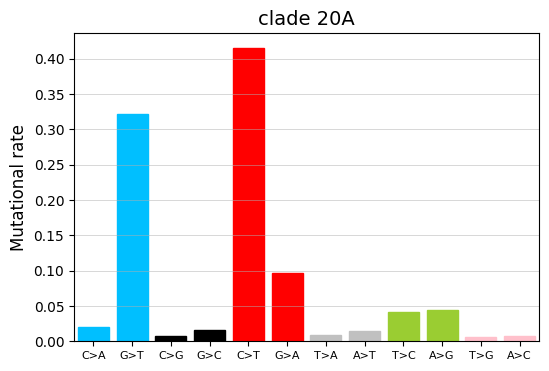

In [18]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

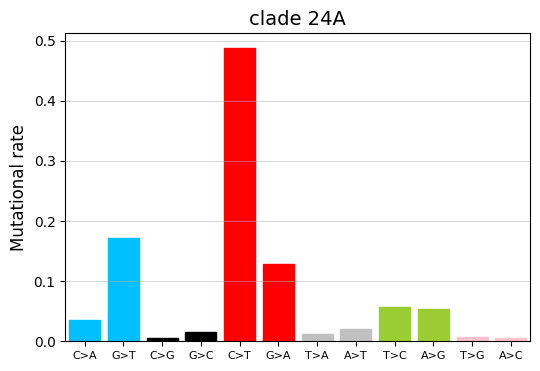

In [11]:
ax = plot_mutspec12(spectrum_24A, 'rate', 'clade 24A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

In [19]:
spectrum_20A_dct = spectrum_20A.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_20A_dct)

## Calculate expected AA substitutions matrix
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
exp_aa_subst.to_csv('data/20A/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)


## Calculate codon and AA equilibrium frequencies
M = cdn_spectrum_to_matrix(df_changes)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/20A/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

cdn      freq   aa
0   AAA  0.003032  Lys
1   AAC  0.003836  Asn
2   AAG  0.001522  Lys
3   AAT  0.012910  Asn
4   ACA  0.003836  Thr
..  ...       ...  ...
59  TGT  0.029462  Cys
60  TTA  0.054818  Leu
61  TTC  0.074299  Phe
62  TTG  0.029462  Leu
63  TTT  0.232062  Phe

[64 rows x 3 columns]

In [20]:
exp_aa_subst_matrix

aa2       Ala       Arg       Asn       Asp       Cys       Gln       Glu  \
aa1                                                                         
Ala  1.000000  0.000000  0.000000  0.040682  0.000000  0.000000  0.040682   
Arg  0.000000  1.197024  0.000000  0.000000  0.830586  0.194619  0.000000   
Asn  0.000000  0.000000  0.456105  0.087906  0.000000  0.000000  0.000000   
Asp  0.015079  0.000000  0.194619  0.456105  0.000000  0.000000  0.042965   
Cys  0.000000  0.081625  0.000000  0.000000  0.456105  0.000000  0.000000   
Gln  0.000000  0.087906  0.000000  0.000000  0.000000  0.141263  0.014303   
Glu  0.015079  0.000000  0.000000  0.359667  0.000000  0.031033  0.141263   
Gly  0.062066  0.256685  0.000000  0.194619  0.644149  0.000000  0.194619   
His  0.000000  0.087906  0.040682  0.014303  0.000000  0.042965  0.000000   
Ile  0.000000  0.006517  0.017912  0.000000  0.000000  0.000000  0.000000   
Leu  0.000000  0.026069  0.000000  0.000000  0.000000  0.017912  0.000000   
Lys  0.000000  0.087906  0.359667  0.000000  0.000000  0.015079  0.087906   
Met  0.000000  0.006517  0.000000  0.000000  0.000000  0.000000  0.000000   
Phe  0.000000  0.000000  0.000000  0.000000  0.013034  0.000000  0.000000   
Pro  0.028605  0.028605  0.000000  0.000000  0.000000  0.040682  0.000000   
Ser  0.026069  0.058044  0.194619  0.000000  0.043375  0.000000  0.000000   
Thr  0.175812  0.014303  0.040682  0.000000  0.000000  0.000000  0.000000   
Trp  0.000000  0.049768  0.000000  0.000000  0.337591  0.000000  0.000000   
Tyr  0.000000  0.000000  0.017912  0.013034  0.087906  0.000000  0.000000   
Val  0.163249  0.000000  0.000000  0.017912  0.000000  0.000000  0.017912   

aa2       Gly       His       Ile       Leu       Lys       Met       Phe  \
aa1                                                                         
Ala  0.028605  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Arg  0.116511  0.194619  0.322075  1.288299  0.194619  0.322075  0.000000   
Asn  0.000000  0.015079  0.029072  0.000000  0.042965  0.000000  0.000000   
Asp  0.087906  0.031033  0.000000  0.000000  0.000000  0.000000  0.000000   
Cys  0.013034  0.000000  0.000000  0.000000  0.000000  0.000000  0.644149   
Gln  0.000000  0.359667  0.000000  0.029072  0.040682  0.000000  0.000000   
Glu  0.087906  0.000000  0.000000  0.000000  0.194619  0.000000  0.000000   
Gly  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
His  0.000000  0.456105  0.000000  0.029072  0.000000  0.000000  0.000000   
Ile  0.000000  0.000000  0.507478  0.037155  0.008956  0.057621  0.029072   
Leu  0.000000  0.017912  0.069979  2.053473  0.000000  0.029297  1.190253   
Lys  0.000000  0.000000  0.014536  0.000000  0.141263  0.014536  0.000000   
Met  0.000000  0.000000  0.434901  0.022076  0.008956  0.000000  0.000000   
Phe  0.000000  0.000000  0.017912  0.124590  0.000000  0.000000  0.456105   
Pro  0.000000  0.040682  0.000000  1.661172  0.000000  0.000000  0.000000   
Ser  0.087906  0.000000  0.644149  0.830586  0.000000  0.000000  0.830586   
Thr  0.000000  0.000000  1.245879  0.000000  0.040682  0.415293  0.000000   
Trp  0.006517  0.000000  0.000000  0.322075  0.000000  0.000000  0.000000   
Tyr  0.000000  0.081625  0.000000  0.000000  0.000000  0.000000  0.029072   
Val  0.026069  0.000000  0.291929  0.706215  0.000000  0.097310  0.644149   

aa2       Pro       Ser       Thr       Trp       Tyr       Val  
aa1                                                              
Ala  0.062066  1.288299  0.389238  0.000000  0.000000  1.661172  
Arg  0.062066  0.400349  0.031033  0.429829  0.000000  0.000000  
Asn  0.000000  0.087906  0.015079  0.000000  0.029072  0.000000  
Asp  0.000000  0.000000  0.000000  0.000000  0.644149  0.029072  
Cys  0.000000  0.048945  0.000000  0.013668  0.194619  0.000000  
Gln  0.015079  0.000000  0.000000  0.000000  0.000000  0.000000  
Glu  0.000000  0.000000  0.000000  0.000000  0.000000  0.029072  
Gly  0.000000  0

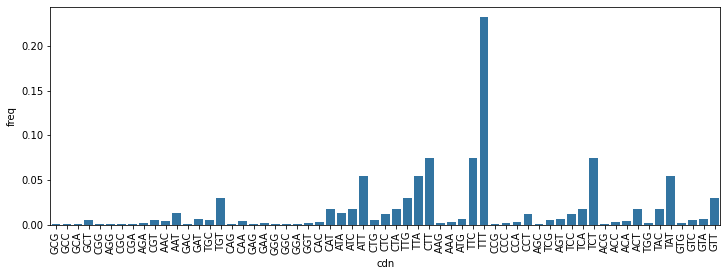

In [104]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

### qualitative model

In [105]:
aa_flows = df_changes\
    .query('(sbs == "C>T" | sbs == "G>T") & aa1 != "*" & aa2 != "*" & aa1 != aa2')\
    .groupby(['aa1', 'aa2']).rate.count().reset_index()

inflow = aa_flows.groupby('aa2').rate.sum().rename('inflow')
outflow = aa_flows.groupby('aa1').rate.sum().rename('outflow')
inflow.index.name='aa'
outflow.index.name='aa'
_flow = inflow.to_frame().join(outflow, how='outer').fillna(0).astype(int)
_flow['flow'] = _flow['inflow'] - _flow['outflow']
_flow.sort_values('flow')[['flow']].T

aa    Arg  Ala  Pro  Gly  Thr  Glu  His  Gln  Lys  Asp  Trp  Asn  Met  Cys  \
flow  -10   -8   -8   -7   -4   -1   -1   -1   -1   -1    0    1    1    3   

aa    Ser  Tyr  Val  Ile  Phe  Leu  
flow    3    4    4    7    9   10

In [106]:
aa_flows.query('aa1 == "Ser" | aa2 == "Ser"')

aa1  aa2  rate
0   Ala  Ser     4
6   Arg  Ser     1
20  Pro  Ser     4
21  Ser  Ile     2
22  Ser  Leu     2
23  Ser  Phe     2

In [107]:
_flow.sort_values('flow')

inflow  outflow  flow
aa                        
Arg       0       10   -10
Ala       0        8    -8
Pro       0        8    -8
Gly       0        7    -7
Thr       0        4    -4
Glu       0        1    -1
His       1        2    -1
Gln       0        1    -1
Lys       0        1    -1
Asp       1        2    -1
Trp       2        2     0
Asn       1        0     1
Met       2        1     1
Cys       5        2     3
Ser       9        6     3
Tyr       4        0     4
Val       8        4     4
Ile       7        0     7
Phe       9        0     9
Leu      13        3    10

In [9]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/20A/aa_eq_freqs.csv', index=False)
eq_freqs_aa.T

0         1         2         3         4         5         6   \
aa         Phe       Leu       Ser       Ile       Tyr       Val       Cys   
freq  0.314637  0.197825  0.119281  0.086898  0.073639  0.044165  0.035283   

            7         8         9         10        11        12        13  \
aa         Thr       His       Pro       Asn       Arg       Asp       Ala   
freq  0.025257  0.020183  0.017862  0.017199  0.009142  0.008012  0.007127   

            14        15        16        17        18        19  
aa         Met       Gln       Lys       Gly       Glu       Trp  
freq  0.006878  0.005073  0.004677  0.002844  0.002015  0.002004

## Load OBS

In [9]:
obs_raw = pd.read_csv('data/bloom_etal/aggregated.csv').query('subset == "all" & exclude == False')
obs_raw['Mut'] = obs_raw['nt_mutation'].str[0] + '>' + obs_raw['nt_mutation'].str[-1]
obs = obs_raw.query('synonymous == False & noncoding == False').drop(['synonymous', 'noncoding', 'four_fold_degenerate'], axis=1)

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

protein    aa_mutation nt_mutation     codon_change  nt_site  \
0              ORF1ab         P5401L     C16466T          CCA>CTA    16466   
1                   M           I82T     T26767C          ATC>ACC    26767   
3              ORF1ab         P4715L     C14408T          CCT>CTT    14408   
4              ORF1ab         A6319V     C19220T          GCT>GTT    19220   
5              ORF1ab         I5658V     A17236G          ATA>GTA    17236   
...               ...            ...         ...              ...      ...   
1553870  ORF1a;ORF1ab  V4369A;V4369A     T13371C  GTC>GCC;GTC>GCC    13371   
1553871  ORF1a;ORF1ab  V4350A;V4350A     T13314C  GTA>GCA;GTA>GCA    13314   
1553874  ORF1a;ORF1ab  V3763F;V3763F     G11552T  GTT>TTT;GTT>TTT    11552   
1553875  ORF1a;ORF1ab  V3759G;V3759G     T11541G  GTT>GGT;GTT>GGT    11541   
1553876  ORF1a;ORF1ab  V4102A;V4102A     T12570C  GTA>GCA;GTA>GCA    12570   

        reference_nt clade_founder_nt  exclude  count  count_terminal  \
0                  C                C    False     70              37   
1                  T                T    False     58              18   
3                  C                C    False     52              26   
4                  C                C    False     50              15   
5                  A                A    False     48              24   
...              ...              ...      ...    ...             ...   
1553870            T                T    False      1               1   
1553871            T                T    False      1               1   
1553874            G                G    False      1               1   
1553875            T                T    False      1               0   
1553876            T                T    False      1               0   

         count_non_terminal  mean_log_size clade subset    codon  \
0                        33       0.708825   19A    all      CCA   
1                        40       1.237886   19A    all      ATC   
3                        26       0.678436   19A    all      CCT   
4                        35       1.097059   19A    all      GCT   
5                        24       0.581333   19A    all      ATA   
...                     ...            ...   ...    ...      ...   
1553870                   0       0.000000   24E    all  GTC;GTC   
1553871                   0       0.000000   24E    all  GTA;GTA   
1553874                   0       0.000000   24E    all  GTT;GTT   
1553875                   1       0.693147   24E    all  GTT;GTT   
1553876                   1       1.098612   24E    all  GTA;GTA   

        codon_position codon_site  Mut aa1 aa2  
0                    2       5401  C>T   P   L  
1                    2         82  T>C   I   T  
3                    2       4715  C>T   P   L  
4                    2       6319  C>T   A   V  
5                    1       5658  A>G   I   V  
...                ...        ...  ...  ..  ..  
1553870            2;2  4369;4369  T>C   V   A  
1553871            2;2  4350;4350  T>C   V   A  
1553874            1;1  3763;3763  G>T   V   F  
1553875            2;2  3759;3759  T>G   V   G  
1553876            2;2  4102;4102  T>C   V   A  

[440648 rows x 20 columns]

### terminal vs non-terminal spectrum and mutations

1.2971005556962412


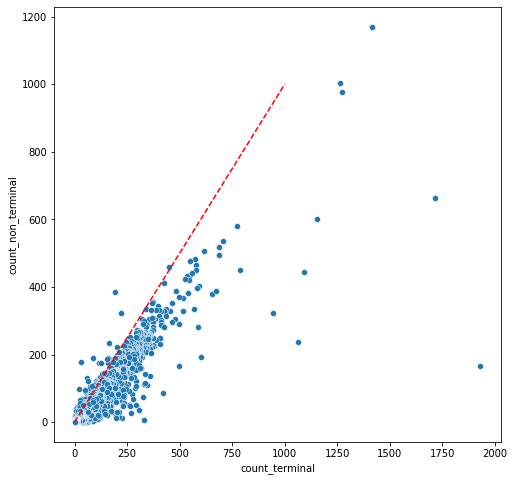

In [41]:
plt.figure(figsize=(8, 8))
sns.scatterplot(obs, x='count_terminal', y='count_non_terminal')
plt.plot([0, 1000],[0, 1000], 'r--')
print((obs.count_terminal / obs.count_non_terminal).replace(np.inf, np.nan).mean())

In [27]:
from scipy.spatial.distance import pdist

In [71]:
_ = obs_raw.query('four_fold_degenerate == True')\
    .groupby(['clade', 'Mut'])[['count_terminal', 'count_non_terminal']].sum()\
        .melt(ignore_index=False, value_name='ObsNum', var_name='tree_set').reset_index()\
            .pivot(index=['clade','tree_set'], columns='Mut', values='ObsNum')

print('ter and non-ter spectra for clades:\n\nclade, cossim, ter_mut_frac, PE_mean(%)')
for cl in _.index.get_level_values(0).unique():
    curd = _.loc[cl]
    _nmuts = curd.sum(axis=1).values
    if _nmuts.sum() < 5000:
        continue
    ter_frac = _nmuts[1] / _nmuts.sum()
    cossim = 1-pdist(curd, 'cosine')[0]

    curs = curd.T / curd.sum(1)
    curs['pe'] = (curs['count_terminal'] - curs['count_non_terminal']) \
        / curs['count_terminal'] * 100
    
    print(f'{cl}    {cossim:.4f}  {ter_frac:.3f}         {curs['pe'].abs().mean():.2f}')


ter and non-ter spectra for clades:

clade, cossim, ter_mut_frac, PE_mean(%)
20A    0.9989  0.555         10.59
20B    0.9968  0.565         12.57
20C    0.9958  0.576         16.14
20E    0.9973  0.567         14.56
20G    0.9995  0.565         11.98
20I    0.9992  0.558         9.48
20J    0.9993  0.611         10.33
21C    0.9984  0.550         11.57
21I    0.9985  0.586         10.98
21J    0.9989  0.580         9.63
21K    0.9985  0.642         10.43
21L    0.9993  0.600         6.89
22A    0.9998  0.616         9.79
22B    0.9991  0.597         7.61
22C    0.9994  0.649         8.91
22D    0.9993  0.572         7.41
22E    0.9988  0.600         8.43
22F    0.9989  0.611         21.27
23A    0.9994  0.585         9.71
23B    0.9995  0.569         11.63
23C    0.9976  0.574         17.22
23D    0.9996  0.577         9.27
23F    0.9994  0.605         9.02
24A    0.9997  0.640         10.56


In [59]:
curs = _.loc['21J'].T / _.loc['21J'].sum(1)
curs['pe'] = (curs['count_terminal'] - curs['count_non_terminal']) / curs['count_terminal'] * 100
curs['pe'].abs().mean()

np.float64(9.633300460882298)

### Explore OBS

In [51]:
obs.codon_position.value_counts()

codon_position
1      110949
2      100113
1;1     89804
2;2     87542
3       29004
3;3     23236
Name: count, dtype: int64

In [52]:
obs_raw['count'].sum(), obs['count'].sum()

(np.int64(5635999), np.int64(3175359))

In [53]:
print('Number of mutations:')
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack()

Number of mutations:


synonymous    False   True 
clade                      
19A            7462    3999
20A           67405   43933
20B           56079   36627
20C           56285   37562
20E           38269   24958
20F            2218    1300
20G           52212   36639
20I          217281  146099
20J           17075   12236
21C           23617   16296
21I           86071   55531
21J         1032287  643592
21K          393196  295375
21L          315056  250437
22A           43079   35461
22B          348753  270719
22C           61092   47564
22D           21735   16967
22E           96306   78990
22F           20684   16505
23A           96095   75345
23B           31774   25859
23C           16612   13041
23D           32087   25902
23E           12181    9604
23F           45178   37377
24A           67943   58881
24B            9791    8564
24C            9769    8829
24E           12967   11248

In [54]:
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack().shape

(30, 2)

In [55]:
print('Number of mutations:')
obs_raw.query('synonymous == True').groupby(['clade', 'four_fold_degenerate'])['count'].sum().unstack()

Number of mutations:


four_fold_degenerate   False   True 
clade                               
19A                     2299    1700
20A                    24963   18970
20B                    20543   16084
20C                    21405   16157
20E                    14092   10866
20F                      758     542
20G                    21294   15345
20I                    84469   61630
20J                     6871    5365
21C                     9495    6801
21I                    30942   24589
21J                   356462  287130
21K                   171324  124051
21L                   146835  103602
22A                    20676   14785
22B                   158444  112275
22C                    28027   19537
22D                     9550    7417
22E                    46045   32945
22F                     9294    7211
23A                    43016   32329
23B                    14765   11094
23C                     7578    5463
23D                    14918   10984
23E                     5530    4074
23F                    21588   15789
24A                    34504   24377
24B                     5131    3433
24C                     5143    3686
24E                     6636    4612

In [56]:
obs.groupby('clade')['count'].sum().rename('aa_subst_cnt').sort_index().reset_index()

clade  aa_subst_cnt
0    19A          7185
1    20A         65078
2    20B         54164
3    20C         54346
4    20E         36904
5    20F          2161
6    20G         50463
7    20I        210313
8    20J         16464
9    21C         22742
10   21I         82872
11   21J        998289
12   21K        379267
13   21L        303609
14   22A         41499
15   22B        335444
16   22C         58845
17   22D         20777
18   22E         93354
19   22F         19810
20   23A         92364
21   23B         30556
22   23C         15938
23   23D         30973
24   23E         11722
25   23F         43582
26   24A         65370
27   24B          9422
28   24C          9371
29   24E         12475

### Check site specifity

In [4]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
265      266   A     GAT       1  mat_peptide  ORF1ab          1           1   
266      267   T     ATG       1  mat_peptide  ORF1ab          2           2   
267      268   G     TGG       1  mat_peptide  ORF1ab          3           3   
268      269   G     GGA       1  mat_peptide  ORF1ab          4           1   
269      270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29669  29670   C     ACA       1          CDS   ORF10        113           2   
29670  29671   A     CAT       1          CDS   ORF10        114           3   
29671  29672   T     ATA       1          CDS   ORF10        115           1   
29672  29673   A     TAG       1          CDS   ORF10        116           2   
29673  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  
265     ATG  
266     ATG  
267     ATG  
268     GAG  
269     GAG  
...     ...  
29669   ACA  
29670   ACA  
29671   TAG  
29672   TAG  
29673   TAG  

[29260 rows x 9 columns]

In [5]:
ref_sites_df['MutCount'] = ref_sites_df['Pos'].map(obs_raw.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
0        266   A     GAT       1  mat_peptide  ORF1ab          1           1   
1        267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2        268   G     TGG       1  mat_peptide  ORF1ab          3           3   
3        269   G     GGA       1  mat_peptide  ORF1ab          4           1   
4        270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29255  29670   C     ACA       1          CDS   ORF10        113           2   
29256  29671   A     CAT       1          CDS   ORF10        114           3   
29257  29672   T     ATA       1          CDS   ORF10        115           1   
29258  29673   A     TAG       1          CDS   ORF10        116           2   
29259  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  MutCount  nt_site codon_position  
0       ATG       0.0      NaN            NaN  
1       ATG       2.0    267.0            2;2  
2       ATG       1.0    268.0            3;3  
3       GAG     239.0    269.0            1;1  
4       GAG     154.0    270.0            2;2  
...     ...       ...      ...            ...  
29255   ACA     687.0  29670.0              2  
29256   ACA     114.0  29671.0              3  
29257   TAG      57.0      NaN            NaN  
29258   TAG      29.0      NaN            NaN  
29259   TAG     177.0      NaN            NaN  

[29260 rows x 12 columns]

In [69]:
ref_sites_df.MutCount.sum(), obs_raw['count'].sum()

(np.float64(5611539.0), np.int64(5635999))

In [70]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean       191.781921
std        376.108149
min          0.000000
25%         27.000000
50%         78.000000
75%        176.000000
max       8529.000000
Name: MutCount, dtype: float64

In [71]:
ref_sites_df.MutCount.value_counts(normalize=True).rename('freq').reset_index()

MutCount      freq
0          1.0  0.026760
1          0.0  0.024094
2          2.0  0.022078
3          3.0  0.018626
4          4.0  0.015379
...        ...       ...
1756     820.0  0.000034
1757     787.0  0.000034
1758    1351.0  0.000034
1759    1015.0  0.000034
1760    1145.0  0.000034

[1761 rows x 2 columns]

In [75]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean       191.781921
std        376.108149
min          0.000000
25%         27.000000
50%         78.000000
75%        176.000000
max       8529.000000
Name: MutCount, dtype: float64

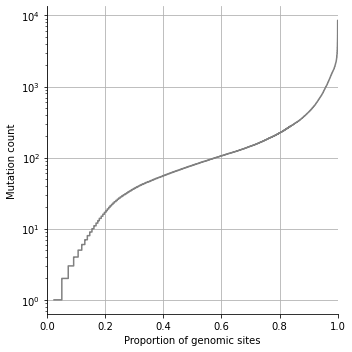

In [79]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCount', kind='ecdf', log_scale=(False, True), color='gray')
# plt.legend([
#         # mpatches.Patch(color='none'), 
#         mpatches.Patch(color='none'),
#     ],[
#         'maximal mutations per site is 6323'], 
#     loc='upper left')
plt.grid(True)
plt.ylabel('Mutation count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

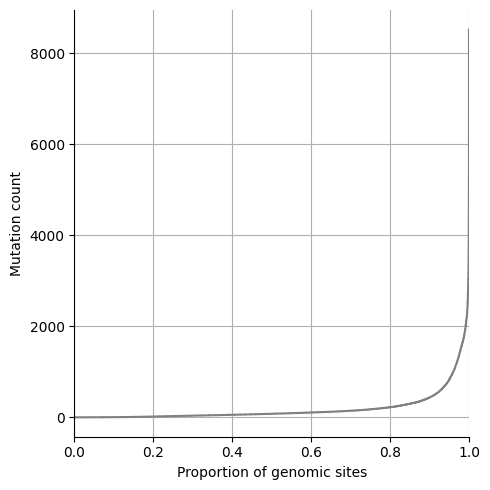

In [72]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCount', kind='ecdf', log_scale=(False, False), color='gray')
# plt.legend([
#         # mpatches.Patch(color='none'), 
#         mpatches.Patch(color='none'),
#     ],[
#         'maximal mutations per site is 6323'], 
#     loc='upper left')
plt.grid(True)
plt.ylabel('Mutation count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
plt.show()

In [11]:
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
0        266   A     GAT       1  mat_peptide  ORF1ab          1           1   
1        267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2        268   G     TGG       1  mat_peptide  ORF1ab          3           3   
3        269   G     GGA       1  mat_peptide  ORF1ab          4           1   
4        270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29255  29670   C     ACA       1          CDS   ORF10        113           2   
29256  29671   A     CAT       1          CDS   ORF10        114           3   
29257  29672   T     ATA       1          CDS   ORF10        115           1   
29258  29673   A     TAG       1          CDS   ORF10        116           2   
29259  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  MutCount  nt_site codon_position  
0       ATG       0.0      NaN            NaN  
1       ATG       2.0    267.0            2;2  
2       ATG       1.0    268.0            3;3  
3       GAG     239.0    269.0            1;1  
4       GAG     154.0    270.0            2;2  
...     ...       ...      ...            ...  
29255   ACA     687.0  29670.0              2  
29256   ACA     114.0  29671.0              3  
29257   TAG      57.0      NaN            NaN  
29258   TAG      29.0      NaN            NaN  
29259   TAG     177.0      NaN            NaN  

[29260 rows x 12 columns]

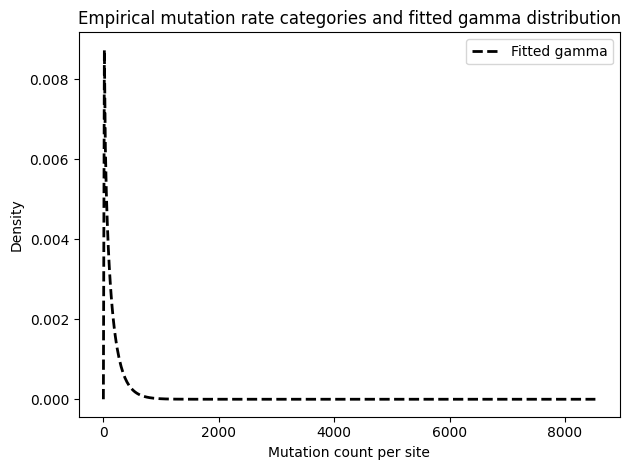

Fitted gamma parameters: alpha=0.81, beta=173.62


In [59]:
from scipy.stats import gamma
import numpy as np

import matplotlib.pyplot as plt

# Remove NaN and zeros for fitting, but keep zeros for invariant category
mut_counts = ref_sites_df['MutCount'].fillna(0)
mut_counts_nonzero = mut_counts[mut_counts > 0]

# Fit gamma distribution to nonzero mutation counts
fit_alpha, fit_loc, fit_beta = gamma.fit(mut_counts_nonzero[mut_counts_nonzero.between(10, 1000)], )

# Calculate empirical quantiles for 6 rate categories (excluding invariant)
quantiles = np.linspace(0, 1, 7)
rate_edges = np.quantile(mut_counts_nonzero, quantiles)

# Assign categories: 0 for invariant (MutCount==0), 1-6 for empirical bins
def assign_category(x):
    if x == 0:
        return 0
    for i in range(1, 7):
        if rate_edges[i-1] < x <= rate_edges[i]:
            return i
    return 6

ref_sites_df['rate_cat'] = mut_counts.apply(assign_category)

# Plot
# plt.figure(figsize=(10, 6))
colors = ['#cccccc', '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']
labels = ['Invariant'] + [f'Cat {i}' for i in range(1, 7)]

for i in range(7):
    data = mut_counts[ref_sites_df['rate_cat'] == i]
    # if len(data) > 0:
    #     plt.hist(data, bins=50, alpha=0.7, color=colors[i], label=labels[i], density=True, histtype='stepfilled')

# Overlay fitted gamma
x = np.linspace(0, mut_counts.max(), 500)
plt.plot(x, gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta), 'k--', lw=2, label='Fitted gamma')

plt.xlabel('Mutation count per site')
plt.ylabel('Density')
plt.title('Empirical mutation rate categories and fitted gamma distribution')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Fitted gamma parameters: alpha={fit_alpha:.2f}, beta={fit_beta:.2f}")

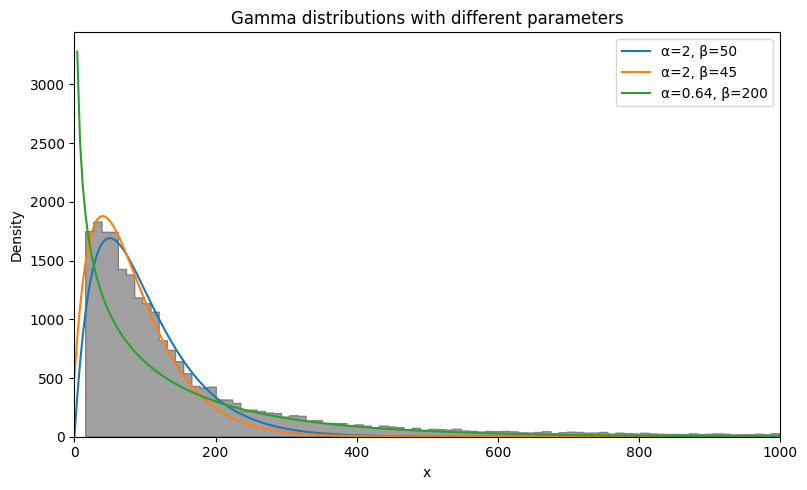

In [128]:
plt.figure(figsize=(8, 5))
sns.histplot(ref_sites_df.query('15 < MutCount'), x='MutCount', color='gray', element='step')


x = np.linspace(0, 2000, 500)
params = [
    (2, 0, 50),
    (2, -5, 45),
    (0.64, 0, 200),
]
for a, loc, scale in params:
    plt.plot(x, gamma.pdf(x, a, loc=loc, scale=scale)*2.3e5, label=f'α={a}, β={scale}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma distributions with different parameters')
plt.legend()
plt.tight_layout()
plt.xlim(0, 1000)
plt.show()

Fitted Gamma: α = 0.573, β = 0.573


/tmp/ipykernel_319202/2546992293.py:38: RuntimeWarning: invalid value encountered in multiply
  rate = np.trapz(x * pdf, x) / np.trapz(pdf, x)  # E[r | l < r < u]
/tmp/ipykernel_319202/2546992293.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rate = np.trapz(x * pdf, x) / np.trapz(pdf, x)  # E[r | l < r < u]
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/numpy/lib/_function_base_impl.py:1496: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


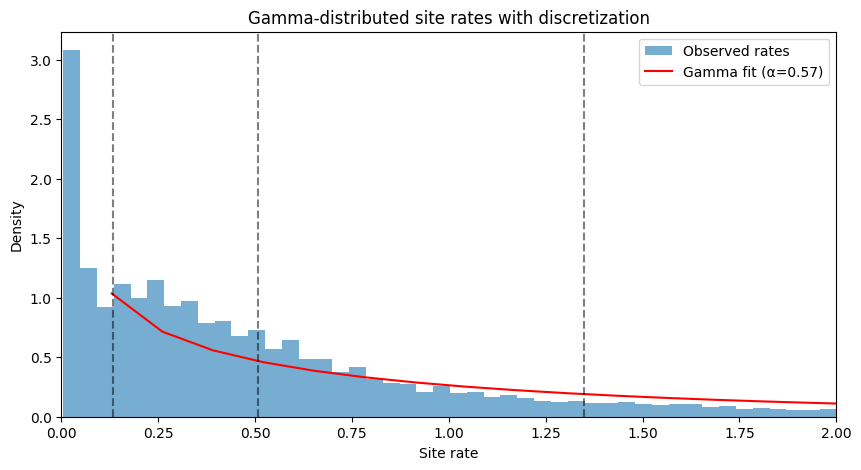


Category representative rates: [       nan 0.29708313 0.86704384        nan]

Example category assignments: [0 0 2 2 2 2 1 3 3 1 2 3 2 3 2 2 1 3 3 1]


In [210]:
import numpy as np
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt

def categorize_site_rates(mut_counts, n_categories=6, plot=False):
    """
    Categorize sites into Gamma-distributed rate categories based on mutation counts.
    
    Parameters:
    - mut_counts: Array of mutation counts per site.
    - n_categories: Number of Gamma rate categories (default=6).
    - plot: If True, plots the Gamma fit and categories.
    
    Returns:
    - site_categories: Array of category indices (0 to n_categories-1) for each site.
    - rates: The representative rate for each category.
    - alpha: Estimated Gamma shape parameter.
    """
    # Normalize mutation counts to relative rates (mean=1)
    rates_observed = mut_counts / np.mean(mut_counts)
    
    # Fit Gamma distribution to observed rates (MLE)
    alpha, _, beta = gamma.fit(rates_observed, floc=0)  # β = 1/scale
    print(f"Fitted Gamma: α = {alpha:.3f}, β = {1/beta:.3f}")
    
    # Discretize Gamma into equal-probability categories
    quantiles = np.linspace(0, 1, n_categories + 1)[1:-1]  # e.g., [0.166, 0.333, ..., 0.833] for n=6
    gamma_quantiles = gamma.ppf(quantiles, a=alpha, scale=beta)  # thresholds
    gamma_quantiles = np.concatenate(([0], gamma_quantiles, [np.inf]))  # add boundaries
    
    # Compute representative rate for each category (mean within bin)
    rates = []
    for i in range(n_categories):
        l, u = gamma_quantiles[i], gamma_quantiles[i+1]
        # Approximate mean rate in category (integral over Gamma PDF)
        x = np.linspace(l, u, 1000)
        pdf = gamma.pdf(x, a=alpha, scale=beta)
        rate = np.trapz(x * pdf, x) / np.trapz(pdf, x)  # E[r | l < r < u]
        rates.append(rate)
    rates = np.array(rates)
    
    # Assign each site to a category
    site_categories = np.digitize(rates_observed, gamma_quantiles) - 1
    
    if plot:
        plt.figure(figsize=(10, 5))
        # Plot histogram of observed rates
        plt.hist(rates_observed, bins=1000, density=True, alpha=0.6, label="Observed rates")
        # Plot fitted Gamma PDF
        x = np.linspace(0, np.max(rates_observed)*1.5, 500)
        plt.plot(x, gamma.pdf(x, a=alpha, scale=beta), 'r-', label=f"Gamma fit (α={alpha:.2f})")
        # Add category thresholds
        for q in gamma_quantiles[1:-1]:
            plt.axvline(q, color='k', linestyle='--', alpha=0.5)
        plt.xlabel("Site rate")
        plt.ylabel("Density")
        plt.legend()
        plt.xlim(0, 2)
        plt.title("Gamma-distributed site rates with discretization")
        plt.show()
    
    return site_categories, rates, alpha

# Example usage
# mut_counts = np.random.poisson(lam=np.random.gamma(shape=0.5, scale=2, size=1000))
mut_counts = ref_sites_df['MutCount']

# Categorize sites into 6 Gamma-based rate categories
categories, rates, alpha = categorize_site_rates(mut_counts[mut_counts > 0], n_categories=4, plot=True)

print("\nCategory representative rates:", rates)
print("\nExample category assignments:", categories[:20])  # First 20 sites

In [211]:
ref_sites_df['rate_cat'] = 0
ref_sites_df.loc[ref_sites_df.MutCount > 0, 'rate_cat'] = categories + 1

In [216]:
ref_sites_df.groupby('rate_cat')['MutCount'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count    mean     std    min     max        sum
rate_cat                                                 
0           705    0.00    0.00    0.0     0.0        0.0
1          6501    9.50    7.64    1.0    26.0    61742.0
2          9732   59.85   20.57   27.0    99.0   582473.0
3          7371  158.08   45.04  100.0   265.0  1165213.0
4          4951  767.95  644.51  266.0  8529.0  3802111.0

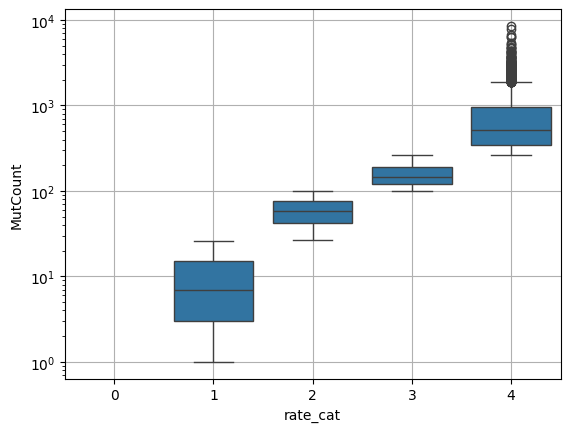

In [213]:
sns.boxplot(ref_sites_df, x='rate_cat', y='MutCount',)
plt.yscale('log')
plt.grid(True)

In [228]:
ref_sites_df.groupby('rate_cat').MutCount.agg(['min', 'max',])

min     max
rate_cat               
0           0.0     0.0
1           1.0    26.0
2          27.0    99.0
3         100.0   265.0
4         266.0  8529.0

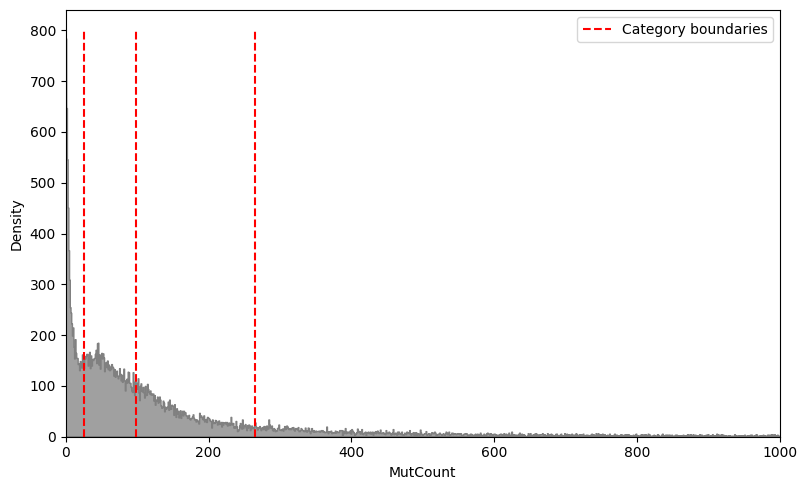

In [236]:
plt.figure(figsize=(8, 5))
sns.histplot(ref_sites_df, x='MutCount', color='gray', element='step', discrete=True)
plt.vlines([26, 99, 265], ymin=0, ymax=800, color='red', linestyle='--', label='Category boundaries')

plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.xlim(0, 1000)
plt.show()

In [239]:
ref_sites_df.sort_values('MutCount', ascending=False).head(20)

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
10057  10323   A     AAG       1  mat_peptide  ORF1ab      10058           2   
20871  21137   A     AAG       1  mat_peptide  ORF1ab      20872           1   
18325  18591   C     TCT       1  mat_peptide  ORF1ab      18326           2   
26326  26681   C     TCC       1          CDS       M        159           3   
1554    1820   G     AGG       1  mat_peptide  ORF1ab       1555           1   
11484  11750   C     ACT       1  mat_peptide  ORF1ab      11485           1   
29199  29614   C     GCA       1    stem_loop   ORF10         57           3   
27019  27384   T     ATT       1          CDS    ORF6        183           3   
28704  29095   C     TCG       1          CDS       N        822           3   
2830    3096   C     TCA       1  mat_peptide  ORF1ab       2831           2   
11271  11537   A     TAT       1  mat_peptide  ORF1ab      11272           1   
25240  25521   C     TCG       1          CDS   ORF3a        129           3   
19717  19983   C     TCT       1  mat_peptide  ORF1ab      19718           2   
1646    1912   C     CCC       1  mat_peptide  ORF1ab       1647           3   
27105  27476   C     ACA       1          CDS   ORF7a         83           2   
27716  28093   C     TCT       1          CDS    ORF8        200           2   
28212  28603   C     TCT       1          CDS       N        330           3   
10103  10369   C     GCA       1  mat_peptide  ORF1ab      10104           3   
27710  28087   C     GCT       1          CDS    ORF8        194           2   
25343  25624   C     TCA       1          CDS   ORF3a        232           1   

      Codon  MutCount  nt_site codon_position  rate_cat  
10057   AAG    8529.0  10323.0            2;2         4  
20871   AGC    7879.0  21137.0              2         4  
18325   TCT    6725.0  18591.0              3         4  
26326   TTC    6345.0  26681.0              3         4  
1554    GGT    6266.0   1820.0            1;1         4  
11484   CTC    5340.0  11750.0            1;1         4  
29199   TGC    5232.0  29614.0              3         4  
27019   GAT    5040.0  27384.0              3         4  
28704   TTC    4891.0      NaN            NaN         4  
2830    TCA    4677.0   3096.0            2;2         4  
11271   ATT    4667.0  11537.0            1;1         4  
25240   TTC    4665.0  25521.0              3         4  
19717   TCT    4394.0      NaN            NaN         4  
1646    TCC    4341.0   1912.0            3;3         4  
27105   ACA    4301.0  27476.0              2         4  
27716   TCT    4270.0  28093.0              2         4  
28212   TTC    4183.0      NaN            NaN         4  
10103   CGC    4156.0      NaN            NaN         4  
27710   GCT    4061.0  28087.0              2         4  
25343   CAC    3986.0  25624.0              1         4

In [214]:
ref_sites_df[['Pos', 'MutCount', 'rate_cat']].rename(columns={'Pos': 'site', 'MutCount': 'mut_count'})\
    .to_csv('data/ref_sites_rates_cat4.csv', index=False, float_format='%g')

### compare obs and exp in table

In [124]:
grantham = pd.read_csv('../grantham.tsv', sep='\t', index_col=0).replace(0, np.nan)
grantham.index.name = 'aa1'
grantham_long = grantham.melt(ignore_index=False, var_name='aa2', value_name='granthamD').dropna().reset_index()
grantham_long['aa1'] = grantham_long['aa1'].map(amino_acid_codes)
grantham_long['aa2'] = grantham_long['aa2'].map(amino_acid_codes)
grantham_long = pd.concat([grantham_long, grantham_long.rename(columns={'aa1':'aa2', 'aa2':'aa1'})], ignore_index=True)
grantham_long

aa1  aa2  granthamD
0    Ser  Arg      110.0
1    Ser  Leu      145.0
2    Arg  Leu      102.0
3    Ser  Pro       74.0
4    Arg  Pro      103.0
..   ...  ...        ...
375  Trp  Asn      174.0
376  Trp  Lys      110.0
377  Trp  Asp      181.0
378  Trp  Glu      152.0
379  Trp  Met       67.0

[380 rows x 3 columns]

In [127]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
aa_subst['label'] = aa_subst.aa1 + '>' + aa_subst.aa2
aa_subst['pe'] = aa_subst['pe'].replace(-np.inf, 0)
aa_subst['diff_freqs_abs'] = (aa_subst['nobs_freqs'] - aa_subst['nexp_freqs']).abs()
aa_subst['division'] = (aa_subst['nobs_freqs'] / aa_subst['nexp_freqs'])
aa_subst['dist_to_diagonal'] = aa_subst['diff_freqs_abs'] / (2**0.5)
aa_subst = aa_subst.merge(grantham_long, 'left')
aa_subst.sort_values('pe')

aa1  aa2    nobs  ref_aa1_freq  nobs_scaled  rate_exp         nexp  \
57   Gly  Trp    11.0      0.059192     9.389043  0.322075   675.334620   
18   Arg  Trp    47.0      0.035905    66.135441  0.429829   901.276603   
15   Arg  Pro     9.0      0.035905    12.664233  0.062066   130.141215   
12   Arg  Leu   234.0      0.035905   329.270066  1.288299  2701.338481   
1    Ala  Glu    22.0      0.067604    16.441510  0.040682    85.303028   
..   ...  ...     ...           ...          ...       ...          ...   
96   Met  Thr   171.0      0.021235   406.846143  0.040812    85.576362   
85   Lys  Arg  1036.0      0.057653   907.878806  0.087906   184.324013   
103  Phe  Val   137.0      0.051395   134.675092  0.013034    27.330566   
45   Glu  Ala   178.0      0.045343   198.336284  0.015079    31.618496   
97   Met  Val   254.0      0.021235   604.321171  0.043953    92.162006   

            diff           pe  nobs_freqs  nexp_freqs    label  \
57   -665.945578 -7092.795348    0.000146    0.010482  Gly>Trp   
18   -835.141162 -1262.774019    0.001026    0.013988  Arg>Trp   
15   -117.476982  -927.628060    0.000197    0.002020  Arg>Pro   
12  -2372.068414  -720.402082    0.005110    0.041926  Arg>Leu   
1     -68.861518  -418.827209    0.000255    0.001324  Ala>Glu   
..           ...          ...         ...         ...      ...   
96    321.269781    78.965915    0.006314    0.001328  Met>Thr   
85    723.554793    79.697289    0.014091    0.002861  Lys>Arg   
103   107.344525    79.706295    0.002090    0.000424  Phe>Val   
45    166.717788    84.058139    0.003078    0.000491  Glu>Ala   
97    512.159165    84.749499    0.009379    0.001430  Met>Val   

     diff_freqs_abs  division  dist_to_diagonal  granthamD  
57         0.010336  0.013903          0.007309      184.0  
18         0.012962  0.073380          0.009165      101.0  
15         0.001823  0.097311          0.001289      103.0  
12         0.036816  0.121891          0.026033      102.0  
1          0.001069  0.192742          0.000756      107.0  
..              ...       ...               ...        ...  
96         0.004986  4.754188          0.003526       81.0  
85         0.011230  4.925451          0.007941       26.0  
103        0.001666  4.927636          0.001178       50.0  
45         0.002588  6.272793          0.001830      107.0  
97         0.007949  6.557162          0.005621       21.0  

[150 rows x 16 columns]

Text(0.5, 0, 'PE')

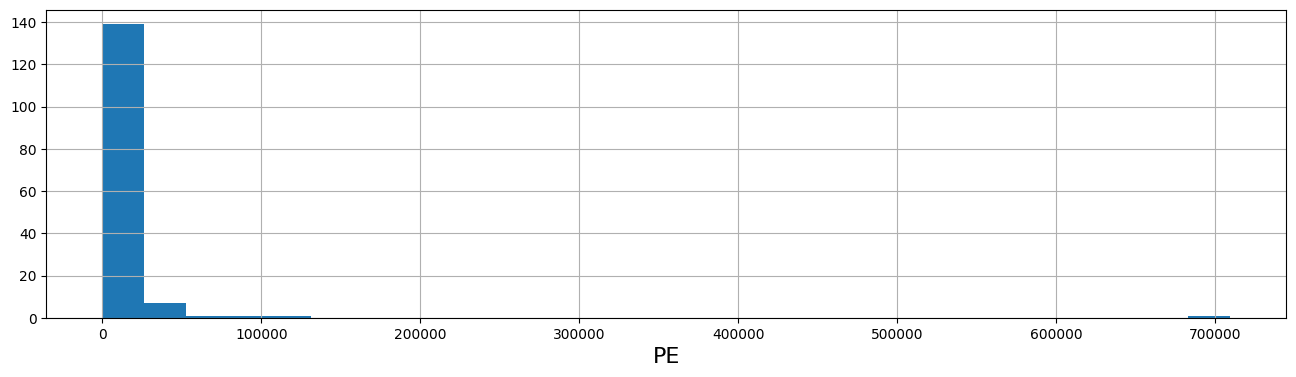

In [128]:
plt.figure(figsize=(16, 4))
(aa_subst.pe.abs()*100).hist(bins=27)
plt.xlabel('PE', fontsize=16)
# plt.xticks(range(0, 1500, 100));

In [129]:
aa_subst.query('label == "Gly>Trp"')

aa1  aa2  nobs  ref_aa1_freq  nobs_scaled  rate_exp       nexp  \
57  Gly  Trp  11.0      0.059192     9.389043  0.322075  675.33462   

          diff           pe  nobs_freqs  nexp_freqs    label  diff_freqs_abs  \
57 -665.945578 -7092.795348    0.000146    0.010482  Gly>Trp        0.010336   

    division  dist_to_diagonal  granthamD  
57  0.013903          0.007309      184.0

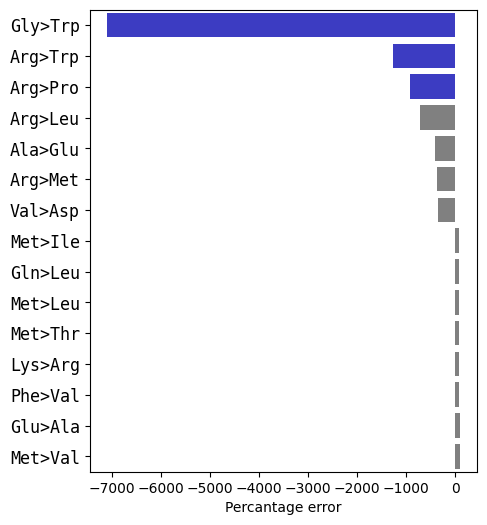

In [130]:
a = aa_subst['pe'][aa_subst['pe']>0].quantile(0.9)
b = aa_subst['pe'][aa_subst['pe']<0].quantile(0.1)

_d = aa_subst[(aa_subst['pe'] > a) | (aa_subst['pe'] < b)].copy()

plt.figure(figsize=(5, 6))
sns.barplot(aa_subst, y='label', x='pe', color='gray',
            order=_d.sort_values('pe').label)

# sns.barplot(aa_subst, y='label', x='pe', color='red', alpha=0.7,
#             order=_d.sort_values('pe').tail(3).label)
sns.barplot(aa_subst, y='label', x='pe', color='blue', alpha=0.7,
            order=_d.sort_values('pe').head(3).label)

plt.ylabel('')
# plt.xlim(-0.45, 0.45)
plt.xlabel('Percantage error')
plt.yticks(fontsize=12, fontname='monospace')
plt.show()

<Axes: >

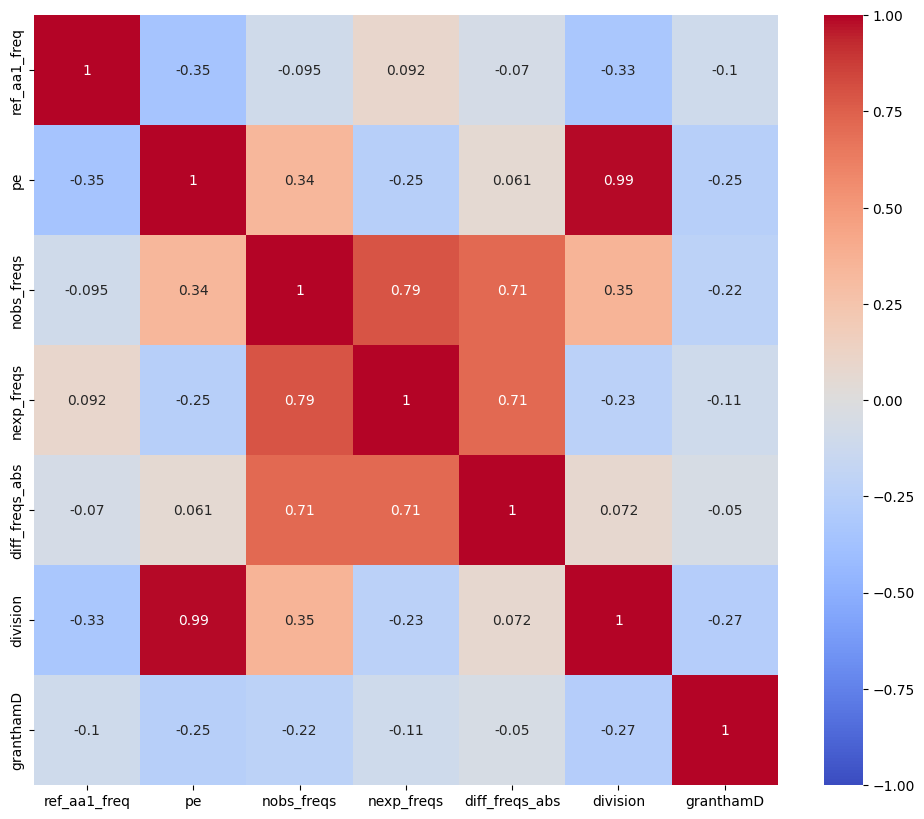

In [131]:
plt.figure(figsize=(12, 10))
sns.heatmap(aa_subst.drop(['aa1', 'aa2', 'label', 'nobs', 'nexp', 
                           'nobs_scaled', 'dist_to_diagonal', 'diff', 'rate_exp'], 
            axis=1).corr('spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Text(0, 0.5, 'Difference between OBS and PRED freqs')

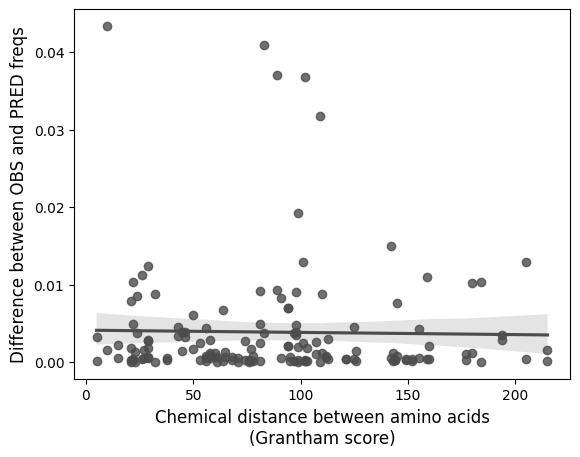

In [132]:
# plt.figure(figsize=(8, 8))
sns.regplot(aa_subst, x='granthamD', y='diff_freqs_abs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(42.33322222222222, 0.5, 'Difference between OBS and PRED freqs')

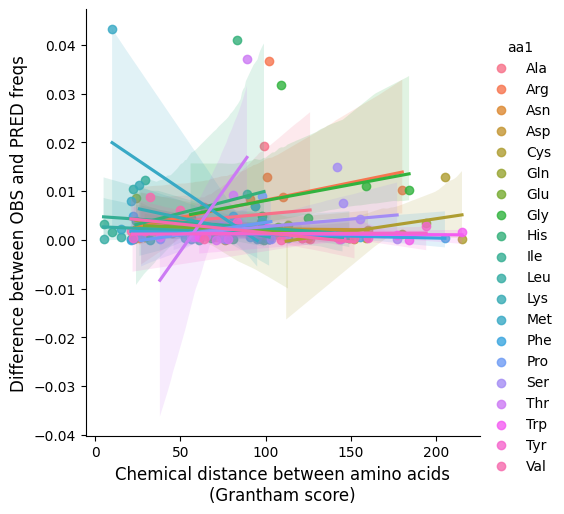

In [ ]:
# plt.figure(figsize=(8, 8))
sns.lmplot(aa_subst, x='granthamD', y='diff_freqs_abs', hue='aa1')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(0, 0.5, 'Expected frequencies')

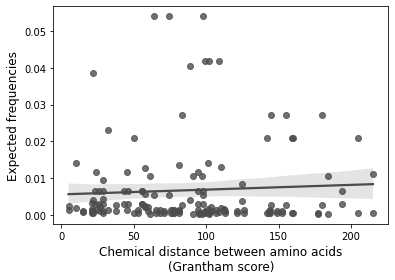

In [116]:
# plt.figure(figsize=(8, 8))
sns.regplot(aa_subst, x='granthamD', y='nexp_freqs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Expected frequencies', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(42.31422222222221, 0.5, 'Expected frequencies')

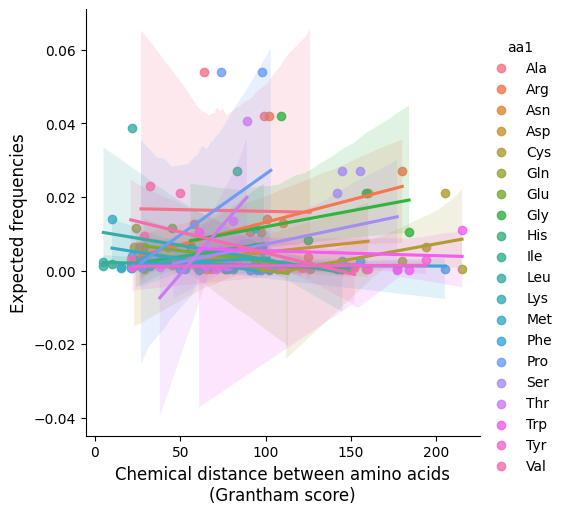

In [136]:
# plt.figure(figsize=(8, 8))
sns.lmplot(aa_subst, x='granthamD', y='nexp_freqs', hue='aa1')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Expected frequencies', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(0.5, 0, 'Observed frequency of amino acid substitution')

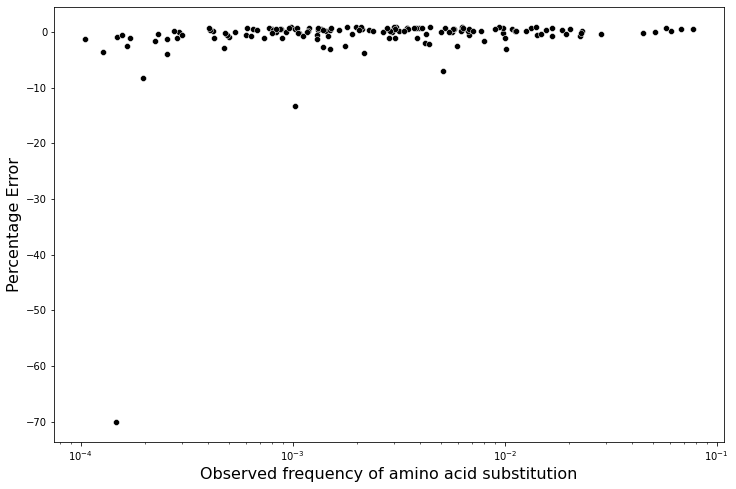

In [92]:
plt.figure(figsize=(12, 8))
sns.scatterplot(aa_subst, x='nobs_freqs', y='mape', c='k')
plt.xscale('log')
# plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
plt.ylabel('Percentage Error', fontsize=16)
plt.xlabel('Observed frequency of amino acid substitution', fontsize=16)

### Model definition and equilibrium

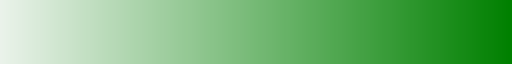

In [32]:
sns.color_palette("light:green", as_cmap=True)

In [14]:
def plot_exp_heatmap(exp_aa_subst_matrix: pd.DataFrame, save_path: str, show=True, annot=False):
    """
    Plot expected amino acid substitution matrix.
    """
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
    max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

    fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                            width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
    sns.heatmap(exp_aa_subst_matrix, annot=annot, fmt=".2f", 
                ax=axs[0, 1], cbar_ax=axs[0, 2], 
                cmap=sns.color_palette("light:green", as_cmap=True), 
                cbar_kws={'label': 'Substitution rate'}, vmin=0,
                mask=exp_aa_subst_matrix==0,
    )
    axs[0, 1].set_ylabel('')
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # axs[0, 1].set_title('Expected substitution rates between amino acids')

    sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
                color='lightgray', edgecolor='black')
    axs[0, 0].set_ylabel('Original', fontsize=14)
    axs[0, 0].set_xlabel('Total Loss')
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['bottom'].set_visible(False)
    axs[0, 0].spines['left'].set_visible(False)
    axs[0, 0].invert_xaxis()
    axs[1, 1].set_ylim(0, max_flow_value)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

    sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
                color='lightgray', edgecolor='black')
    axs[1, 1].set_ylabel('Total Gain')
    axs[1, 1].set_xlabel('Mutant', fontsize=14)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim(max_flow_value, 0)
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

    axs[1, 0].remove()
    axs[1, 2].remove()

    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close(fig)

20A


/tmp/ipykernel_68146/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_68146/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


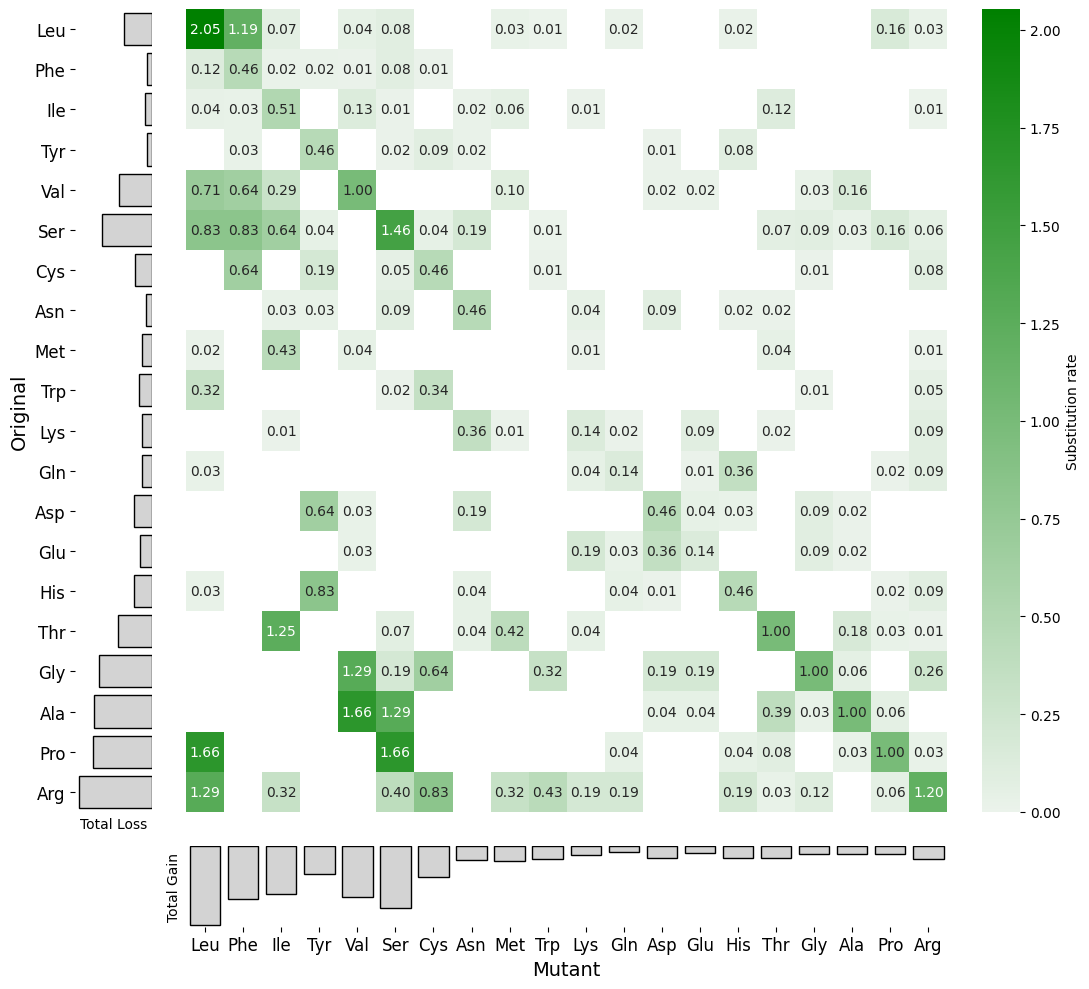

In [17]:
print('20A')
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow20a = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow20a.aa, flow20a.aa], 
                 'figures/exp_exp_aa_subst_matrix_20A.pdf', show=True, annot=True)

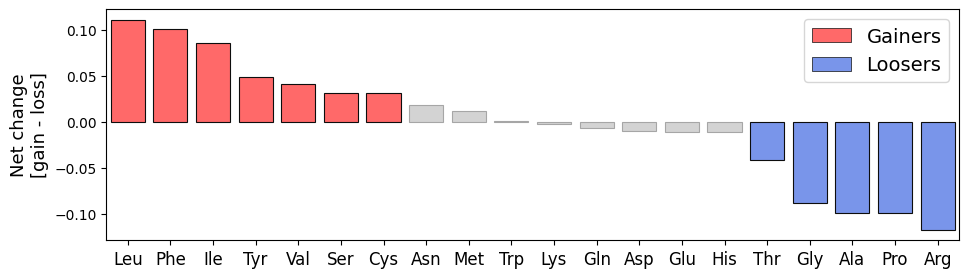

In [22]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow20a, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow20a.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right', fontsize=14)

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Net change\n[gain - loss]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

24A


/tmp/ipykernel_68146/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_68146/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


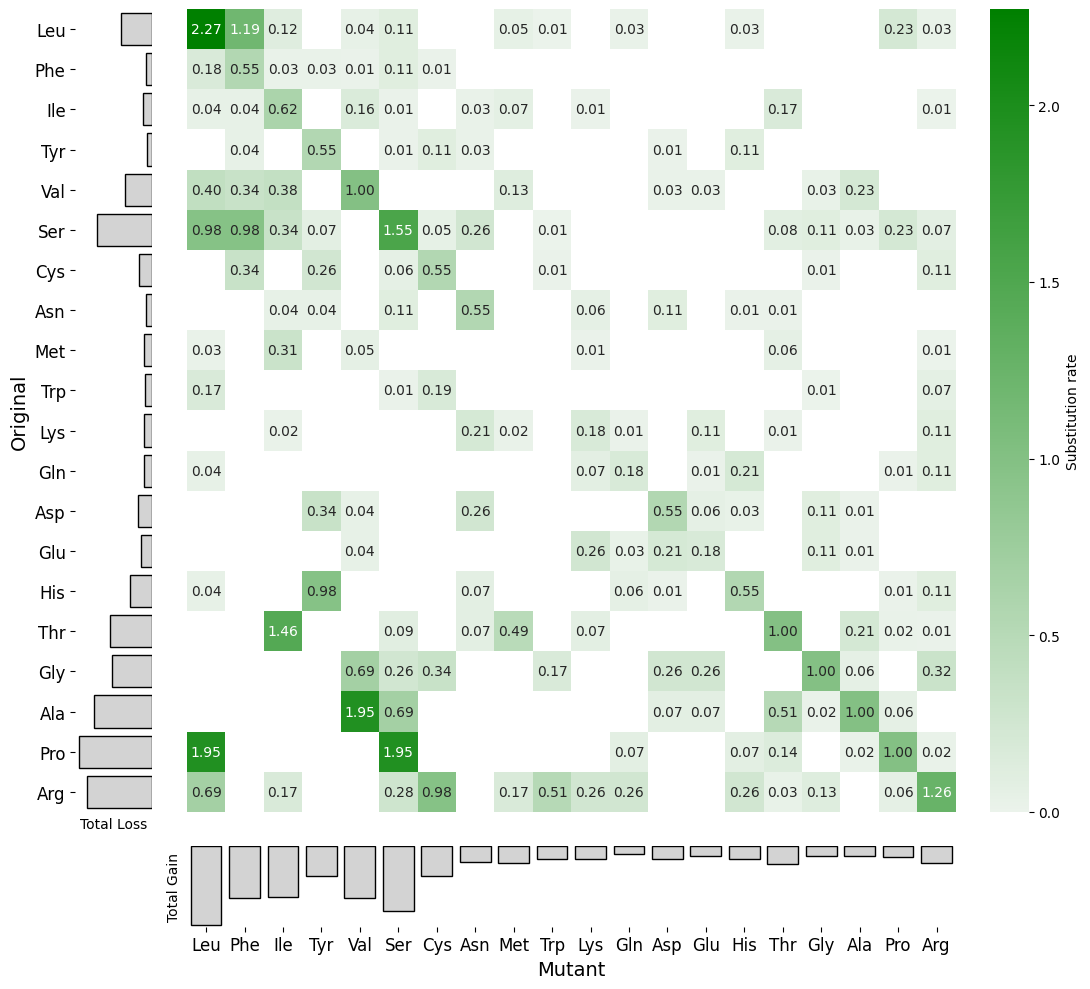

In [23]:
print('24A')
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_24A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow24a = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow20a.aa, flow20a.aa], # order as in 20A
                 'figures/exp_exp_aa_subst_matrix_24A.pdf', show=True, annot=True)

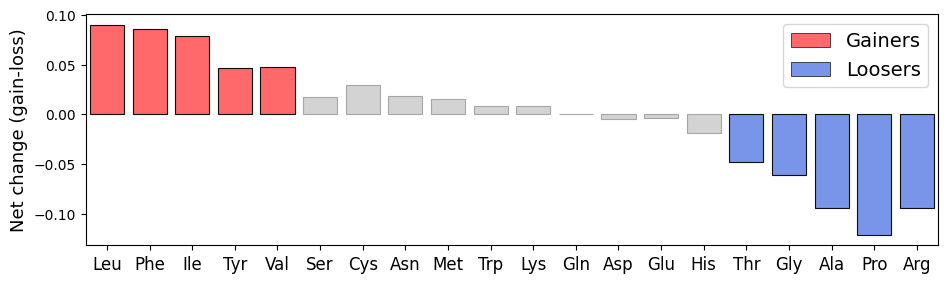

In [26]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow24a, x='aa', y='Flow', order=flow20a.aa,
    color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow24a.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right', fontsize=14)

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Net change (gain-loss)', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

In [121]:
flow.head(7).aa

0    Leu
1    Phe
2    Ile
3    Tyr
4    Val
5    Ser
6    Cys
Name: aa, dtype: object

In [122]:
cur_eq_freqs_aa[cur_eq_freqs_aa.aa.isin(flow.head(7).aa)].freq.sum().round(2)

np.float64(0.87)

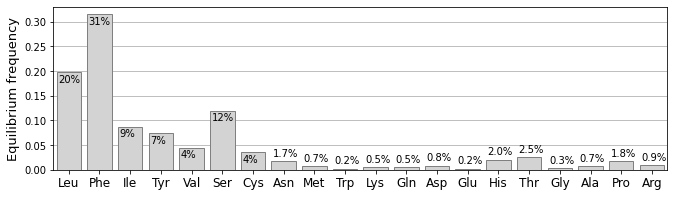

In [ ]:
cur_eq_freqs_aa = pd.read_csv('./data/20A/aa_eq_freqs.csv')

plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = cur_eq_freqs_aa.query('aa == @aa').freq.item()
    x = i-0.35
    if f < 0.03:
        lbl = f"{f*100:.1f}%" 
        y = f + 0.01
    else:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [124]:
aa_subst

aa1  aa2    nobs  ref_aa1_freq  nobs_scaled  rate_exp         nexp  \
0    Ala  Asp   124.0      0.067529    92.782226  0.040682    85.303028   
1    Ala  Glu    22.0      0.067529    16.461363  0.040682    85.303028   
2    Ala  Gly    25.0      0.067529    18.706094  0.028605    59.979759   
3    Ala  Pro    41.0      0.067529    30.677994  0.062066   130.141215   
4    Ala  Ser  1953.0      0.067529  1461.320057  1.288299  2701.338481   
..   ...  ...     ...           ...          ...       ...          ...   
145  Val  Gly    82.0      0.080152    51.693009  0.026069    54.661133   
146  Val  Ile  1153.0      0.080152   726.854141  0.291929   612.123254   
147  Val  Leu  1451.0      0.080152   914.714101  0.706215  1480.810456   
148  Val  Met   133.0      0.080152    83.843539  0.097310   204.041085   
149  Val  Phe  1519.0      0.080152   957.581474  0.644149  1350.669240   

            diff      mape  nobs_freqs  nexp_freqs    label  diff_freqs_abs  \
0       7.479198  0.080610    0.001440    0.001324  Ala>Asp        0.000116   
1     -68.841665 -4.182015    0.000255    0.001324  Ala>Glu        0.001068   
2     -41.273665 -2.206429    0.000290    0.000931  Ala>Gly        0.000641   
3     -99.463221 -3.242168    0.000476    0.002020  Ala>Pro        0.001544   
4   -1240.018424 -0.848560    0.022680    0.041926  Ala>Ser        0.019246   
..           ...       ...         ...         ...      ...             ...   
145    -2.968123 -0.057418    0.000802    0.000848  Val>Gly        0.000046   
146   114.730886  0.157846    0.011281    0.009500  Val>Ile        0.001781   
147  -566.096355 -0.618878    0.014197    0.022983  Val>Leu        0.008786   
148  -120.197546 -1.433593    0.001301    0.003167  Val>Met        0.001866   
149  -393.087766 -0.410501    0.014862    0.020963  Val>Phe        0.006101   

     division  dist_to_diagonal  granthamD  
0    1.087678          0.000082      126.0  
1    0.192975          0.000756      107.0  
2    0.311873          0.000453       60.0  
3    0.235729          0.001092       27.0  
4    0.540961          0.013609       99.0  
..        ...               ...        ...  
145  0.945700          0.000033      109.0  
146  1.187431          0.001259       29.0  
147  0.617712          0.006213       32.0  
148  0.410915          0.001319       21.0  
149  0.708968          0.004314       50.0  

[150 rows x 16 columns]

### subst freqs plot

In [108]:
def plot_subst_freqs(aa_subst, title=''):
    aa_subst = aa_subst.copy()
    aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
    aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(r2)
    print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
                color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs_log', x='nexp_freqs_log')

    ticks = np.linspace(-4, -1, 4)
    ticks_minor = np.log10(np.concat([
        np.linspace(10**-4, 10**-3, 10),
        np.linspace(10**-3, 10**-2, 10)[1:],
        np.linspace(10**-2, 10**-1, 10)[1:],
    ]))
    ax.set_xticks(ticks, ticks, size=14)
    ax.set_yticks(ticks, ticks, size=14)
    ax.set_xticks(ticks_minor, minor=True)
    ax.set_yticks(ticks_minor, minor=True)
    formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    # ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
    # ax.get_xaxis().set_minor_locator(LogLocator())

    # plt.text(-2, -4., 
    #          f"r={cor_res.correlation:.1f} (p={cor_res.pvalue:.1g})", 
    #          fontsize=10)
    plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=16)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=16)
    # plt.grid()
    # plt.ylabel('Наблюдаемые частоты замещений аминокислот', fontsize=14)
    # plt.xlabel('Ожидаемые частоты замещений аминокислот', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_32114/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


0.5541920419627185
Spearman correlation: 0.790 (p-value: 2.99e-33)


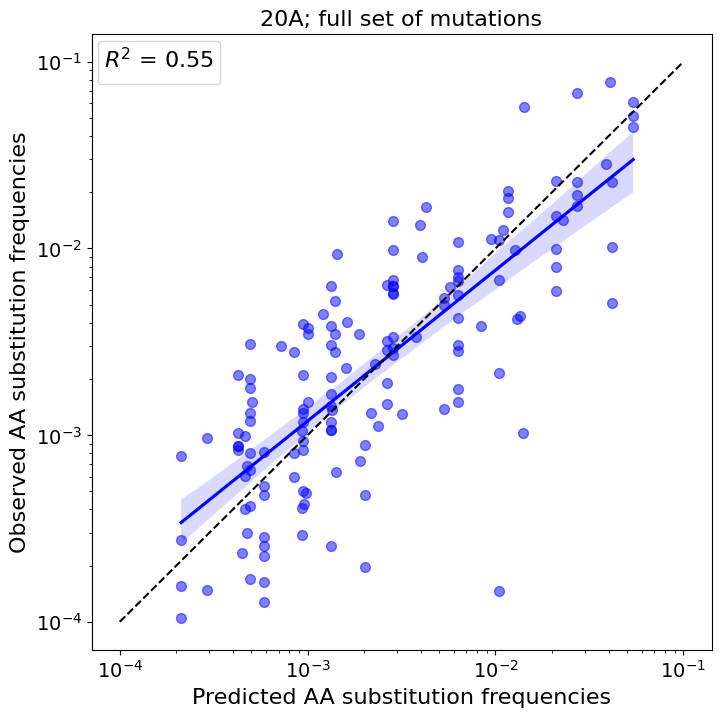

In [110]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; full set of mutations', )

In [111]:
calc_metrics(aa_subst)

{'r2': 0.5541920419627184,
 'mape': 1.4038124517823016,
 'wape': 0.5818972518588895,
 'slope': np.float64(0.6906928257488198),
 'intercept': np.float64(0.0020620478283411995),
 'spearman_corr': np.float64(0.7899707851528157),
 'spearman_p': np.float64(2.9925092584177307e-33),
 'pearson_corr': np.float64(0.7594188270144773),
 'pearson_p': np.float64(2.0145536289396837e-29),
 'ks_stat': np.float64(0.12),
 'ks_p': np.float64(0.23078236357216822),
 'rmse': 0.008265234083120913,
 'log_likelihood': np.float64(-5.368781765558867),
 'mut_count': np.float64(64430.99999999999),
 'mut_type_count': np.int64(149)}

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_32114/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


0.5558540781651562
Spearman correlation: 0.792 (p-value: 1.5e-33)


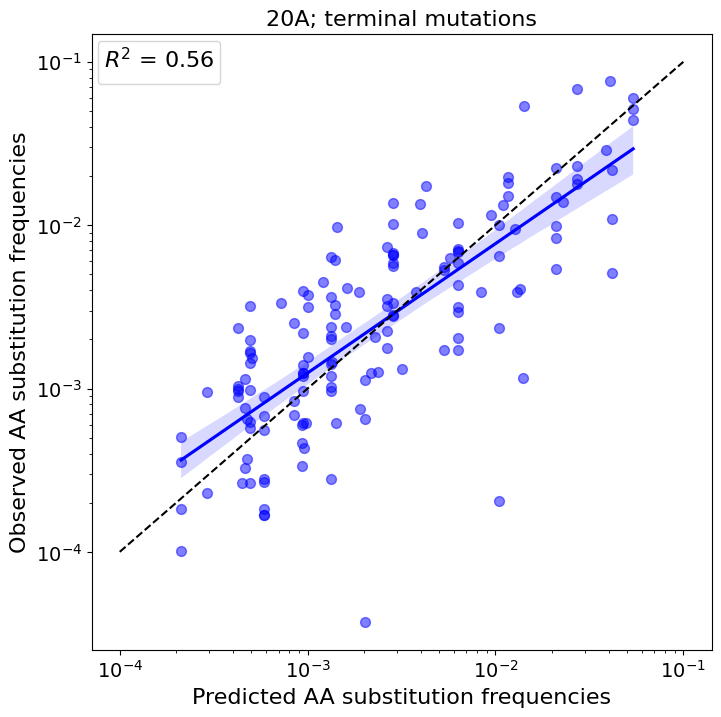

In [112]:
obs_clade = obs[obs['clade'] == '20A'].rename(columns={'count': 'count_all', 'count_terminal': 'count'})
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; terminal mutations', )

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_32114/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


0.5495902322930658
Spearman correlation: 0.779 (p-value: 7.2e-32)


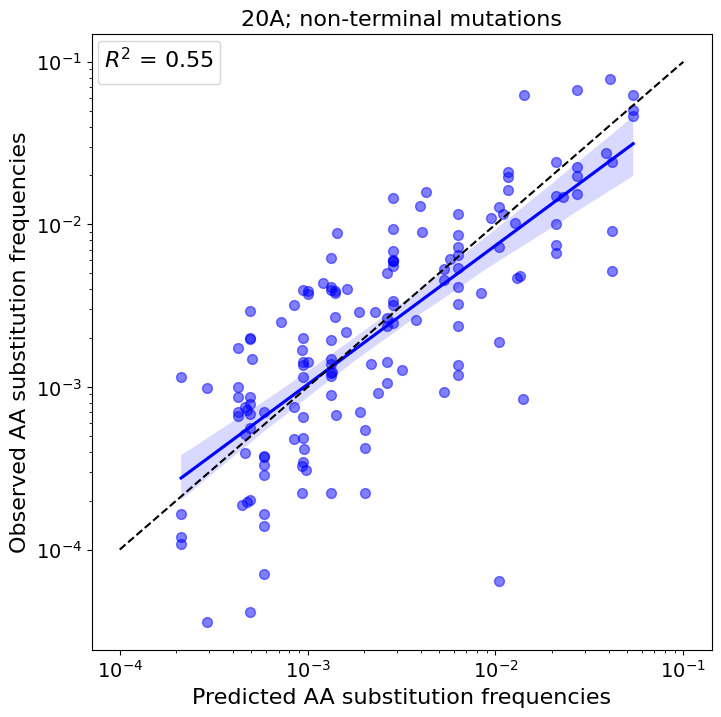

In [113]:
obs_clade = obs[obs['clade'] == '20A'].rename(columns={'count': 'count_all', 'count_non_terminal': 'count'})
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; non-terminal mutations', )

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


pos=1: $R^2$ = 0.66
pos=2: $R^2$ = 0.63
pos=3: $R^2$ = 0.46


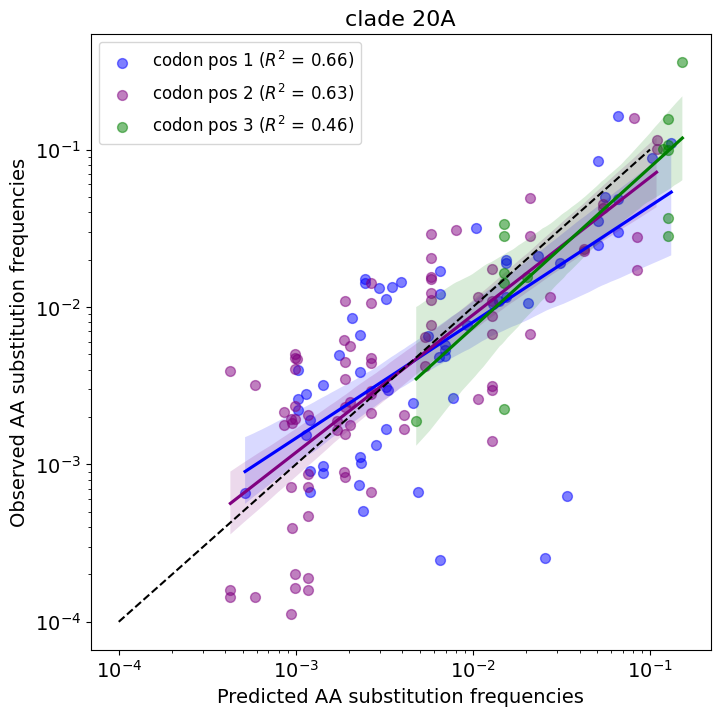

In [114]:
title = 'clade 20A'

_exp_aa_subst1 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 0)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
_exp_aa_subst2 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 1)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
_exp_aa_subst3 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 2)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()


_aa_subst1 = prepare_aa_subst(obs_clade.query(f'codon_position == "1"'), _exp_aa_subst1, aa_freqs_total_dct)
_aa_subst2 = prepare_aa_subst(obs_clade.query(f'codon_position == "2"'), _exp_aa_subst2, aa_freqs_total_dct)
_aa_subst3 = prepare_aa_subst(obs_clade.query(f'codon_position == "3"'), _exp_aa_subst3, aa_freqs_total_dct)


_aa_subst1['nobs_freqs_log'] = np.log10(_aa_subst1['nobs_freqs'])
_aa_subst1['nexp_freqs_log'] = np.log10(_aa_subst1['nexp_freqs'])
_aa_subst2['nobs_freqs_log'] = np.log10(_aa_subst2['nobs_freqs'])
_aa_subst2['nexp_freqs_log'] = np.log10(_aa_subst2['nexp_freqs'])
_aa_subst3['nobs_freqs_log'] = np.log10(_aa_subst3['nobs_freqs'])
_aa_subst3['nexp_freqs_log'] = np.log10(_aa_subst3['nexp_freqs'])

r2_1 = r2_score(_aa_subst1['nobs_freqs'], _aa_subst1['nexp_freqs'])
r2_2 = r2_score(_aa_subst2['nobs_freqs'], _aa_subst2['nexp_freqs'])
r2_3 = r2_score(_aa_subst3['nobs_freqs'], _aa_subst3['nexp_freqs'])
print(f"pos=1: $R^2$ = {r2_1:.2f}")
print(f"pos=2: $R^2$ = {r2_2:.2f}")
print(f"pos=3: $R^2$ = {r2_3:.2f}")

plt.figure(figsize=(8, 8))
sns.regplot(_aa_subst1[_aa_subst1['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 1 ($R^2$ = {r2_1:.2f})')

sns.regplot(_aa_subst2[_aa_subst2['nobs_freqs']>0], 
            color='purple', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 2 ($R^2$ = {r2_2:.2f})')


ax = sns.regplot(_aa_subst3[_aa_subst3['nobs_freqs']>0], 
            color='green', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 3 ($R^2$ = {r2_3:.2f})')

ticks = np.linspace(-4, -1, 4)
ticks_minor = np.log10(np.concat([
    np.linspace(10**-4, 10**-3, 10),
    np.linspace(10**-3, 10**-2, 10)[1:],
    np.linspace(10**-2, 10**-1, 10)[1:],
]))
ax.set_xticks(ticks, ticks, size=14)
ax.set_yticks(ticks, ticks, size=14)
ax.set_xticks(ticks_minor, minor=True)
ax.set_yticks(ticks_minor, minor=True)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
# ax.get_xaxis().set_minor_locator(LogLocator())

# plt.text(-2, -4., 
#          f"r={r2_.correlation:.1f} (p={r2_.pvalue:.1g})", 
#          fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
plt.ylabel('Observed AA substitution frequencies', fontsize=14)
plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
plt.title(title, fontsize=16)
plt.legend(fontsize=12)
# plt.legend(title=f"spearmanr={r2_.correlation:.2f} (p={r2_.pvalue:.1g})", title_fontsize=14)
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_32114/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


0.43458295365194566
Spearman correlation: 0.617 (p-value: 4.37e-17)


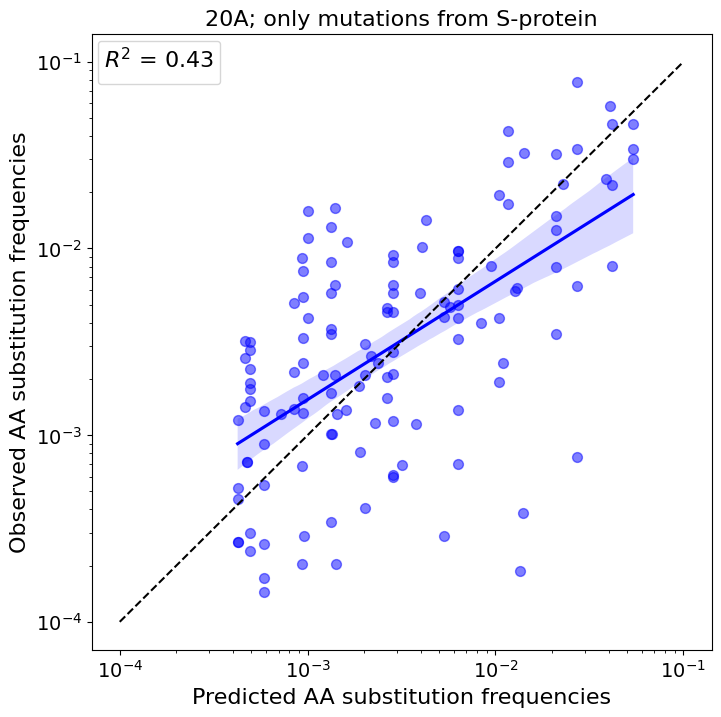

In [115]:
_aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein == 'S'], exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(_aa_subst, '20A; only mutations from S-protein', )

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.5007456282786236
Spearman correlation: 0.763 (p-value: 7.7e-30)


/tmp/ipykernel_32114/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


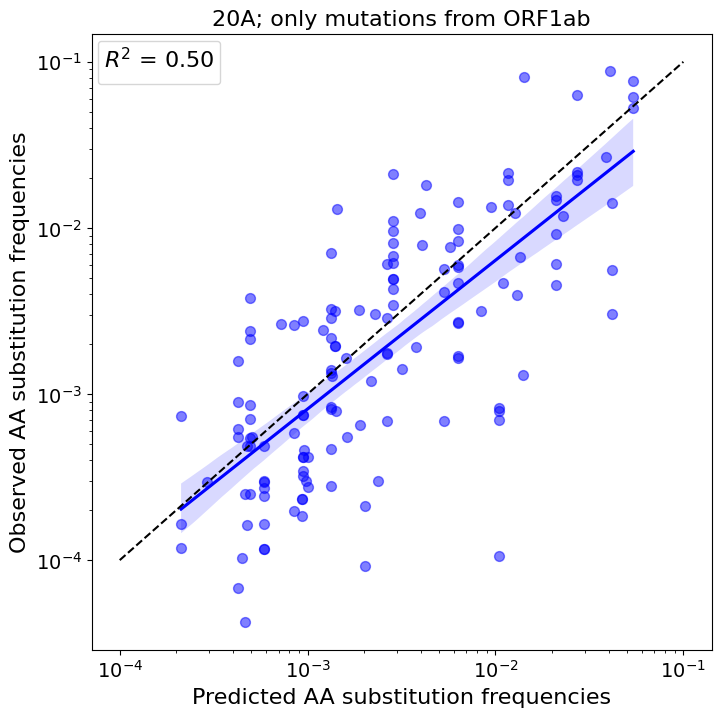

In [116]:
# _aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein == 'ORF1ab'], exp_aa_subst, aa_freqs_total_dct)
_aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein.str.contains('ORF1ab')], exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(_aa_subst, '20A; only mutations from ORF1ab', )

### separate on genes

In [74]:
metrics_data = []
for (cur_clade, cur_protein), cur_obs in obs.groupby(['clade', 'protein']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    cur_obs = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(
        cur_obs, cur_exp_aa_subst, 
        aa_freqs_df.loc[cur_protein].rename(index=amino_acid_codes).to_dict())

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data.append(cur_metrics)

metrics_data = pd.DataFrame(metrics_data)
metrics_data

r2      mape      wape     slope  intercept  spearman_corr  \
0    0.371716  1.039506  0.709010  0.307516   0.004617       0.529720   
1    0.156468  2.122364  0.844577  0.296904   0.004687       0.655262   
2    0.319434  1.678265  0.755365  0.408088   0.003946       0.602832   
3    0.504057  0.692208  0.547901  0.424706   0.003835       0.414974   
4    0.501862  2.527333  0.685590  0.574784   0.002835       0.757632   
..        ...       ...       ...       ...        ...            ...   
283  0.116197  0.764913  0.639325  0.340048   0.004400       0.243469   
284  0.478540  1.222643  0.632450  0.484856   0.003434       0.617064   
285  0.297095  0.691293  0.620002  0.356036   0.004293       0.209208   
286  0.530623  1.110309  0.598047  0.653937   0.002307       0.635189   
287  0.150795  1.666304  0.762340  0.640841   0.002394       0.634487   

       spearman_p  pearson_corr     pearson_p   ks_stat          ks_p  \
0    3.166222e-12      0.623422  1.592386e-17  0.593333  7.588478e-25   
1    9.251162e-20      0.448959  8.295369e-09  0.326667  1.756439e-07   
2    3.286698e-16      0.579013  8.399269e-15  0.206667  3.220729e-03   
3    1.292551e-07      0.722696  1.632055e-25  0.580000  1.105089e-23   
4    3.238773e-29      0.714193  1.069847e-24  0.146667  7.930977e-02   
..            ...           ...           ...       ...           ...   
283  2.680013e-03      0.452835  5.947207e-09  0.520000  7.237717e-19   
284  4.152354e-17      0.691824  1.102395e-22  0.226667  8.634332e-04   
285  1.018963e-02      0.552690  2.251787e-13  0.580000  1.105089e-23   
286  2.547006e-18      0.741746  1.852900e-27  0.233333  5.413960e-04   
287  2.847532e-18      0.602616  3.388835e-16  0.093333  5.321869e-01   

         rmse  log_likelihood  mut_count  mut_type_count clade       protein  
0    0.018092       -4.875340      543.0              61   20A             E  
1    0.015636       -5.405978     1073.0             101   20A             M  
2    0.013178       -5.353119     4340.0             126   20A             N  
3    0.013492       -4.906098      467.0              63   20A         ORF10  
4    0.009873       -5.320390    26469.0             146   20A  ORF1a;ORF1ab  
..        ...             ...        ...             ...   ...           ...  
283  0.014488       -5.756893      407.0              72   24A          ORF6  
284  0.011924       -5.249714     1919.0             116   24A         ORF7a  
285  0.015061       -5.386827      394.0              63   24A         ORF7b  
286  0.008993       -5.445576     1799.0             115   24A          ORF8  
287  0.010028       -5.784955    11659.0             144   24A             S  

[288 rows x 17 columns]

In [78]:
metrics_data[metrics_data.spearman_p > 0.01]

r2      mape      wape     slope  intercept  spearman_corr  \
45   0.241349  0.626607  0.594826  0.296657   0.004689       0.205689   
57   0.189879  0.653329  0.649206  0.284892   0.004767       0.194387   
117  0.108525  0.962338  0.675690  0.214224   0.005239       0.119850   
129  0.184216  1.153438  0.700139  0.161880   0.005587       0.190161   
141  0.240542  1.031087  0.657227  0.259991   0.004933       0.135938   
153  0.269015  0.795890  0.636552  0.323042   0.004513       0.199298   
165  0.191435  1.733517  0.695137  0.299920   0.004667       0.193816   
261  0.256966  0.682008  0.656970  0.311504   0.004590       0.194148   
285  0.297095  0.691293  0.620002  0.356036   0.004293       0.209208   

     spearman_p  pearson_corr     pearson_p   ks_stat          ks_p      rmse  \
45     0.011565      0.500040  7.270846e-11  0.633333  1.492014e-28  0.017015   
57     0.017144      0.462213  2.612716e-09  0.613333  1.170696e-26  0.017041   
117    0.144059      0.378743  1.760790e-06  0.400000  4.152393e-11  0.017604   
129    0.019763      0.433348  3.040381e-08  0.433333  4.995525e-13  0.027131   
141    0.097180      0.491829  1.642687e-10  0.426667  1.248881e-12  0.018148   
153    0.014483      0.526076  4.729783e-12  0.633333  1.492014e-28  0.015935   
165    0.017479      0.469310  1.378833e-09  0.440000  1.965832e-13  0.015686   
261    0.017283      0.514871  1.577403e-11  0.640000  3.335803e-29  0.015169   
285    0.010190      0.552690  2.251787e-13  0.580000  1.105089e-23  0.015061   

     log_likelihood  mut_count  mut_type_count clade protein  
45        -5.326839      243.0              55   20E   ORF7b  
57        -5.437292      374.0              58   20G   ORF7b  
117       -5.571660     5112.0              95   21J   ORF7b  
129       -5.042544     2814.0              89   21K   ORF7b  
141       -5.323133     2459.0              89   21L   ORF7b  
153       -5.431659      322.0              55   22A   ORF7b  
165       -5.509132     2619.0              86   22B   ORF7b  
261       -5.532737      232.0              54   23D   ORF7b  
285       -5.386827      394.0              63   24A   ORF7b

In [94]:
metrics_data['time_period'] = metrics_data['clade'].map(_clade2label)

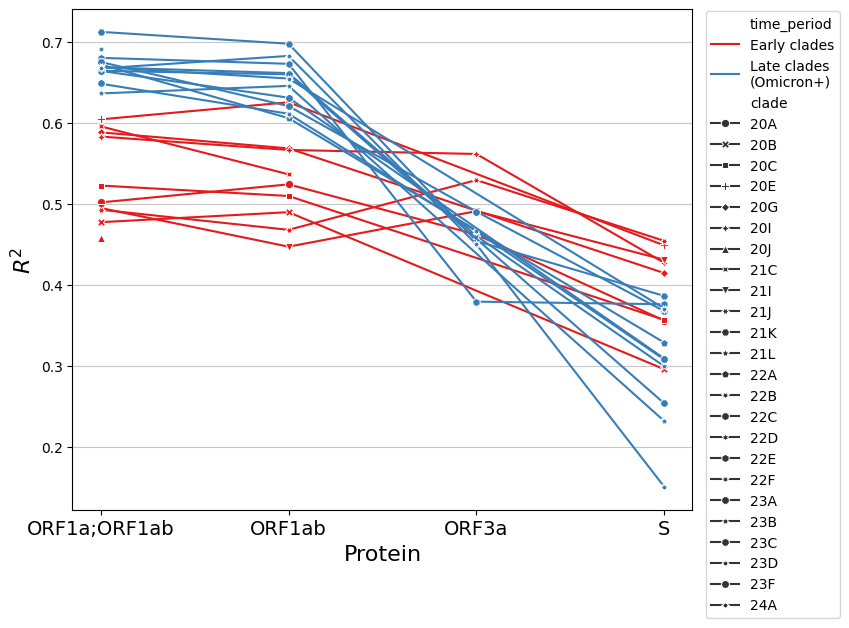

In [111]:
_ = metrics_data[metrics_data.protein.isin(['ORF3a', 'S', 'ORF1ab', 'ORF1a;ORF1ab'])].query('mut_count > 4000')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='r2', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()


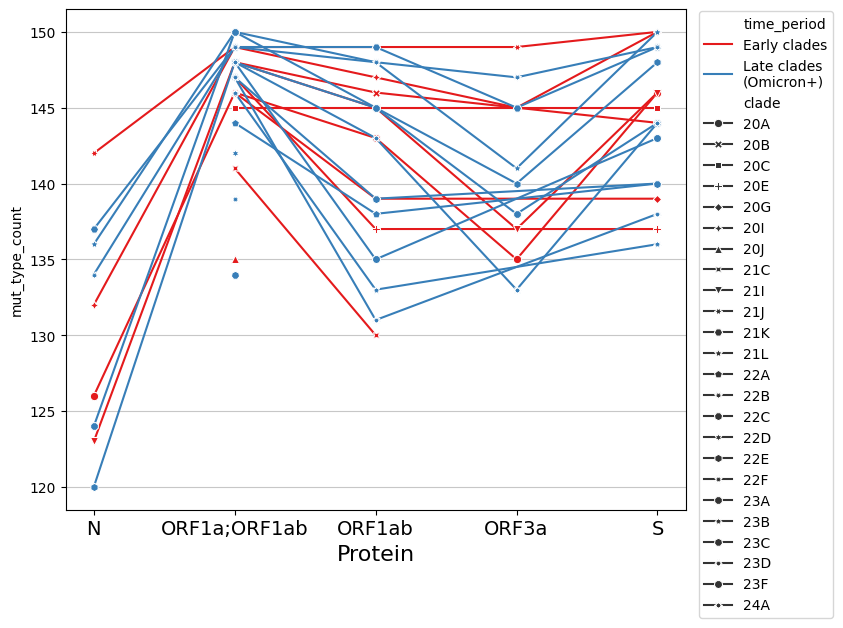

In [113]:
_ = metrics_data[metrics_data.protein.isin(['ORF3a', 'S', 'N', 'ORF1ab', 'ORF1a;ORF1ab'])].query('mut_count > 4000')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()


<Axes: xlabel='clade', ylabel='r2'>

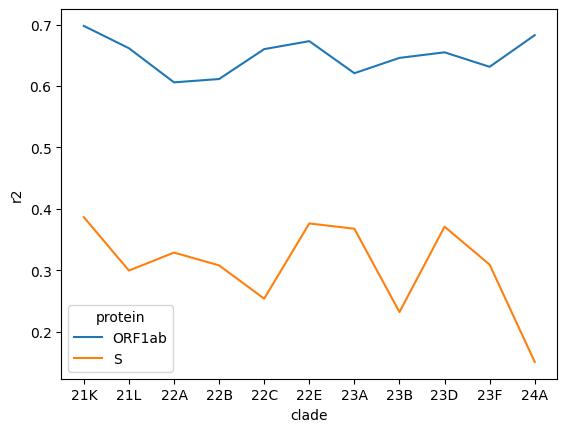

In [ ]:
# no significant tendensies
_ = metrics_data.query('(protein == "S" | protein == "ORF1ab") & mut_count > 4000 & time_period != "Early clades"')
sns.lineplot(_, x='clade', y='r2', hue='protein')

Text(0.5, 28.999999999999964, 'Mutations count in clade')

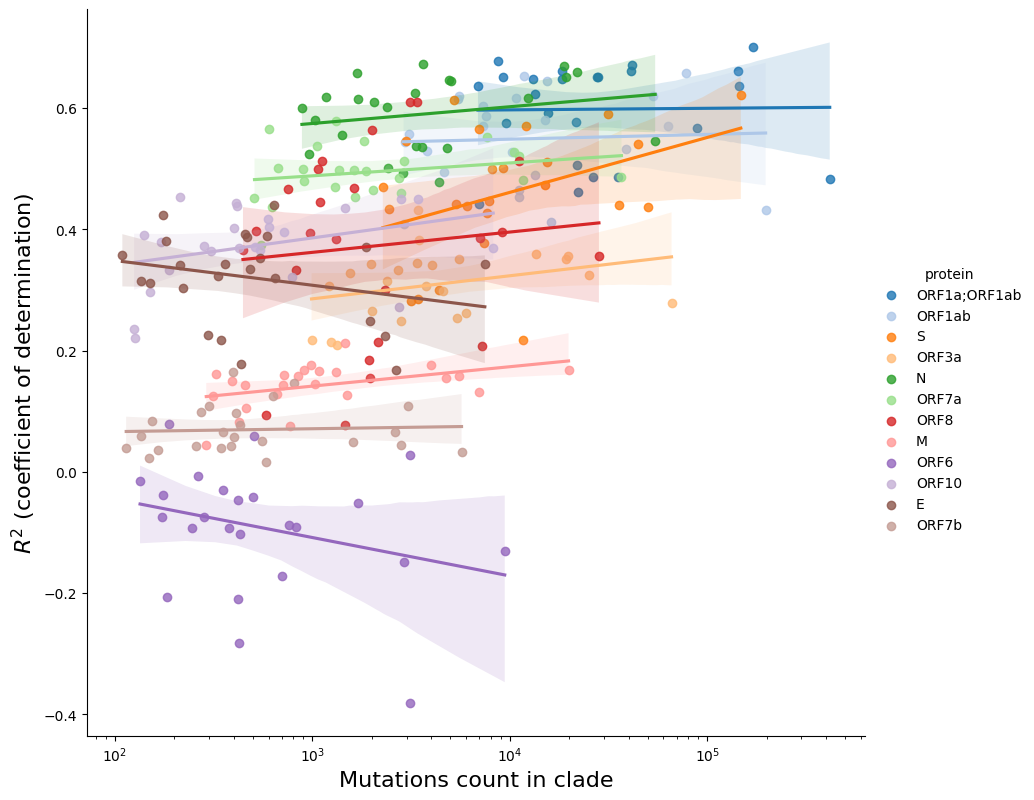

In [123]:
sns.lmplot(metrics_data_sized, y='r2', x='nmut', hue='protein', 
           hue_order=metrics_data_sized.groupby('protein')['nmut'].mean().sort_values(ascending=False).index,
           height=8, aspect=1.1, logx=True, palette='tab20')
plt.xscale('log')
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations count in clade', fontsize=16)

Text(0.5, 0, 'Gene')

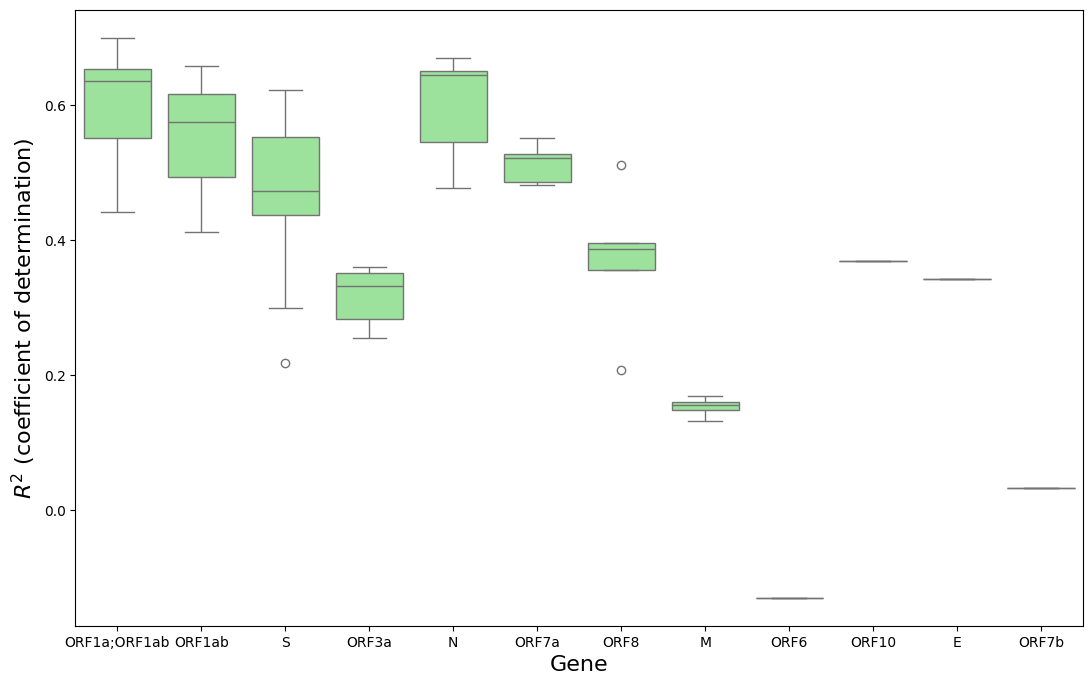

In [127]:
plt.figure(figsize=(13, 8))
sns.boxplot(metrics_data_sized.query('nmut > 4000'), x='protein', y='r2', color='lightgreen',
            # order=['ORF1a;ORF1ab', 'ORF1ab', 'S', 'ORF3a', 'M', 'N'],
            order=metrics_data_sized.groupby('protein')['nmut'].mean().sort_values(ascending=False).index,
)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Gene', fontsize=16)

### How many mutations required for unbiased resilt?

In [ ]:
sdata_full = []
for (cur_clade, ), obs_clade in obs.groupby(['clade']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    obs_clade = obs_clade[(obs_clade.aa1 != '*') & (obs_clade.aa2 != '*')]

    exploded = []
    for _, x in obs_clade[['aa1', 'aa2', 'count']].iterrows():
        for _ in range(x['count']):
            exploded.append(x)
    exploded = pd.DataFrame(exploded).reset_index(drop=True)
    exploded['count'] = 1

    sdata = []
    for n in np.logspace(2, np.log10(len(exploded)-10), 100).astype(int):
        cur_sample = exploded.sample(n, replace=False)
        _aa_subst = prepare_aa_subst(cur_sample, cur_exp_aa_subst, aa_freqs_total_dct)
        cor_res = spearmanr(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        r2 = r2_score(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        sdata.append([n, cor_res.correlation, r2])

    sdata = pd.DataFrame(sdata, columns=['n', 'cor', 'r2']).assign(clade=cur_clade)
    sdata_full.append(sdata)


sdata_full_df = pd.concat(sdata_full)
sdata_full_df

n       cor        r2 clade
0     100  0.472110  0.330910   20A
1     106  0.536463  0.389653   20A
2     113  0.481192  0.276265   20A
3     121  0.543176  0.485366   20A
4     129  0.473410  0.128456   20A
..    ...       ...       ...   ...
95  43245  0.786559  0.674945   22C
96  46098  0.792050  0.677014   22C
97  49140  0.789173  0.672573   22C
98  52382  0.792079  0.672765   22C
99  55838  0.792331  0.674705   22C

[1400 rows x 4 columns]

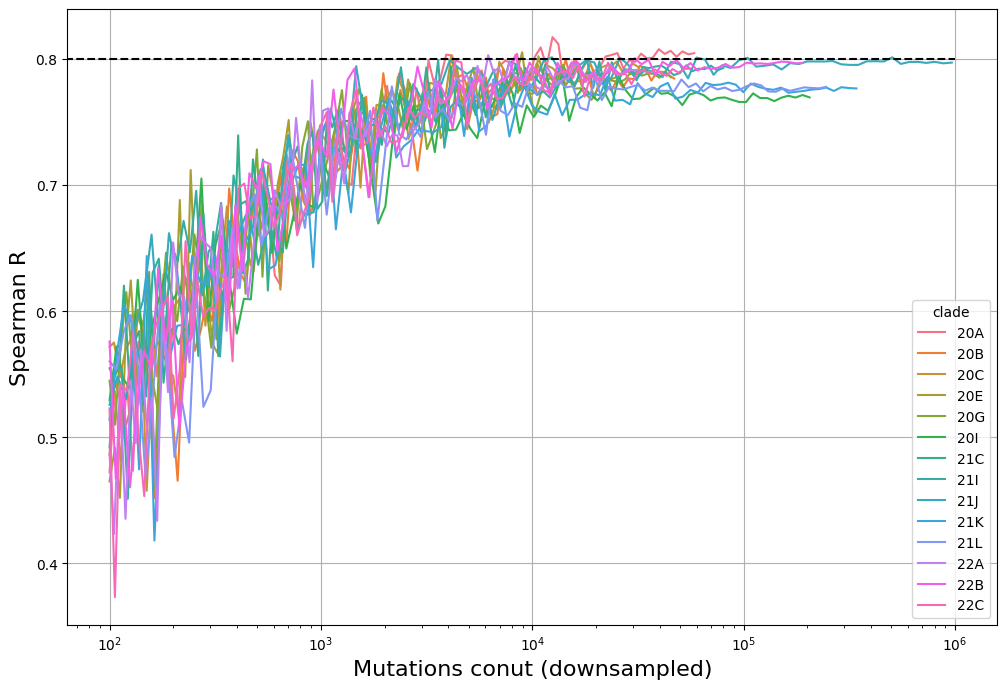

In [96]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='cor', hue='clade')
plt.hlines(0.8, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('Spearman R', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

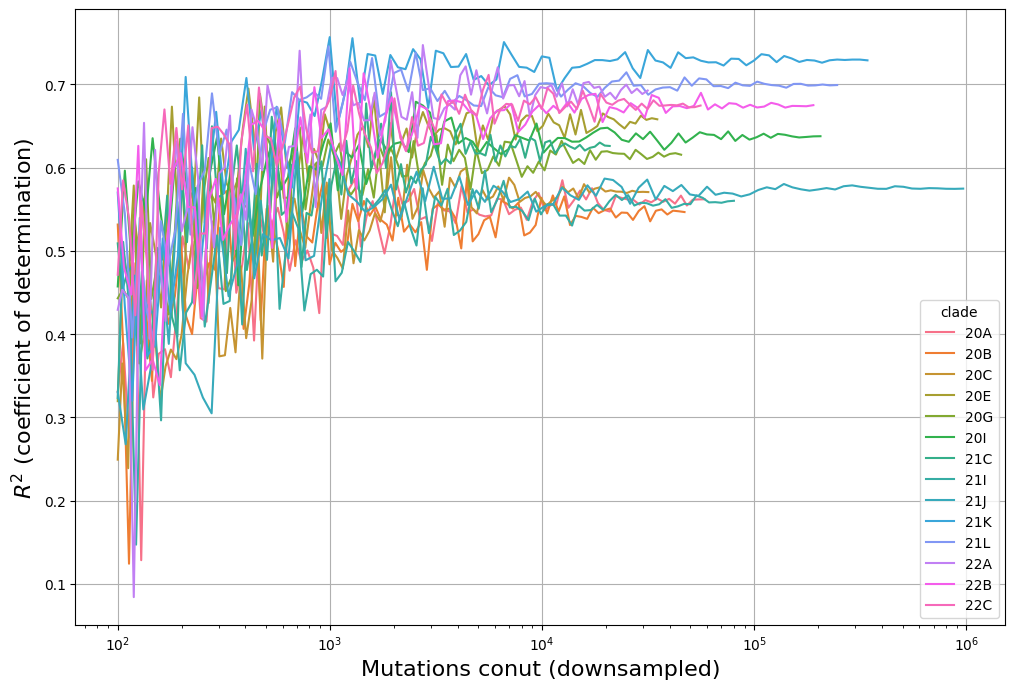

In [95]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='r2', hue='clade')
# plt.hlines(0.63, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

## Fitness

In [86]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')

spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()

spectrum_20A_dct = spectrum_20A.set_index('Mut').rate.to_dict()
_df_changes = collect_possible_changes(1, spectrum_20A_dct)

## Calculate expected AA substitutions matrix
exp_aa_subst = _df_changes[(_df_changes.aa1 != '*')&(_df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

In [85]:
aamut_fitness = pd.read_csv('./data/bloom_etal/aamut_fitness_by_clade.csv')
aamut_fitness['aa1'] = aamut_fitness['aa_mutation'].str[0]
aamut_fitness['aa2'] = aamut_fitness['aa_mutation'].str[-1]
aamut_fitness_ns = aamut_fitness.query('aa1 != aa2 & aa1 != "*" & aa2 != "*"')
aamut_fitness

clade  gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
0         20A     E                A         A       22        A22A   
1         20A     E                A         A       32        A32A   
2         20A     E                A         A       36        A36A   
3         20A     E                A         A       41        A41A   
4         20A     E                A         D       22        A22D   
...       ...   ...              ...       ...      ...         ...   
2893365   24A  nsp1                Y         F       97        Y97F   
2893366   24A  nsp1                Y         H       97        Y97H   
2893367   24A  nsp1                Y         N       97        Y97N   
2893368   24A  nsp1                Y         S       97        Y97S   
2893369   24A  nsp1                Y         Y       97        Y97Y   

         expected_count  actual_count  count_terminal  count_non_terminal  \
0               1.87400             2               0                   2   
1              14.74200            20              14                   6   
2              14.48000             1               0                   1   
3              14.48000             3               2                   1   
4               0.67725             0               0                   0   
...                 ...           ...             ...                 ...   
2893365         0.77908             0               0                   0   
2893366         2.17910             0               0                   0   
2893367         0.48805             0               0                   0   
2893368         0.20445             0               0                   0   
2893369        18.50500            27              20                   7   

         mean_log_size  subset_of_ORF1ab  delta_fitness aa1 aa2  
0              2.41010             False       0.051727   A   A  
1              0.41743             False       0.296350   A   A  
2              1.94590             False      -2.301200   A   A  
3              0.82833             False      -1.453900   A   A  
4              0.00000             False      -0.856330   A   D  
...                ...               ...            ...  ..  ..  
2893365        0.00000              True      -0.939290   Y   F  
2893366        0.00000              True      -1.678600   Y   H  
2893367        0.00000              True      -0.681130   Y   N  
2893368        0.00000              True      -0.342810   Y   S  
2893369        0.34553              True       0.369480   Y   Y  

[2893370 rows x 15 columns]

### Explore variability of sites according to delta fitneses of mutations in clades

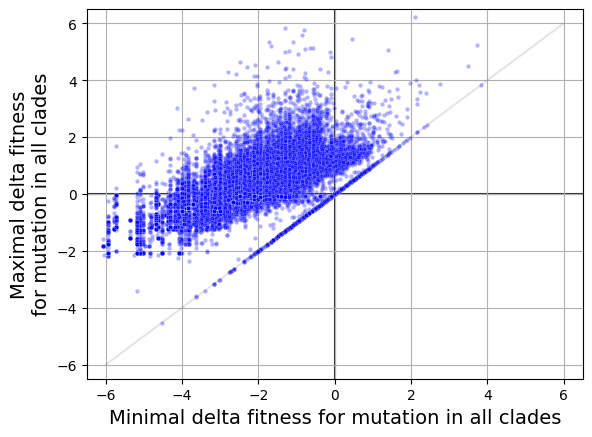

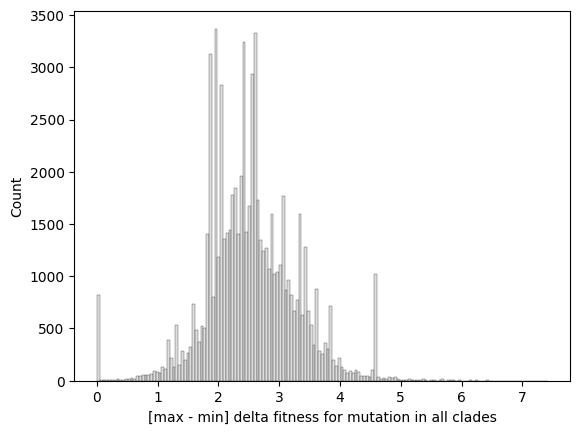

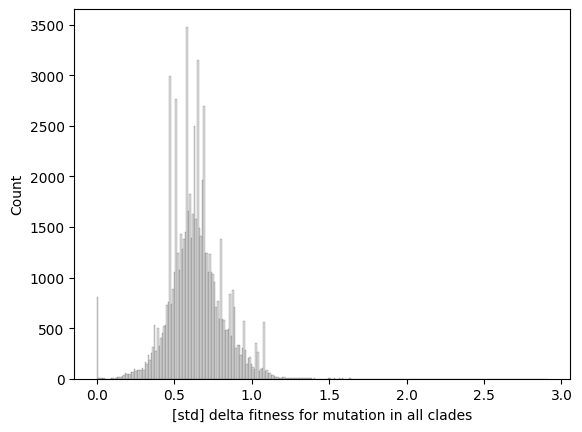

In [131]:
_ = aamut_fitness.query('subset_of_ORF1ab == False')\
    .groupby(['gene', 'aa_mutation'])['delta_fitness'].agg(['min', 'std', 'max'])
ax = sns.scatterplot(_, x='min', y='max', c='b', s=10, alpha=0.3)
plt.plot([-6, 6], [-6, 6], 'k-', alpha=0.1)
plt.ylabel('Maximal delta fitness\nfor mutation in all clades', fontsize=14)
plt.xlabel('Minimal delta fitness for mutation in all clades', fontsize=14)
plt.grid()
ax.set_axisbelow(True)
ax.vlines(0, -6.5, 6.5, 'k', zorder=0, alpha=0.8)
ax.hlines(0, -6.5, 6.5, 'k', zorder=0, alpha=0.8)
ax.set_xlim(-6.5, 6.5)
ax.set_ylim(-6.5, 6.5)
plt.show()

sns.histplot(_['max']-_['min'], color='lightgray')
plt.xlabel('[max - min] delta fitness for mutation in all clades');
plt.show()

sns.histplot(_['std'].fillna(0), color='lightgray')
plt.xlabel('[std] delta fitness for mutation in all clades');
plt.show()

In [16]:
(_['min'] - _['max']).between(-0.1, 0.1).sum()

np.int64(824)

In [132]:
_clades_df = aamut_fitness.query('subset_of_ORF1ab == False')\
    .pivot(index=['gene', 'aa_mutation'], columns='clade', values='delta_fitness')
_clades_df

clade                 20A      20B      20C      20E      20G       20I  \
gene aa_mutation                                                          
E    A11A             NaN      NaN      NaN      NaN      NaN       NaN   
     A11E             NaN      NaN      NaN      NaN      NaN       NaN   
     A11G             NaN      NaN      NaN      NaN      NaN       NaN   
     A11P             NaN      NaN      NaN      NaN      NaN       NaN   
     A11S             NaN      NaN      NaN      NaN      NaN       NaN   
...                   ...      ...      ...      ...      ...       ...   
S    Y91F        -0.67699 -0.59596 -0.55808 -0.41476 -0.59817 -1.343000   
     Y91H        -1.31310 -1.19430 -1.16770 -0.95033 -1.13110 -2.250500   
     Y91N        -0.46773 -0.39687 -0.45832 -0.32602 -0.41692 -1.106100   
     Y91S        -0.40684 -0.27338 -0.27589 -0.22215 -0.26856 -0.778240   
     Y91Y         0.29636  1.00290 -1.16770  0.14828  0.81483 -0.053288   

clade                  20J      21C      21I      21J  ...      22C      22D  \
gene aa_mutation                                       ...                     
E    A11A              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11E              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11G              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11P              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11S              NaN      NaN      NaN      NaN  ...      NaN      NaN   
...                    ...      ...      ...      ...  ...      ...      ...   
S    Y91F        -0.207840 -0.31746 -0.85084 -0.22744  ... -0.63677 -0.29653   
     Y91H        -0.503690 -0.68046 -1.55270 -1.44440  ... -1.49490 -0.94610   
     Y91N        -0.177560 -0.20449 -0.49139 -1.02800  ... -0.54343 -0.26218   
     Y91S        -0.086873 -0.13240 -0.46096 -2.11990  ... -0.28748 -0.13714   
     Y91Y         1.442200 -0.68046 -0.45409  0.77279  ... -0.39627 -0.94610   

clade                 22E       22F       23A       23B       23C       23D  \
gene aa_mutation                                                              
E    A11A             NaN  0.106410 -0.188840 -0.604870  0.122520 -0.566980   
     A11E             NaN -0.665130 -1.551500 -0.855930 -0.465520 -0.833460   
     A11G             NaN -0.065541 -0.392910 -0.161270 -0.068992 -0.120750   
     A11P             NaN -0.295890 -0.862870 -0.450640 -0.232560 -0.389470   
     A11S             NaN -1.449300 -1.715500 -0.858660 -0.054236 -0.313170   
...                   ...       ...       ...       ...       ...       ...   
S    Y91F        -1.02280 -0.366200  0.050248 -0.477600 -0.257520 -0.518400   
     Y91H        -1.99630 -0.893180 -2.029000 -1.189600 -0.810930 -1.116800   
     Y91N        -0.96149 -0.235060 -0.701530 -0.314140 -0.228380 -0.333800   
     Y91S        -0.48004 -0.166800 -0.538510 -0.219840 -0.094410 -0.237270   
     Y91Y         0.20089 -0.893180  0.368880 -0.090998 -0.810930 -0.018233   

clade                 23F      24A  
gene aa_mutation                    
E    A11A        -0.11870      NaN  
     A11E        -0.98173      NaN  
     A11G        -0.18764      NaN  
     A11P        -0.57308      NaN  
     A11S        -0.60149      NaN  
...                   ...      ...  
S    Y91F         0.42596  0.15932  
     Y91H        -1.40610 -0.58002  
     Y91N        -0.45437 -0.68113  
     Y91S        -0.30960 -0.34281  
     Y91Y        -0.30748 -0.58002  

[71476 rows x 24 columns]

In [34]:
_d = []
for _, x in _clades_df.iterrows():
    _d.append([x.argmin() < 10, x.argmax() < 10])

In [35]:
pd.DataFrame(_d)[0].value_counts()

0
True     36705
False    34771
Name: count, dtype: int64

In [36]:
pd.DataFrame(_d)[1].value_counts()

1
True     38614
False    32862
Name: count, dtype: int64

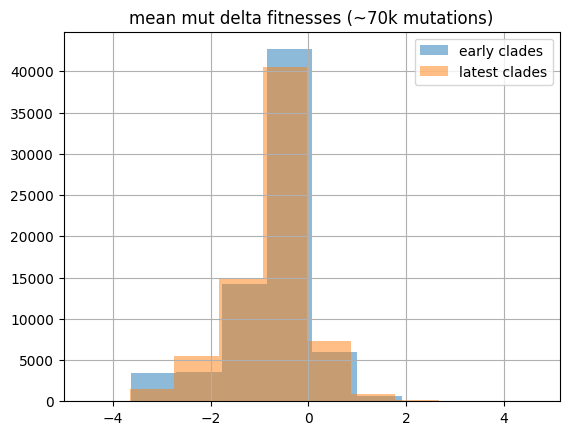

In [12]:
_clades_df.iloc[:, :10].mean(axis=1).hist(alpha=0.5, label='early clades')
_clades_df.iloc[:, 10:].mean(axis=1).hist(alpha=0.5, label='latest clades')
plt.title('mean mut delta fitnesses (~70k mutations)')
plt.legend()

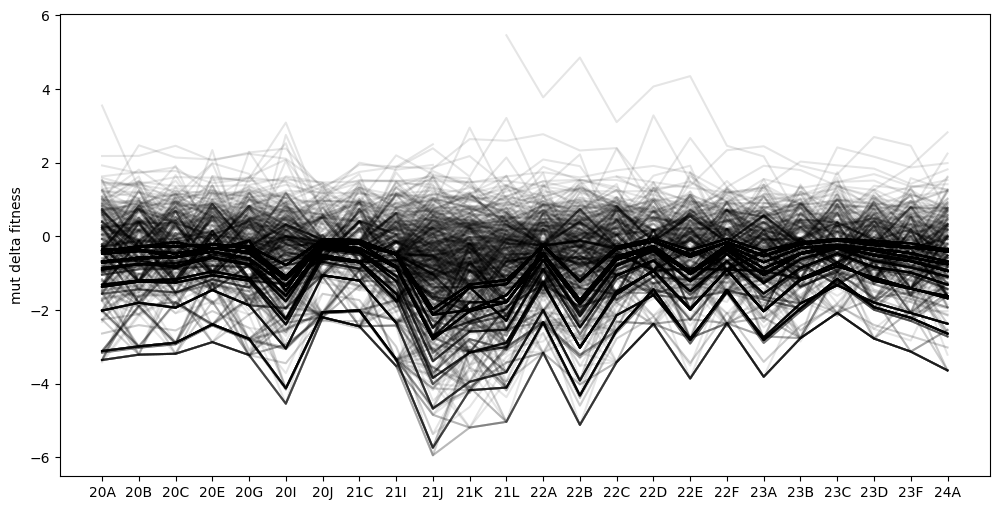

In [15]:
plt.figure(figsize=(12, 6))

plt.ylabel('mut delta fitness')
for _, x in _clades_df.sample(1000, replace=False).iterrows():
    plt.plot(x, color='k', alpha=0.1)

/tmp/ipykernel_18619/3172822004.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(_clades_df.iloc[random.randint(0, len(_clades_df-1))].values, alpha=.5)
/tmp/ipykernel_18619/3172822004.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='100 random mutations', fontsize=14)


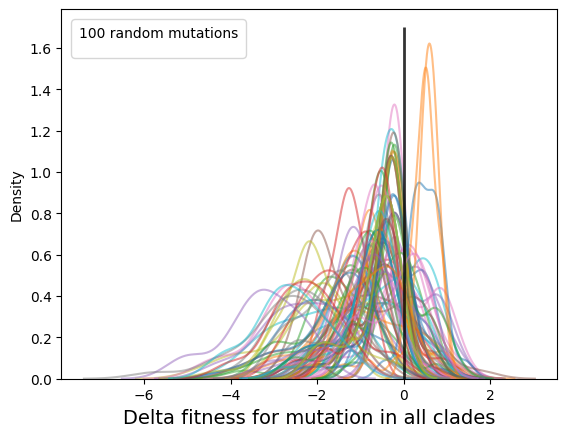

In [146]:
import random

for i in range(100):
    ax = sns.kdeplot(_clades_df.iloc[random.randint(0, len(_clades_df-1))].values, alpha=.5)

ax.vlines(0, 0, ax.get_ylim()[1], 'k', alpha=0.8, linewidth=2)

plt.xlabel('Delta fitness for mutation in all clades', fontsize=14)
plt.legend(title='100 random mutations', fontsize=14)

### asses model

In [10]:
aamut_fitness_ns.query('clade == "20A" & actual_count > 0 & delta_fitness < -0.5').actual_count.sum()

np.int64(17931)

In [178]:
aamut_fitness_ns.query('clade == "20A" & actual_count > 0 & delta_fitness < -3').actual_count.sum()

np.int64(0)

In [15]:
_ = aamut_fitness_ns.query('clade == "20A"').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.5571396185380777,
 'mape': 1.1285503867346027,
 'wape': 0.5932348835165893,
 'slope': np.float64(0.6508893250061314),
 'intercept': np.float64(0.0023274044999591257),
 'spearman_corr': np.float64(0.8080992321311243),
 'spearman_p': np.float64(7.748360438253803e-36),
 'pearson_corr': np.float64(0.7542828798404577),
 'pearson_p': np.float64(7.797716793332376e-29),
 'ks_stat': np.float64(0.09333333333333334),
 'ks_p': np.float64(0.5321869291503776),
 'rmse': 0.008682511183942553,
 'log_likelihood': np.float64(-5.312263944817579),
 'mut_count': np.float64(103442.0)}

In [16]:
_ = aamut_fitness_ns.query('clade == "20A" & delta_fitness > 0.5').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.4537066880658286,
 'mape': 1.8206559931265052,
 'wape': 0.7323862833385576,
 'slope': np.float64(0.5755782433937899),
 'intercept': np.float64(0.002829478377374734),
 'spearman_corr': np.float64(0.6062932678492836),
 'spearman_p': np.float64(2.0061966111100683e-16),
 'pearson_corr': np.float64(0.6892041641785387),
 'pearson_p': np.float64(1.8459779441776772e-22),
 'ks_stat': np.float64(0.10666666666666667),
 'ks_p': np.float64(0.3617268879273219),
 'rmse': 0.00996417393637113,
 'log_likelihood': np.float64(-5.48805419531443),
 'mut_count': np.float64(48153.0)}

In [18]:
# aamut_fitness_ns[aamut_fitness_ns.delta_fitness < -5]
aamut_fitness_ns.query('actual_count > 0 & 3 < delta_fitness < 5')#.actual_count.sum()

clade          gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
482       20A             E                V         L       75        V75L   
4121      20A             N                Q         K        7         Q7K   
5846      20A        ORF1ab                A         D     1708      A1708D   
18216     20A        ORF1ab                F         V      536       F536V   
27916     20A        ORF1ab                K         R     3353      K3353R   
...       ...           ...              ...       ...      ...         ...   
2871314   20C  nsp12 (RdRp)                Y         F      719       Y719F   
2881956   22B         nsp14                Y         D       69        Y69D   
2881972   22D         nsp14                Y         D       69        Y69D   
2881988   22F         nsp14                Y         D       69        Y69D   
2882020   23D         nsp14                Y         D       69        Y69D   

         expected_count  actual_count  count_terminal  count_non_terminal  \
482            0.516610            40              37                   3   
4121           0.677250            29              18                  11   
5846           0.677250            28              11                  17   
18216          0.216990            21              17                   4   
27916          1.463400           151              88                  63   
...                 ...           ...             ...                 ...   
2871314        0.373660            63              30                  33   
2881956        1.171200            39              32                   7   
2881972        0.073537            27              14                  13   
2881988        0.082864            43              34                   9   
2882020        0.106320            49              36                  13   

         mean_log_size  subset_of_ORF1ab  delta_fitness aa1 aa2  
482            0.11304             False         3.6848   V   L  
4121           0.57479             False         3.2212   Q   K  
5846           0.99626             False         3.1867   A   D  
18216          0.17064             False         3.4007   F   V  
27916          0.71918             False         4.3459   K   R  
...                ...               ...            ...  ..  ..  
2871314        0.55822              True         4.2861   Y   F  
2881956        0.21734              True         3.1628   Y   D  
2881972        0.43757              True         3.8701   Y   D  
2881988        0.28278              True         4.3126   Y   D  
2882020        0.30845              True         4.4023   Y   D  

[633 rows x 15 columns]

In [20]:
print('delta fitness')
print('interval      r2')
# for mi,ma in zip([-5.] + np.linspace(-3, 5, 11).tolist(), np.linspace(-3, 5, 11).tolist() + [7.]):
# for mi,ma in zip([-2., -1, 0, 1, 2], [ -1, 0, 1, 2, 3]):
for mi,ma in zip(np.linspace(-2, 3, 11).tolist(), (np.linspace(-2, 3, 11)+0.5).tolist()):
    _ = aamut_fitness_ns.query(f'clade == "20A" & actual_count > 0 & {mi} < delta_fitness < {ma}').rename(columns={'actual_count': 'count'})
    if _['count'].sum() < 1000:
        continue
    aas = prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct)
    if aas.nobs.eq(0).sum() > 80:
        continue
    cur_metrics = calc_metrics(aas)
    print(f"[{mi:.1f}, {ma:.1f}]: {cur_metrics['r2']:.2f}")


delta fitness
interval      r2
[-0.5, 0.0]: 0.43
[0.0, 0.5]: 0.39
[0.5, 1.0]: 0.51
[1.0, 1.5]: 0.40
[1.5, 2.0]: 0.02


In [23]:
_ = aamut_fitness_ns.query(f'clade == "20A" & actual_count > 0 & delta_fitness < 0.05').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.6290406261831337,
 'mape': 1.1257841328191907,
 'wape': 0.5047612170626584,
 'slope': np.float64(0.6170719383798665),
 'intercept': np.float64(0.002552853744134223),
 'spearman_corr': np.float64(0.8821228225555824),
 'spearman_p': np.float64(3.016295431689523e-50),
 'pearson_corr': np.float64(0.7932700434241261),
 'pearson_p': np.float64(1.0582760406129611e-33),
 'ks_stat': np.float64(0.5266666666666666),
 'ks_p': np.float64(2.2756141085163098e-19),
 'rmse': 0.008815222261343516,
 'log_likelihood': np.float64(-4.97358585392162),
 'mut_count': np.float64(34856.999999999985)}

In [33]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [39]:
aamut_fitness_ns.query('clade == "21J" & not subset_of_ORF1ab')

clade gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
630824   21J    E                A         D       22        A22D   
630825   21J    E                A         D       32        A32D   
630826   21J    E                A         E       36        A36E   
630827   21J    E                A         E       41        A41E   
630828   21J    E                A         G       22        A22G   
...      ...  ...              ...       ...      ...         ...   
700772   21J    S                Y         S      837       Y837S   
700773   21J    S                Y         S      873       Y873S   
700774   21J    S                Y         S      904       Y904S   
700775   21J    S                Y         S       91        Y91S   
700776   21J    S                Y         S      917       Y917S   

        expected_count  actual_count  count_terminal  count_non_terminal  \
630824         14.3280             0               0                   0   
630825         14.3280             0               0                   0   
630826         14.3280             0               0                   0   
630827         14.3280             0               0                   0   
630828          5.4762             0               0                   0   
...                ...           ...             ...                 ...   
700772          3.6650             0               0                   0   
700773          3.6650             0               0                   0   
700774          3.6650             3               2                   1   
700775          3.6650             0               0                   0   
700776          3.6650             0               0                   0   

        mean_log_size  subset_of_ORF1ab  delta_fitness aa1 aa2  
630824        0.00000             False       -3.38970   A   D  
630825        0.00000             False       -3.38970   A   D  
630826        0.00000             False       -3.38970   A   E  
630827        0.00000             False       -3.38970   A   E  
630828        0.00000             False       -2.48090   A   G  
...               ...               ...            ...  ..  ..  
700772        0.00000             False       -2.11990   Y   S  
700773        0.00000             False       -2.11990   Y   S  
700774        0.23105             False       -0.17395   Y   S  
700775        0.00000             False       -2.11990   Y   S  
700776        0.00000             False       -2.11990   Y   S  

[57484 rows x 15 columns]

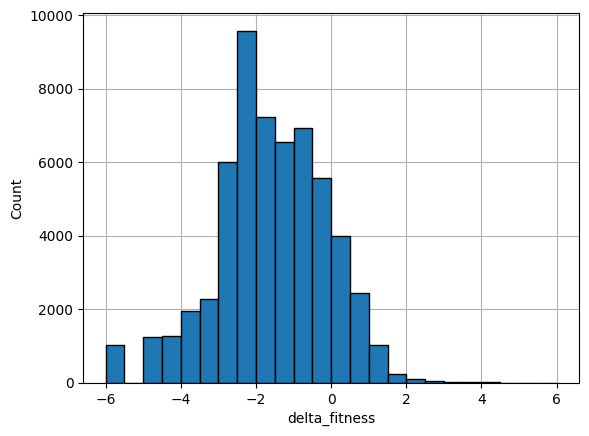

In [45]:
ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == "21J" & not subset_of_ORF1ab'), 
    # weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False, element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1
)
plt.grid()
ax.set_axisbelow(True)

In [55]:
ax.get_yticks()[-1]

np.float64(250000.0)

Text(0, 0.5, 'observed mutations density')

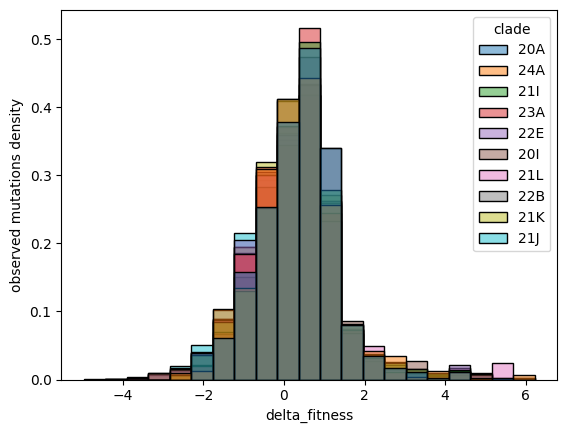

In [91]:
sns.histplot(
    aamut_fitness_ns.query('actual_count > 0'), 
    weights='actual_count', 
    x='delta_fitness', 
    hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    stat="density", common_norm=False, 
    # element="step", 
    bins=21,
)
plt.ylabel('observed mutations density')

<Axes: xlabel='delta_fitness', ylabel='Density'>

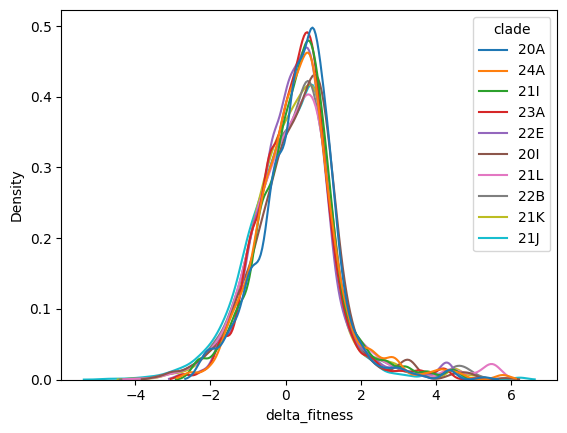

In [38]:
sns.kdeplot(aamut_fitness_ns.query('actual_count > 0'), 
             weights='actual_count', x='delta_fitness', common_norm=False,
             hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index)

### image for paper

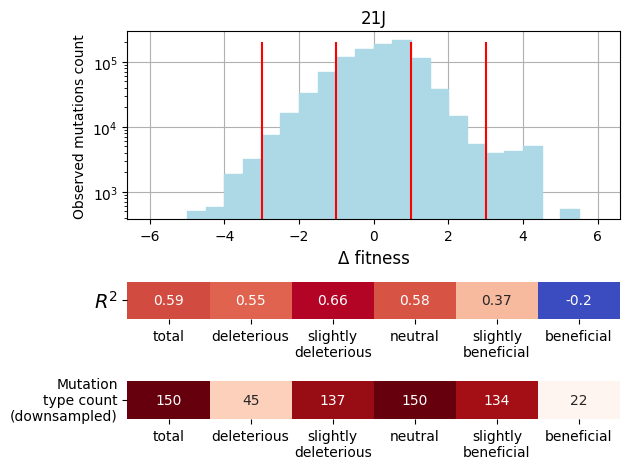

In [31]:
# clade = '24A'
clade = '21J'
downsample = False


spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_dct)
exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

aamut_fitness_ns_clade = aamut_fitness_ns.query(
    'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
    .rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(aamut_fitness_ns_clade, exp_aa_subst_cur, aa_freqs_total_dct)
cur_met = calc_metrics(aas)
corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
mut_type_cnt = aas.nobs.ne(0).sum()
mut_cnt = aas.nobs.sum()

_data = []
_data.append(['total', cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

# aa_muts_for_down = aamut_fitness_ns_clade[['aa1', 'aa2']]\
# aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness < -3')[['aa1', 'aa2']]\
    .drop_duplicates().reset_index(drop=True)

for (b1, b2), label in zip(
    [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
    ['deleterious', 'slightly deleterious', 'neutral', 'slightly beneficial', 'beneficial']
    ):
    cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]

    if downsample:
        print('INFO: downsampling mutations for', label)
        cur_mut_down = cur_mut.merge(aa_muts_for_down)
        nmut = cur_mut['count'].sum()
        print(nmut, len(cur_mut_down))
        if nmut <= 500:
            print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        # elif nmut > 6110:
        elif len(cur_mut_down) > 10:
            cur_mut = cur_mut_down
        else:
            print(f'INFO: low number of {label} mutations')

    aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
    mut_type_cnt = aas.nobs.ne(0).sum()
    mut_cnt = aas.nobs.sum()
    _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

df_df_res = pd.DataFrame(
    _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt']
)#.assign(clade=clade)

df_df_res_for_plot = df_df_res.copy()
df_df_res_for_plot['mut_sample'] = df_df_res_for_plot['mut_sample'].str.replace(' ', '\n')

fig, axs = plt.subplots(3, 1, height_ratios=[5, 1, 1])

ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == @clade & not subset_of_ORF1ab'), 
    weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False,
    element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1, color='lightblue', ax=axs[0]
)
axs[0].grid()
axs[0].set_title(clade)
axs[0].vlines([-3, -1, 1, 3], 0, axs[0].get_yticks()[-2], 'red', linewidth=1.5)
axs[0].set_ylabel('Observed mutations count')
axs[0].set_xlabel('Δ fitness', fontsize=12)
axs[0].set_axisbelow(True)
axs[0].set_yscale('log')

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['r2']].T, ax=axs[1],
            cmap='coolwarm', annot=True, cbar=False)
axs[1].set_xlabel('')
axs[1].set_yticklabels(['$R^2$'], rotation=0, fontsize=14)

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['mut_type_cnt']].T, ax=axs[2],
            cmap='Reds', annot=True, cbar=False, fmt='.0f', )
axs[2].set_xlabel('')
axs[2].set_yticklabels(['Mutation\ntype count\n(downsampled)'], rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(f'./figures/delta_fitness_res_{clade}.pdf')
plt.show()

In [61]:
downsample = False
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_df_df_res = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print('Processing clade:', clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    aamut_fitness_ns_clade = aamut_fitness_ns.query(
        'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
        .rename(columns={'actual_count': 'count'})
    aas = prepare_aa_subst(aamut_fitness_ns_clade, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
    mut_type_cnt = aas.nobs.ne(0).sum()
    mut_cnt = aas.nobs.sum()

    _data = []
    _data.append(['total', cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

    # aa_muts_for_down = aamut_fitness_ns_clade[['aa1', 'aa2']]\
    # aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
    aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness < -3')[['aa1', 'aa2']]\
        .drop_duplicates().reset_index(drop=True)

    for (b1, b2), label in zip(
        [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
        ['deleterious (df< -3)', 'slightly deleterious (-3<df< -1)', 'neutral (-1<df< 1)', 'slightly beneficial (1<df<3)', 'beneficial (df> 3)']
        ):
        cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]

        if downsample:
            print('INFO: downsampling mutations for', label)
            cur_mut_down = cur_mut.merge(aa_muts_for_down)
            nmut = cur_mut['count'].sum()
            print(nmut, len(cur_mut_down))
            if nmut <= 500:
                print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
                _data.append([label, np.nan, np.nan, np.nan, np.nan])
                continue
            # elif nmut > 6110:
            elif len(cur_mut_down) > 10:
                cur_mut = cur_mut_down
            else:
                print(f'INFO: low number of {label} mutations')

        aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
        if len(cur_mut) == 0:
            print(f'WARNING: no {label} mutations in clade {clade} --> skip')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        cur_met = calc_metrics(aas)
        corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
        mut_type_cnt = aas.nobs.ne(0).sum()
        mut_cnt = aas.nobs.sum()
        _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

    df_df_res = pd.DataFrame(
        _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt']
    )#.assign(clade=clade)

    df_df_res_for_plot = df_df_res.copy()
    # df_df_res_for_plot['mut_sample'] = df_df_res_for_plot['mut_sample'].str.replace(' ', '\n')
    clades_df_df_res.append(df_df_res_for_plot.assign(clade=clade))

clades_df_df_res = pd.concat(clades_df_df_res)
clades_df_df_res

Processing clade: 20A
Processing clade: 24A
Processing clade: 21I
Processing clade: 23A
Processing clade: 22E
Processing clade: 20I
Processing clade: 21L
Processing clade: 22B
Processing clade: 21K
Processing clade: 21J


mut_sample        r2  spearman_corr    mut_cnt  \
0                             total  0.581612       0.808787    64565.0   
1              deleterious (df< -3)       NaN            NaN        NaN   
2  slightly deleterious (-3<df< -1)  0.643202       0.700119     4695.0   
3                neutral (-1<df< 1)  0.576150       0.825675    44193.0   
4      slightly beneficial (1<df<3)  0.331983       0.593864    14654.0   
5                beneficial (df> 3) -0.205581            NaN     1023.0   
0                             total  0.680060       0.768997    66438.0   
1              deleterious (df< -3)       NaN            NaN        NaN   
2  slightly deleterious (-3<df< -1)  0.703351       0.785857     5604.0   
3                neutral (-1<df< 1)  0.723261       0.809538    45523.0   
4      slightly beneficial (1<df<3)  0.162358       0.449375    13719.0   
5                beneficial (df> 3) -0.186571            NaN     1592.0   
0                             total  0.578061       0.802593    82721.0   
1              deleterious (df< -3)       NaN            NaN        NaN   
2  slightly deleterious (-3<df< -1)  0.651399       0.789641     6595.0   
3                neutral (-1<df< 1)  0.558716       0.826582    58216.0   
4      slightly beneficial (1<df<3)  0.407450       0.508768    16416.0   
5                beneficial (df> 3) -0.035174            NaN     1494.0   
0                             total  0.681454       0.793634    94156.0   
1              deleterious (df< -3)       NaN            NaN        NaN   
2  slightly deleterious (-3<df< -1)  0.666846       0.779652     6702.0   
3                neutral (-1<df< 1)  0.724836       0.838503    68590.0   
4      slightly beneficial (1<df<3)  0.075635       0.413541    16909.0   
5                beneficial (df> 3) -0.153304            NaN     1955.0   
0                             total  0.697834       0.785049    93699.0   
1              deleterious (df< -3)       NaN            NaN        NaN   
2  slightly deleterious (-3<df< -1)  0.730040       0.783284     7441.0   
3                neutral (-1<df< 1)  0.734271       0.823509    67948.0   
4      slightly beneficial (1<df<3)  0.134076       0.456287    16441.0   
5                beneficial (df> 3) -0.249163            NaN     1869.0   
0                             total  0.649297       0.771962   210994.0   
1              deleterious (df< -3)  0.461608       0.674910      935.0   
2  slightly deleterious (-3<df< -1)  0.729925       0.881979    20783.0   
3                neutral (-1<df< 1)  0.623700       0.795849   137396.0   
4      slightly beneficial (1<df<3)  0.490984       0.484980    46709.0   
5                beneficial (df> 3) -0.139371            NaN     5171.0   
0                             total  0.697461       0.745816   308900.0   
1              deleterious (df< -3)  0.623614       0.640166     1394.0   
2  slightly deleterious (-3<df< -1)  0.762309       0.883300    31934.0   
3                neutral (-1<df< 1)  0.705513       0.775744   205171.0   
4      slightly beneficial (1<df<3)  0.466856       0.482387    60104.0   
5                beneficial (df> 3) -0.295128            NaN    10297.0   
0                             total  0.675170       0.786350   338783.0   
1              deleterious (df< -3)  0.644807       0.646831     1234.0   
2  slightly deleterious (-3<df< -1)  0.724623       0.898172    37855.0   
3                neutral (-1<df< 1)  0.685952       0.801694   225541.0   
4      slightly beneficial (1<df<3)  0.411590       0.512638    65175.0   
5                beneficial (df> 3) -0.311369            NaN     8978.0   
0                             total  0.730217       0.778984   383531.0   
1              deleterious (df< -3)  0.627199       0.632609     1385.0   
2  slightly deleterious (-3<df< -1)  0.719361       0.895811    39853.0   
3                neutral (-1<df< 1)  0.739361       0.801203   265502.0   
4      slightly beneficial (1<df<3)  0.403676     

In [66]:
print('R2')
clades_df_df_res.pivot(index=['clade'], columns='mut_sample', values='r2').round(2).iloc[:, [1, 4, 2, 3, 0, 5]]

R2


mut_sample  deleterious (df< -3)  slightly deleterious (-3<df< -1)  \
clade                                                                
20A                          NaN                              0.64   
20I                         0.46                              0.73   
21I                          NaN                              0.65   
21J                         0.55                              0.66   
21K                         0.63                              0.72   
21L                         0.62                              0.76   
22B                         0.64                              0.72   
22E                          NaN                              0.73   
23A                          NaN                              0.67   
24A                          NaN                              0.70   

mut_sample  neutral (-1<df< 1)  slightly beneficial (1<df<3)  \
clade                                                          
20A                       0.58                          0.33   
20I                       0.62                          0.49   
21I                       0.56                          0.41   
21J                       0.58                          0.37   
21K                       0.74                          0.40   
21L                       0.71                          0.47   
22B                       0.69                          0.41   
22E                       0.73                          0.13   
23A                       0.72                          0.08   
24A                       0.72                          0.16   

mut_sample  beneficial (df> 3)  total  
clade                                  
20A                      -0.21   0.58  
20I                      -0.14   0.65  
21I                      -0.04   0.58  
21J                      -0.20   0.59  
21K                      -0.27   0.73  
21L                      -0.30   0.70  
22B                      -0.31   0.68  
22E                      -0.25   0.70  
23A                      -0.15   0.68  
24A                      -0.19   0.68

In [67]:
print('mut_type_cnt')
clades_df_df_res.pivot(index=['clade'], columns='mut_sample', values='mut_type_cnt').round(2).iloc[:, [1, 4, 2, 3, 0, 5]]

mut_type_cnt


mut_sample  deleterious (df< -3)  slightly deleterious (-3<df< -1)  \
clade                                                                
20A                          NaN                              31.0   
20I                         29.0                              74.0   
21I                          NaN                              44.0   
21J                         45.0                             137.0   
21K                         30.0                              90.0   
21L                         30.0                             100.0   
22B                         30.0                              90.0   
22E                          NaN                              46.0   
23A                          NaN                              46.0   
24A                          NaN                              45.0   

mut_sample  neutral (-1<df< 1)  slightly beneficial (1<df<3)  \
clade                                                          
20A                      149.0                         136.0   
20I                      150.0                         135.0   
21I                      149.0                         139.0   
21J                      150.0                         134.0   
21K                      150.0                         138.0   
21L                      150.0                         138.0   
22B                      150.0                         134.0   
22E                      150.0                         139.0   
23A                      150.0                         137.0   
24A                      150.0                         137.0   

mut_sample  beneficial (df> 3)  total  
clade                                  
20A                       19.0  149.0  
20I                       23.0  150.0  
21I                       10.0  149.0  
21J                       22.0  150.0  
21K                       28.0  150.0  
21L                       30.0  150.0  
22B                       31.0  150.0  
22E                       21.0  150.0  
23A                       17.0  150.0  
24A                       16.0  150.0

In [69]:
print('mut_cnt')
clades_df_df_res.pivot(index=['clade'], columns='mut_sample', values='mut_cnt').round(2).iloc[:, [1, 4, 2, 3, 0, 5]]

mut_cnt


mut_sample  deleterious (df< -3)  slightly deleterious (-3<df< -1)  \
clade                                                                
20A                          NaN                            4695.0   
20I                        935.0                           20783.0   
21I                          NaN                            6595.0   
21J                       6109.0                          127374.0   
21K                       1385.0                           39853.0   
21L                       1394.0                           31934.0   
22B                       1234.0                           37855.0   
22E                          NaN                            7441.0   
23A                          NaN                            6702.0   
24A                          NaN                            5604.0   

mut_sample  neutral (-1<df< 1)  slightly beneficial (1<df<3)  \
clade                                                          
20A                    44193.0                       14654.0   
20I                   137396.0                       46709.0   
21I                    58216.0                       16416.0   
21J                   676682.0                      175143.0   
21K                   265502.0                       68751.0   
21L                   205171.0                       60104.0   
22B                   225541.0                       65175.0   
22E                    67948.0                       16441.0   
23A                    68590.0                       16909.0   
24A                    45523.0                       13719.0   

mut_sample  beneficial (df> 3)      total  
clade                                      
20A                     1023.0    64565.0  
20I                     5171.0   210994.0  
21I                     1494.0    82721.0  
21J                    15893.0  1001201.0  
21K                     8040.0   383531.0  
21L                    10297.0   308900.0  
22B                     8978.0   338783.0  
22E                     1869.0    93699.0  
23A                     1955.0    94156.0  
24A                     1592.0    66438.0

6109 2102
127374 5276
676682 5068
175143 257
15893 2
INFO: low number of beneficial mutations


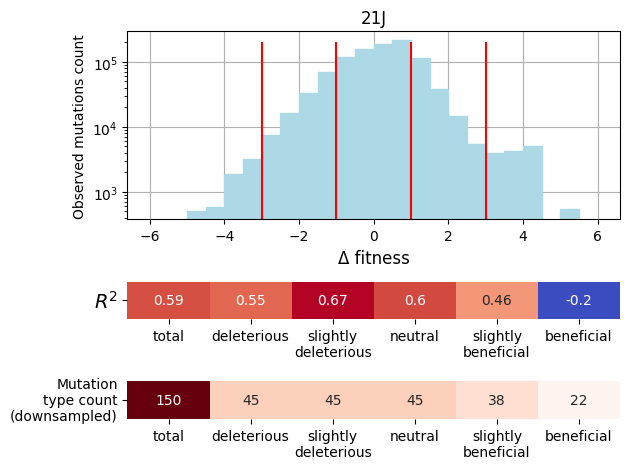

In [ ]:
# clade = '24A'
clade = '21J'

spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_dct)
exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

aamut_fitness_ns_clade = aamut_fitness_ns.query(
    'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
    .rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(aamut_fitness_ns_clade, exp_aa_subst_cur, aa_freqs_total_dct)
cur_met = calc_metrics(aas)
corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
mut_type_cnt = aas.nobs.ne(0).sum()
mut_cnt = aas.nobs.sum()

_data = []
_data.append(['total', cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

# aa_muts_for_down = aamut_fitness_ns_clade[['aa1', 'aa2']]\
# aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness < -3')[['aa1', 'aa2']]\
    .drop_duplicates().reset_index(drop=True)

for (b1, b2), label in zip(
    [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
    ['deleterious', 'slightly deleterious', 'neutral', 'slightly beneficial', 'beneficial']
    ):
    cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]
    cur_mut_down = cur_mut.merge(aa_muts_for_down)
    nmut = cur_mut['count'].sum()
    print(nmut, len(cur_mut_down))clades_mut_cnt[clades_mut_cnt>100000]
    if nmut <= 500:
        print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
        _data.append([label, np.nan, np.nan, np.nan, np.nan])
        continue
    # elif nmut > 6110:
    elif len(cur_mut_down) > 10:
        cur_mut = cur_mut_down
    else:
        print(f'INFO: low number of {label} mutations')

    aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
    mut_type_cnt = aas.nobs.ne(0).sum()
    mut_cnt = aas.nobs.sum()
    _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

df_df_res = pd.DataFrame(
    _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt']
)#.assign(clade=clade)

df_df_res_for_plot = df_df_res.copy()
df_df_res_for_plot['mut_sample'] = df_df_res_for_plot['mut_sample'].str.replace(' ', '\n')

fig, axs = plt.subplots(3, 1, height_ratios=[5, 1, 1])

ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == @clade & not subset_of_ORF1ab'), 
    weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False,
    element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1, color='lightblue', ax=axs[0]
)
axs[0].grid()
axs[0].set_title(clade)
axs[0].vlines([-3, -1, 1, 3], 0, axs[0].get_yticks()[-2], 'red', linewidth=1.5)
axs[0].set_ylabel('Observed mutations count')
axs[0].set_xlabel('Δ fitness', fontsize=12)
axs[0].set_axisbelow(True)
axs[0].set_yscale('log')

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['r2']].T, ax=axs[1],
            cmap='coolwarm', annot=True, cbar=False)
axs[1].set_xlabel('')
axs[1].set_yticklabels(['$R^2$'], rotation=0, fontsize=14)

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['mut_type_cnt']].T, ax=axs[2],
            cmap='Reds', annot=True, cbar=False, fmt='.0f', )
axs[2].set_xlabel('')
axs[2].set_yticklabels(['Mutation\ntype count\n(downsampled)'], rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(f'./figures/delta_fitness_res_{clade}.pdf')
plt.show()

In [67]:
df_df_res

mut_sample        r2  spearman_corr  mut_cnt  mut_type_cnt
0           deleterious  0.012113            NaN    275.0             2
1  slightly deleterious -0.052415            NaN   8302.0            18
2               neutral -0.157055      -0.212144  47484.0            22
3   slightly beneficial -0.160330      -0.237774  19719.0            21
4            beneficial -0.202266      -0.224421  15893.0            22

In [70]:
df_df_res

mut_sample        r2  spearman_corr   mut_cnt  mut_type_cnt
0           deleterious  0.550609       0.790395    6109.0            45
1  slightly deleterious  0.673507       0.790416  103658.0            45
2               neutral  0.598961       0.790873  517594.0            45
3   slightly beneficial  0.460510       0.724139  120325.0            38
4            beneficial -0.202266      -0.224421   15893.0            22

In [72]:
df_df_res

mut_sample        r2  spearman_corr   mut_cnt  mut_type_cnt
0           deleterious  0.550609       0.790395    6109.0            45
1  slightly deleterious  0.664014       0.884018  127374.0           137
2               neutral  0.575700       0.813693  676682.0           150
3   slightly beneficial  0.367789       0.476235  175143.0           134
4            beneficial -0.202266      -0.224421   15893.0            22

### Check that 22 muttypes are non-randomly decrease R2

In [107]:
clade = '21J'

clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()

spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_dct)
exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

aamut_fitness_ns_clade = aamut_fitness_ns.query(
    'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
    .rename(columns={'actual_count': 'count'})

_data = []
aa_muts_total = aamut_fitness_ns_clade[['aa1', 'aa2']].drop_duplicates().reset_index(drop=True)
aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
    .drop_duplicates().reset_index(drop=True)

for (b1, b2), label in zip(
    [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
    ['deleterious (df< -3)', 'slightly deleterious (-3<df< -1)', 'neutral (-1<df< 1)', 'slightly beneficial (1<df<3)', 'beneficial (df> 3)']
    ):
    for replic in range(0, 100):
        # print(f'Processing {label} mutations for clade {clade}, replication {replic}')
        cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]
        
        if replic == 0:
            cur_mut_down = cur_mut.merge(aa_muts_for_down)
        else:
            if label == 'beneficial (df> 3)':
                continue
            aa_muts_for_replic = aa_muts_total.sample(len(aa_muts_for_down), replace=False, random_state=replic)
            cur_mut_down = cur_mut.merge(aa_muts_for_replic)
        # print('INFO: downsampling mutations for', label)
        nmut = cur_mut['count'].sum()
        # print(nmut, len(cur_mut_down))
        if nmut <= 500:
            print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        elif len(cur_mut_down) >= 10:
            cur_mut = cur_mut_down
        else:
            print(f'INFO: low number of {label} mutation types (<10)')

        aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
        if len(cur_mut) == 0:
            print(f'WARNING: no {label} mutations in clade {clade} --> skip')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        cur_met = calc_metrics(aas)
        corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
        mut_type_cnt = aas.nobs.ne(0).sum()
        mut_cnt = aas.nobs.sum()
        _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt, replic])

df_df_res = pd.DataFrame(
    _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt', 'replicate']
)#.assign(clade=clade)

In [108]:
df_df_res.query('replicate == 0')

mut_sample        r2  spearman_corr  mut_cnt  \
0                deleterious (df< -3)  0.012115            NaN    275.0   
100  slightly deleterious (-3<df< -1) -0.052504            NaN   8302.0   
200                neutral (-1<df< 1) -0.157237      -0.212144  47484.0   
300      slightly beneficial (1<df<3) -0.160448      -0.237898  19719.0   
400                beneficial (df> 3) -0.202282      -0.224421  15893.0   

     mut_type_cnt  replicate  
0               2          0  
100            18          0  
200            22          0  
300            21          0  
400            22          0

In [114]:
df_df_res.query('replicate > 0').groupby('mut_sample').r2.quantile(0.05)

mut_sample
deleterious (df< -3)               -0.013418
neutral (-1<df< 1)                 -0.144580
slightly beneficial (1<df<3)       -0.128394
slightly deleterious (-3<df< -1)   -0.095548
Name: r2, dtype: float64

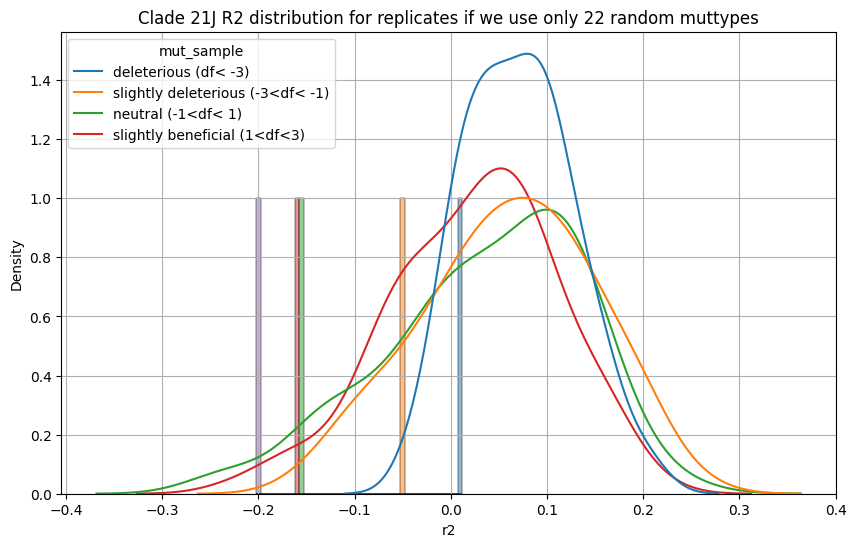

In [115]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_df_res.query('replicate > 0'), x='r2', hue='mut_sample',)
sns.histplot(df_df_res.query('replicate == 0'), 
             x='r2', hue='mut_sample', binwidth=0.005, 
             legend=False, )
plt.grid()
plt.title(f'Clade {clade} R2 distribution for replicates if we use only 22 random muttypes');

In [116]:
aa_muts_for_down

aa1 aa2
0    T   P
1    D   H
2    F   C
3    F   V
4    G   S
5    K   R
6    P   T
7    V   L
8    M   K
9    Q   P
10   M   L
11   T   N
12   L   P
13   R   T
14   L   R
15   E   A
16   E   Q
17   L   V
18   N   H
19   N   K
20   N   T
21   V   G

### try different cutoffs

In [ ]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [35]:
data_fitness = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0')\
        .rename(columns={'actual_count': 'count'})
    aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    data_fitness.append({
        'clade': clade,
        'fitness_range': 'any df',
        'r2': cur_met['r2'], 
        'spearman_corr': cur_met['spearman_corr'], 
        'mut_count': cur_met['mut_count'], 
        'mut_type_count': aas.nobs.ne(0).sum(), 
    })

    for cutoff in np.linspace(0, 2, 9):
        _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & delta_fitness < {-cutoff}')\
            .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness.append({
            'clade': clade,
            'cutoff': cutoff,
            'fitness_range': f'df<{-cutoff}',
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })
        if cutoff != 0:
            _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & {-cutoff} < delta_fitness < {cutoff}')\
                .rename(columns={'actual_count': 'count'})
            aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
            cur_met = calc_metrics(aas)
            data_fitness.append({
                'clade': clade,
                'cutoff': cutoff,
                'fitness_range': f'{-cutoff}<df<{cutoff}',
                'r2': cur_met['r2'], 
                'spearman_corr': cur_met['spearman_corr'], 
                'mut_count': cur_met['mut_count'], 
                'mut_type_count': aas.nobs.ne(0).sum(), 
            })
        _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & delta_fitness > {cutoff}')\
            .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness.append({
            'clade': clade,
            'cutoff': cutoff,
            'fitness_range': f'df>{cutoff}',
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })
data_fitness_df = pd.DataFrame(data_fitness)

20A
24A
21I
23A
22E
20I
21L
22B
21K
21J


In [36]:
data_fitness_df

clade  fitness_range        r2  spearman_corr  mut_count  mut_type_count  \
0     20A         any df  0.556933       0.808099   103442.0             149   
1     20A        df<-0.0  0.642999       0.881414    33318.0              71   
2     20A         df>0.0  0.475721       0.708343    70124.0             149   
3     20A       df<-0.25  0.663616       0.840041    25966.0              61   
4     20A  -0.25<df<0.25  0.448220       0.831113    18870.0              89   
..    ...            ...       ...            ...        ...             ...   
265   21J  -1.75<df<1.75  0.551062       0.797757  1456191.0             150   
266   21J        df>1.75 -0.298147      -0.026083    71019.0              76   
267   21J        df<-2.0  0.568597       0.883850    53271.0              90   
268   21J    -2.0<df<2.0  0.548390       0.802644  1497012.0             150   
269   21J         df>2.0 -0.336762      -0.156195    53471.0              63   

     cutoff  
0       NaN  
1      0.00  
2      0.00  
3      0.25  
4      0.25  
..      ...  
265    1.75  
266    1.75  
267    2.00  
268    2.00  
269    2.00  

[270 rows x 7 columns]

In [37]:
pd.concat([_, pd.DataFrame([pd.Series(name='AAA'), pd.Series(name='BBB')])], axis=1)

clade   gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
631299    21J      E                V         L     58.0        V58L   
631302    21J      E                V         L     75.0        V75L   
631542    21J      M                D         H    209.0       D209H   
631544    21J      M                D         H      3.0         D3H   
631610    21J      M                E         Q    167.0       E167Q   
...       ...    ...              ...       ...      ...         ...   
2816369   21J   nsp2                V         E    628.0       V628E   
2841807   21J   nsp3                Y         N   1185.0      Y1185N   
2877899   21J  nsp13                Y         H    253.0       Y253H   
AAA       NaN    NaN              NaN       NaN      NaN         NaN   
BBB       NaN    NaN              NaN       NaN      NaN         NaN   

         expected_count  count  count_terminal  count_non_terminal  \
631299           7.2389   67.0            38.0                29.0   
631302           7.2389  132.0           120.0                12.0   
631542           7.2389   67.0            38.0                29.0   
631544           7.2389   69.0            40.0                29.0   
631610           7.2389   90.0            47.0                43.0   
...                 ...    ...             ...                 ...   
2816369          3.6933   58.0            54.0                 4.0   
2841807          3.6933   33.0            20.0                13.0   
2877899         22.8170  221.0           132.0                89.0   
AAA                 NaN    NaN             NaN                 NaN   
BBB                 NaN    NaN             NaN                 NaN   

         mean_log_size subset_of_ORF1ab  delta_fitness  aa1  aa2  
631299        0.684590            False         2.1659    V    L  
631302        0.069157            False         2.8403    V    L  
631542        0.694520            False         2.1659    D    H  
631544        0.592330            False         2.1951    D    H  
631610        0.756860            False         2.4591    E    Q  
...                ...              ...            ...  ...  ...  
2816369       0.102950             True         2.6355    V    E  
2841807       0.781380             True         2.0781    Y    N  
2877899       0.685360             True         2.2512    Y    H  
AAA                NaN              NaN            NaN  NaN  NaN  
BBB                NaN              NaN            NaN  NaN  NaN  

[236 rows x 15 columns]

In [38]:
order_df = ['any df', '-0.5<df<0.5', '-0.75<df<0.75', '-1.0<df<1.0',
    '-1.25<df<1.25', '-1.5<df<1.5', 'spliter1',
    'df<-0.0', 'df<-0.5', 'df<-0.75', 'df<-1.0',
    'df<-1.25', 'df<-1.5', 'spliter2', 'df>0.0',
    'df>0.5', 'df>0.75', 'df>1.0', 'df>1.25', 'df>1.5', 
    ]

Text(0.5, 1.0, 'Model quality on mutations with different delta fitness (df)')

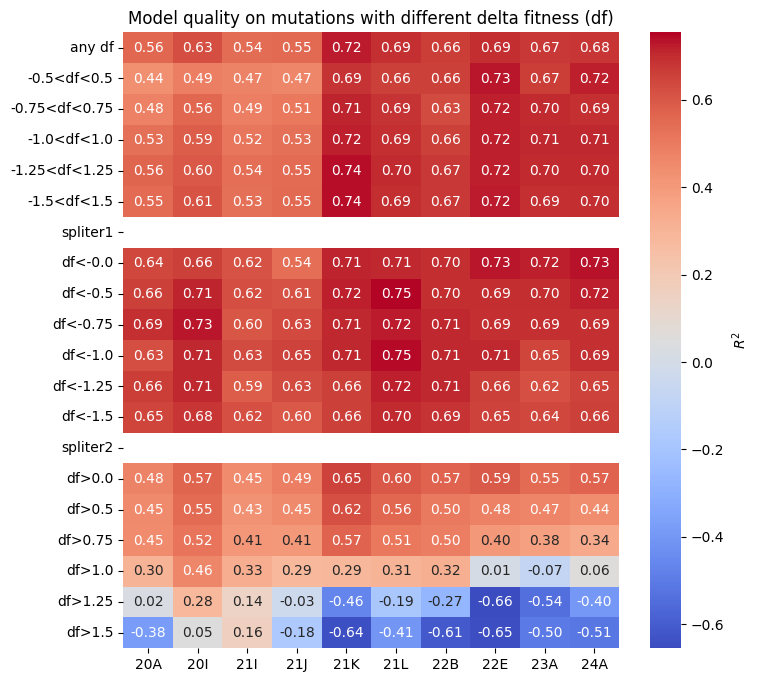

In [39]:
plt.figure(figsize=(8, 8))
_ = data_fitness_df.pivot(columns='clade', index='fitness_range', values='r2')
_ = pd.concat([_, pd.DataFrame([pd.Series(name='spliter1'), pd.Series(name='spliter2')])], axis=1).loc[order_df]
sns.heatmap(_, annot=True, fmt='.2f', 
            # cmap=sns.color_palette("light:g", as_cmap=True), 
            # cmap=sns.light_palette("seagreen", as_cmap=True),
            cmap='coolwarm',
            cbar_kws={'label': '$R^2$'}, )
plt.title('Model quality on mutations with different delta fitness (df)')
# plt.yticks(rotation=0);

Text(0.5, 1.0, 'Mutation type counts for samples with different delta fitness (df)')

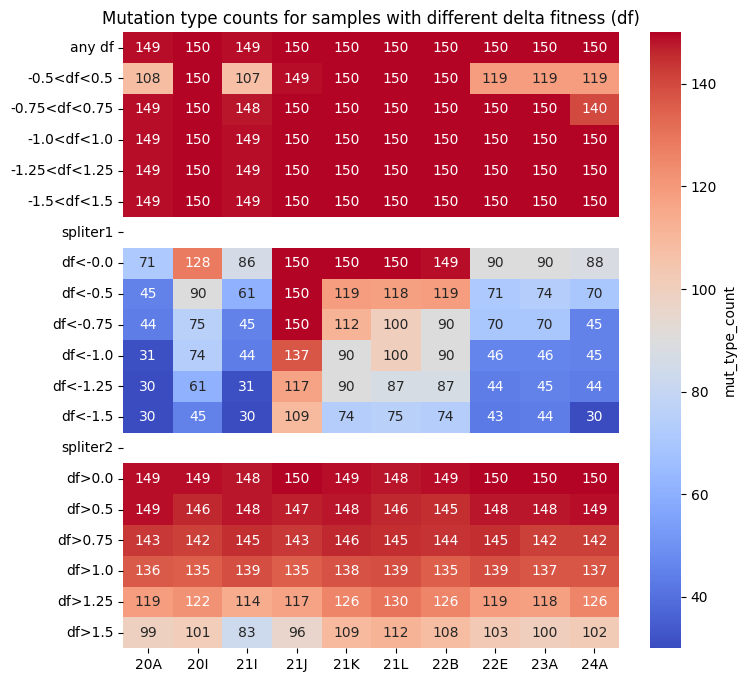

In [45]:
plt.figure(figsize=(8, 8))
_ = data_fitness_df.pivot(columns='clade', index='fitness_range', values='mut_type_count')
_ = pd.concat([_, pd.DataFrame([pd.Series(name='spliter1'), pd.Series(name='spliter2')])], axis=1).loc[order_df]
sns.heatmap(_, annot=True, fmt='.0f', 
            # cmap=sns.color_palette("light:g", as_cmap=True), 
            # cmap=sns.light_palette("seagreen", as_cmap=True),
            cmap='coolwarm',
            cbar_kws={'label': 'mut_type_count'}, )
plt.title('Mutation type counts for samples with different delta fitness (df)')
# plt.yticks(rotation=0);

Text(0.5, 0, 'Clade')

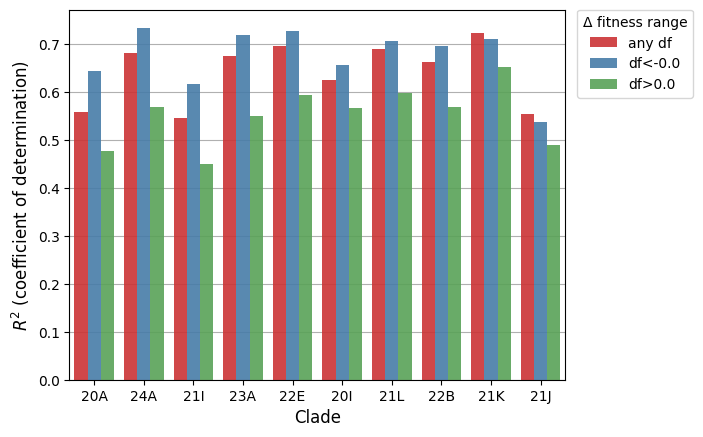

In [80]:
ax = sns.barplot(
    data_fitness_df.fillna(0).query('cutoff == 0'), 
    x='clade', y='r2', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

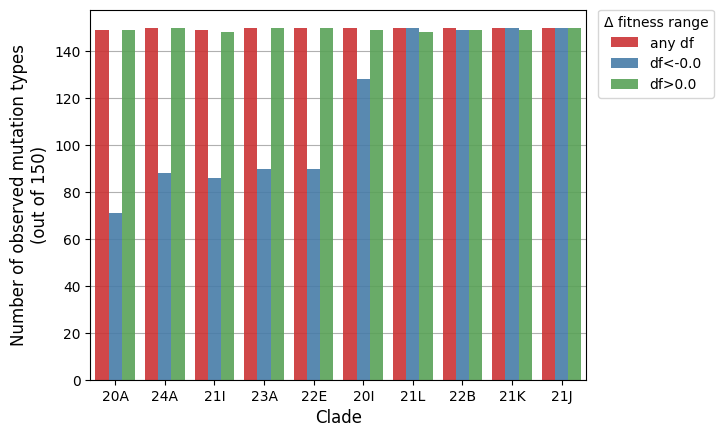

In [82]:
ax = sns.barplot(
    data_fitness_df.fillna(0).query('cutoff == 0'), 
    x='clade', y='mut_type_count', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('Number of observed mutation types\n(out of 150)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

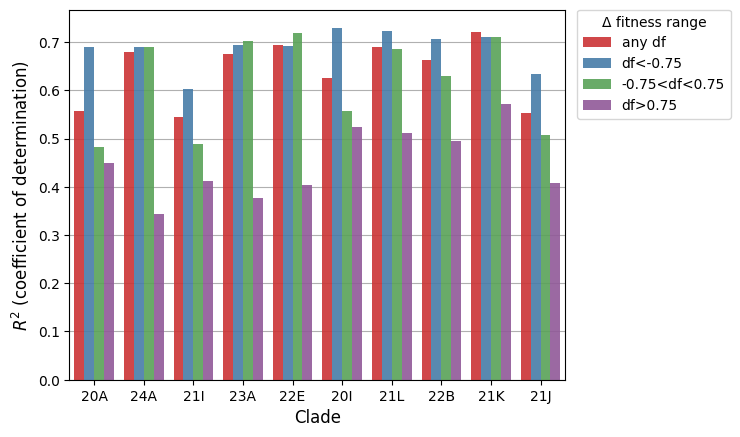

In [76]:
ax = sns.barplot(
    data_fitness_df.fillna(0.75).query('cutoff == 0.75'), 
    x='clade', y='r2', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

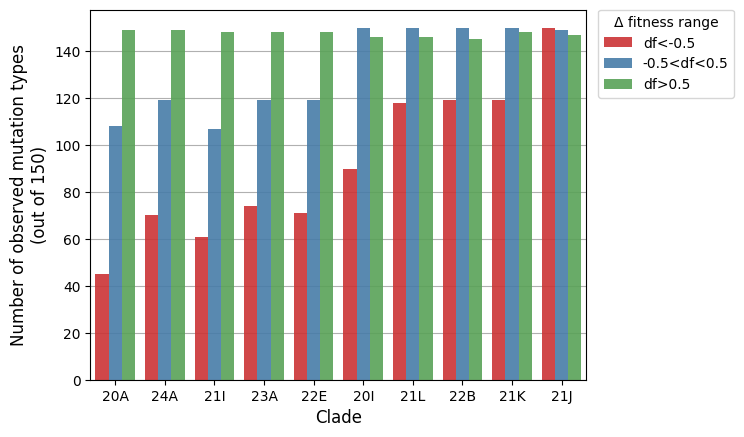

In [78]:
ax = sns.barplot(
    data_fitness_df.query('cutoff == 0.5'), 
    x='clade', y='mut_type_count', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('Number of observed mutation types\n(out of 150)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Spearman correlation: 0.117 (p-value: 0.152)


/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_11623/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


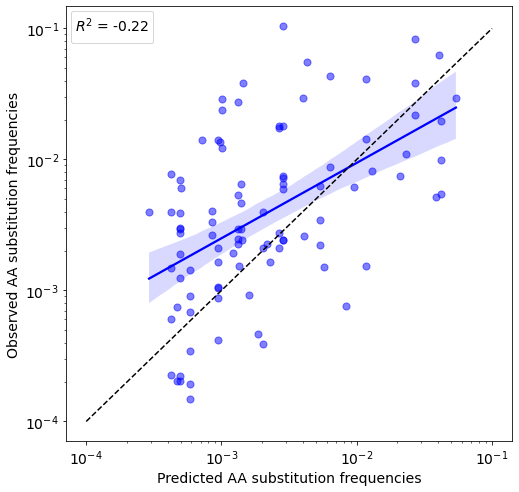

In [346]:
cutoff = 1.5
_ = aamut_fitness_ns.query(f'clade == "21J" & actual_count > 0 & delta_fitness > {cutoff}').rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aas)

In [354]:
aas['ava'] = aas['nobs_freqs'].mean()
aas['res'] = (aas['nobs_freqs'] - aas['nexp_freqs'])**2
aas['tot'] = (aas['nobs_freqs'] - aas['ava'])**2
1 - aas['res'].sum() / aas['tot'].sum()

np.float64(-0.22444001433241434)

In [352]:
r2_score(aas.nobs_freqs, aas.nexp_freqs), spearmanr(aas.nobs_freqs, aas.nexp_freqs)

(-0.22444001433241434,
 SignificanceResult(statistic=np.float64(0.11744032126622556), pvalue=np.float64(0.15235292239994463)))

<Axes: xlabel='nexp_freqs', ylabel='nobs_freqs'>

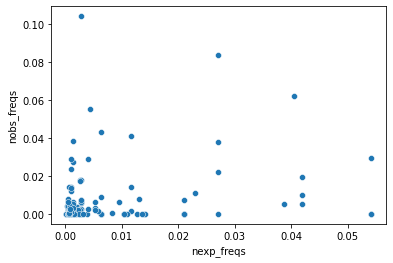

In [347]:
sns.scatterplot(aas, x='nexp_freqs', y='nobs_freqs')

<Axes: xlabel='nexp_freqs', ylabel='nobs_freqs'>

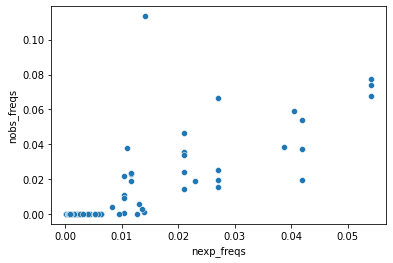

In [317]:
sns.scatterplot(aas, x='nexp_freqs', y='nobs_freqs')

## Fitness of distinct AA

### Prepare site samples of different fitness landscapes

In [65]:
aa_fitness = pd.read_csv('./data/bloom_etal/aa_fitness.csv')
aa_fitness

gene  aa_site aa  fitness  expected_count  \
0          E        1  I  -7.1032         607.410   
1          E        1  K  -3.5840          17.508   
2          E        1  L  -4.3124          36.811   
3          E        1  M   0.0000         844.230   
4          E        1  R  -3.1560          11.238   
...      ...      ... ..      ...             ...   
122158  nsp9      113  K  -3.4869          48.529   
122159  nsp9      113  L  -2.8511          25.461   
122160  nsp9      113  P  -2.0669          11.350   
122161  nsp9      113  Q   0.0000         925.030   
122162  nsp9      113  R  -5.1893          89.169   

        aa_differs_among_clade_founders  subset_of_ORF1ab  
0                                 False             False  
1                                 False             False  
2                                 False             False  
3                                 False             False  
4                                 False             False  
...                                 ...               ...  
122158                            False              True  
122159                            False              True  
122160                            False              True  
122161                            False              True  
122162                            False              True  

[122163 rows x 7 columns]

In [66]:
aa_fitness_ref = aa_fitness.query('fitness == 0').set_index(['gene', 'aa_site'])
aa_fitness_ref

aa  fitness  expected_count  aa_differs_among_clade_founders  \
gene aa_site                                                                
E    1        M      0.0          844.23                            False   
     2        Y      0.0          302.17                            False   
     3        S      0.0          873.08                            False   
     4        F      0.0          287.04                            False   
     5        V      0.0          718.24                            False   
...          ..      ...             ...                              ...   
nsp9 109      T      0.0          888.22                            False   
     110      V      0.0          718.25                            False   
     111      R      0.0         1369.60                            False   
     112      L      0.0          176.26                            False   
     113      Q      0.0          925.03                            False   

              subset_of_ORF1ab  
gene aa_site                    
E    1                   False  
     2                   False  
     3                   False  
     4                   False  
     5                   False  
...                        ...  
nsp9 109                  True  
     110                  True  
     111                  True  
     112                  True  
     113                  True  

[16764 rows x 5 columns]

In [67]:
site_fitnesses = aa_fitness.pivot(index=['gene', 'aa_site'], columns='aa', values='fitness').fillna(0)
site_fitnesses

aa                  *        A       C      D       E       F       G  \
gene aa_site                                                            
E    1        0.00000  0.00000  0.0000  0.000  0.0000  0.0000  0.0000   
     2       -3.78190  0.00000 -5.1893 -3.156  0.0000 -2.8511  0.0000   
     3       -4.88050 -0.95878  0.0000  0.000  0.0000  0.0000  0.0000   
     4        0.00000  0.00000 -3.1560  0.000  0.0000  0.0000  0.0000   
     5        0.00000 -2.27390  0.0000 -3.584  0.0000 -2.2231 -2.0574   
...               ...      ...     ...    ...     ...     ...     ...   
nsp9 109      0.00000 -5.18930  0.0000  0.000  0.0000  0.0000  0.0000   
     110      0.00000 -5.10710  0.0000  0.000 -2.4854  0.0000 -2.0574   
     111      0.00000  0.00000 -7.2405  0.000  0.0000  0.0000 -3.5451   
     112     -0.79691  0.00000  0.0000  0.000  0.0000 -1.0741  0.0000   
     113     -5.63110  0.00000  0.0000  0.000 -2.4465  0.0000  0.0000   

aa                  H        I       K  ...    M      N       P       Q  \
gene aa_site                            ...                               
E    1        0.00000 -7.10320 -3.5840  ...  0.0  0.000  0.0000  0.0000   
     2       -2.27390  0.00000  0.0000  ...  0.0 -3.584  0.0000  0.0000   
     3        0.00000  0.00000  0.0000  ...  0.0  0.000 -0.7633  0.0000   
     4        0.00000 -2.48540  0.0000  ...  0.0  0.000  0.0000  0.0000   
     5        0.00000  0.72401  0.0000  ...  0.0  0.000  0.0000  0.0000   
...               ...      ...     ...  ...  ...    ...     ...     ...   
nsp9 109      0.00000  1.11350 -2.0206  ...  0.0  0.000 -3.1655  0.0000   
     110      0.00000 -1.46820  0.0000  ...  0.0  0.000  0.0000  0.0000   
     111     -4.85820  0.00000  0.0000  ...  0.0  0.000 -1.8907  0.0000   
     112      0.00000 -0.80668  0.0000  ...  0.0  0.000 -5.0843 -3.5662   
     113     -0.81593  0.00000 -3.4869  ...  0.0  0.000 -2.0669  0.0000   

aa                 R       S       T       V    W       Y  
gene aa_site                                               
E    1       -3.1560  0.0000 -5.1071 -4.0907  0.0  0.0000  
     2        0.0000 -3.1655  0.0000  0.0000  0.0  0.0000  
     3        0.0000  0.0000 -1.1861  0.0000  0.0  0.0000  
     4        0.0000 -3.1612  0.0000 -3.1560  0.0 -1.9745  
     5        0.0000  0.0000  0.0000  0.0000  0.0  0.0000  
...              ...     ...     ...     ...  ...     ...  
nsp9 109     -3.5451 -3.9498  0.0000  0.0000  0.0  0.0000  
     110      0.0000  0.0000  0.0000  0.0000  0.0  0.0000  
     111      0.0000 -4.5855  0.0000  0.0000  0.0  0.0000  
     112     -3.1308 -1.5527  0.0000 -2.4446  0.0  0.0000  
     113     -5.1893  0.0000  0.0000  0.0000  0.0  0.0000  

[16764 rows x 21 columns]

In [68]:
X_descr = aa_fitness.query('aa != "*" & fitness != 0')\
    .groupby(['gene', 'aa_site'])['fitness'].aggregate(['min', 'max', 'mean', 'median', 'std', 'count']).join(
        aa_fitness.query('aa != "*"').groupby(['gene', 'aa_site'])\
            ['fitness'].max().rename('max=0') == 0)

In [69]:
X_descr

min      max      mean   median       std  count  max=0
gene aa_site                                                            
E    1       -7.1032 -3.15600 -4.558900 -4.20155  1.412269      6   True
     2       -5.1893 -2.27390 -3.369967 -3.16075  0.991358      6   True
     3       -2.4956 -0.76330 -1.350945 -1.07244  0.782417      4   True
     4       -3.1612 -0.36699 -2.383348 -2.82070  1.099300      6   True
     5       -3.5840  0.72401 -1.498047 -2.14025  1.698920      6  False
...              ...      ...       ...      ...       ...    ...    ...
nsp9 109     -5.1893  1.11350 -2.792800 -3.35530  2.174497      6  False
     110     -5.1071 -1.46820 -2.825300 -2.48540  1.395265      5   True
     111     -7.2405 -1.89070 -4.397983 -4.42670  1.752579      6   True
     112     -5.0843 -0.80668 -2.522769 -2.44460  1.528106      7   True
     113     -5.1893 -0.81593 -2.809438 -2.64880  1.468441      6   True

[16764 rows x 7 columns]

In [70]:
X_descr['count'].value_counts()

count
6     10663
7      2731
5      2171
4       964
9       126
10       44
8        32
11       14
3         8
13        5
12        5
14        1
Name: count, dtype: int64

<Axes: >

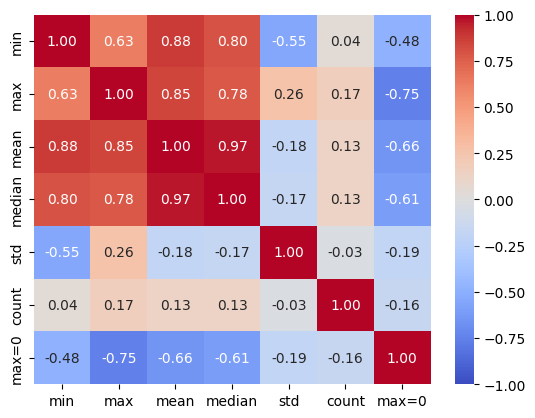

In [22]:
sns.heatmap(X_descr.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)

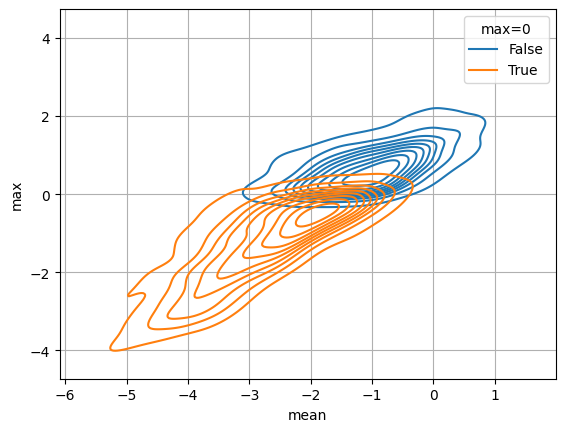

In [23]:
# sns.kdeplot(X_descr, x='mean', y='max')
sns.kdeplot(X_descr.sample(frac=0.1), x='mean', y='max', hue='max=0')
# plt.ylim(-1, 2)
plt.grid()

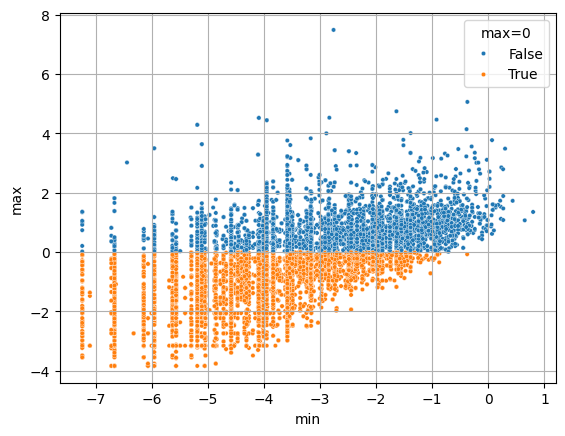

In [24]:
sns.scatterplot(X_descr, x='min', y='max', hue='max=0', s=10)
plt.grid()

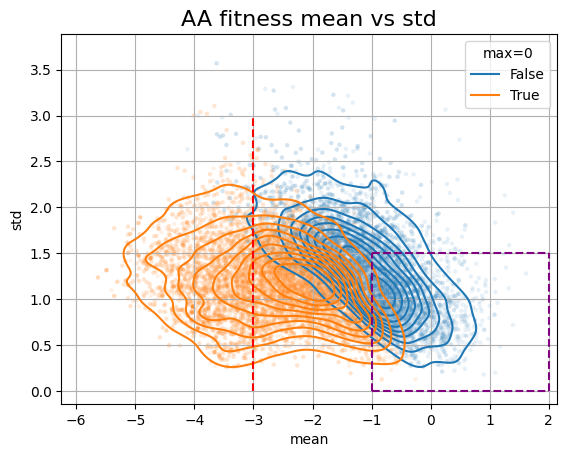

In [25]:
frac=0.5
# sns.scatterplot(X_descr.sample(frac=frac), x='mean', y='std', hue='max=0', alpha=0.1, s=10)
# sns.kdeplot(X_descr.sample(frac=frac), x='mean', y='std', hue='max=0')

sns.scatterplot(X_descr, x='mean', y='std', hue='max=0', alpha=0.1, s=10)
sns.kdeplot(X_descr, x='mean', y='std', hue='max=0')
plt.title('AA fitness mean vs std', fontsize=16)
# plt.plot([-3, 0], [0, 3])
plt.vlines([-1, 2], 0, 1.5, color='purple', linestyle='--', label='plateau')
plt.hlines([0, 1.5], -1, 2, color='purple', linestyle='--', label='plateau')
plt.vlines([-3], 0, 3, color='red', linestyle='--', label='peak')
plt.grid()

In [71]:
# Sharp peaks
# X_descr.query('mean < -3')
# sites_plateau = X_descr.query('-1 < mean < 1 & std < 1.5')

## initial classification with some assumtions
# X_descr['landscape_char'] = 'none'
# X_descr.loc[(X_descr['mean'] < -3), 'landscape_char'] = 'rock'
# X_descr.loc[(X_descr['mean'].between(-3, -1))&(X_descr['max=0']), 'landscape_char'] = 'hill'
# X_descr.loc[(X_descr['mean'].between(-3, -1))&(~X_descr['max=0']), 'landscape_char'] = 'climb'
# X_descr.loc[(X_descr['mean'].between(-1, 2 ))&(X_descr['std'] < 1), 'landscape_char'] = 'plateau'
# X_descr.loc[(X_descr['mean'].between(-1, 2 ))&(X_descr['std'] > 1), 'landscape_char'] = 'canyon'


X_descr.loc[(X_descr['max=0']), 'landscape_char'] = 'ref_is_highest'
X_descr.loc[(~X_descr['max=0']), 'landscape_char'] = 'ref_is_not_highest'


In [72]:
X_descr.landscape_char.value_counts()

landscape_char
ref_is_highest        9946
ref_is_not_highest    6818
Name: count, dtype: int64

Text(0.5, 0, 'mean (mount height)')

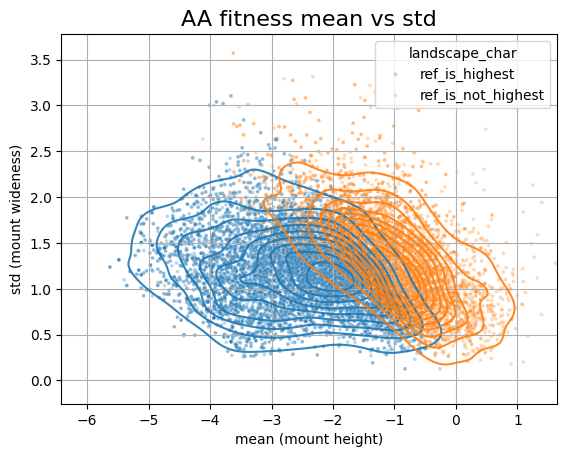

In [81]:
ax=sns.kdeplot(X_descr.sample(frac=0.1), x='mean', y='std', hue='landscape_char', alpha=0.9)
sns.scatterplot(X_descr, x='mean', y='std', hue='landscape_char', alpha=0.3, s=7,ax=ax)
plt.title('AA fitness mean vs std', fontsize=16)
# plt.plot([-3, 0], [0, 3])
# plt.vlines([-1, 2], 0, 1.5, color='purple', linestyle='--', label='plateau')
# plt.hlines([0, 1.5], -1, 2, color='purple', linestyle='--', label='plateau')
# plt.vlines([-3], 0, 3, color='red', linestyle='--', label='peak')
plt.grid()
plt.ylabel('std (mount wideness)')
plt.xlabel('mean (mount height)')

Text(0.5, 0, 'mean (mount height)')

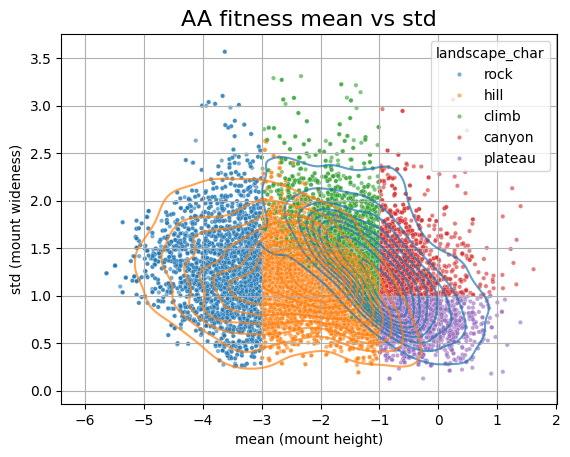

In [28]:
sns.kdeplot(X_descr.sample(frac=0.1), x='mean', y='std', hue='max=0', alpha=0.7)
sns.scatterplot(X_descr, x='mean', y='std', hue='landscape_char', alpha=0.6, s=10)
plt.title('AA fitness mean vs std', fontsize=16)
# plt.plot([-3, 0], [0, 3])
# plt.vlines([-1, 2], 0, 1.5, color='purple', linestyle='--', label='plateau')
# plt.hlines([0, 1.5], -1, 2, color='purple', linestyle='--', label='plateau')
# plt.vlines([-3], 0, 3, color='red', linestyle='--', label='peak')
plt.grid()
plt.ylabel('std (mount wideness)')
plt.xlabel('mean (mount height)')

In [82]:
X_descr[['landscape_char']].to_csv('./data/sites_landscape_labels.csv')

### Assess model on different landscapes

In [87]:
aamut_fitness_ns_lbl = aamut_fitness_ns.merge(X_descr[['landscape_char']].reset_index())
aamut_fitness_ns_lbl

clade  gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
0         20A     E                A         D       22        A22D   
1         20A     E                A         D       32        A32D   
2         20A     E                A         E       36        A36E   
3         20A     E                A         E       41        A41E   
4         20A     E                A         G       22        A22G   
...       ...   ...              ...       ...      ...         ...   
2375634   24A  nsp1                Y         D       97        Y97D   
2375635   24A  nsp1                Y         F       97        Y97F   
2375636   24A  nsp1                Y         H       97        Y97H   
2375637   24A  nsp1                Y         N       97        Y97N   
2375638   24A  nsp1                Y         S       97        Y97S   

         expected_count  actual_count  count_terminal  count_non_terminal  \
0               0.67725             0               0                   0   
1               0.67725             0               0                   0   
2               0.67725             0               0                   0   
3               0.67725             0               0                   0   
4               0.23810             0               0                   0   
...                 ...           ...             ...                 ...   
2375634         0.25363             0               0                   0   
2375635         0.77908             0               0                   0   
2375636         2.17910             0               0                   0   
2375637         0.48805             0               0                   0   
2375638         0.20445             0               0                   0   

         mean_log_size  subset_of_ORF1ab  delta_fitness aa1 aa2  \
0                  0.0             False       -0.85633   A   D   
1                  0.0             False       -0.85633   A   D   
2                  0.0             False       -0.85633   A   E   
3                  0.0             False       -0.85633   A   E   
4                  0.0             False       -0.38947   A   G   
...                ...               ...            ...  ..  ..   
2375634            0.0              True       -0.41029   Y   D   
2375635            0.0              True       -0.93929   Y   F   
2375636            0.0              True       -1.67860   Y   H   
2375637            0.0              True       -0.68113   Y   N   
2375638            0.0              True       -0.34281   Y   S   

         landscape_char  
0        ref_is_highest  
1        ref_is_highest  
2        ref_is_highest  
3        ref_is_highest  
4        ref_is_highest  
...                 ...  
2375634  ref_is_highest  
2375635  ref_is_highest  
2375636  ref_is_highest  
2375637  ref_is_highest  
2375638  ref_is_highest  

[2375639 rows x 16 columns]

In [88]:
aamut_fitness_ns_lbl.groupby('landscape_char').actual_count.sum()

landscape_char
ref_is_highest        1257912
ref_is_not_highest    3801152
Name: actual_count, dtype: int64

In [89]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [90]:
data_fitness_sites = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
    
    n_to_sample = aamut_fitness_ns_lbl.query(f'clade == "{clade}"').groupby('landscape_char')\
        ['actual_count'].sum().sort_values().iloc[0]

    for lchar in aamut_fitness_ns_lbl.landscape_char.unique():
        print(lchar, end=' ')

        cur_aa_freqs_dct = X_descr.query(f'landscape_char == "{lchar}"')[['landscape_char']]\
            .join(aa_fitness_ref[['aa']]).aa.value_counts().rename(index=amino_acid_codes).to_dict()

        cur_aamut = aamut_fitness_ns_lbl\
            .query(f'clade == "{clade}" & actual_count > 0 & landscape_char == "{lchar}"')\
                .rename(columns={'actual_count': 'count'})

        # downsample to the minimum count in the landscape
        exploded = []
        for _, x in cur_aamut[['aa1', 'aa2', 'count']].iterrows():
            for _ in range(x['count']):
                exploded.append(x)
        exploded = pd.DataFrame(exploded).reset_index(drop=True)
        exploded['count'] = 1

        nreplics = 1 if n_to_sample == cur_aamut['count'].sum() else 10
        
        for replic in range(nreplics):
            cur_sample = exploded.sample(n_to_sample, replace=False)

            aas = prepare_aa_subst(cur_sample, exp_aa_subst_cur, cur_aa_freqs_dct)
            cur_met = calc_metrics(aas)
            data_fitness_sites.append({
                'replic': replic, 
                'clade': clade,
                'landscape_char': lchar,
                'r2': cur_met['r2'], 
                'spearman_corr': cur_met['spearman_corr'], 
                'mut_count': cur_met['mut_count'], 
                'mut_type_count': aas.nobs.ne(0).sum(), 
            })
    print()

data_fitness_sites_df = pd.DataFrame(data_fitness_sites)

20A
ref_is_highest ref_is_not_highest 
24A
ref_is_highest ref_is_not_highest 
21I
ref_is_highest ref_is_not_highest 
23A
ref_is_highest ref_is_not_highest 
22E
ref_is_highest ref_is_not_highest 
20I
ref_is_highest ref_is_not_highest 
21L
ref_is_highest ref_is_not_highest 
22B
ref_is_highest ref_is_not_highest 
21K
ref_is_highest ref_is_not_highest 
21J
ref_is_highest ref_is_not_highest 


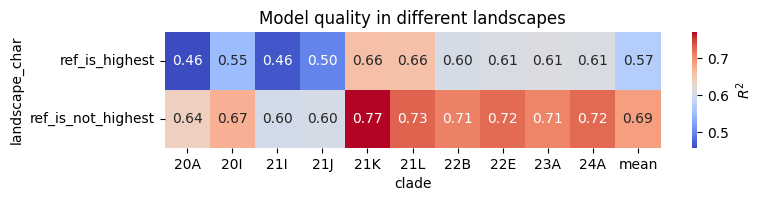

In [93]:
plt.figure(figsize=(8, 1.5))
_ = data_fitness_sites_df.set_index('replic')\
        .groupby(['clade', 'landscape_char']).mean().reset_index()\
                .pivot(columns='clade', index='landscape_char', values='r2')
                        # .loc[['canyon', 'plateau', 'hill', 'climb', 'rock']]
_['mean'] = _.mean(axis=1)

sns.heatmap(_, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': '$R^2$'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0);

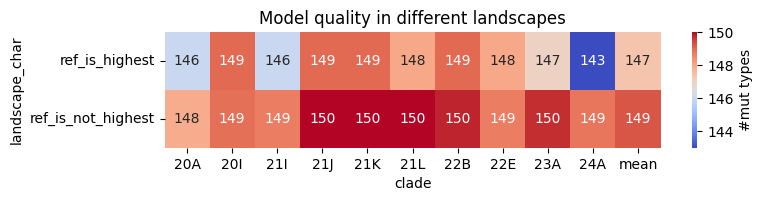

In [95]:
plt.figure(figsize=(8, 1.5))
_ = data_fitness_sites_df.set_index('replic')\
        .groupby(['clade', 'landscape_char']).mean().reset_index()\
                .pivot(columns='clade', index='landscape_char', values='mut_type_count')
                        # .loc[['canyon', 'plateau', 'hill', 'climb', 'rock']]
        # [['plateau', 'climb', 'hill', 'rock',]]
_['mean'] = _.mean(axis=1)

sns.heatmap(_, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': '#mut types'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0);

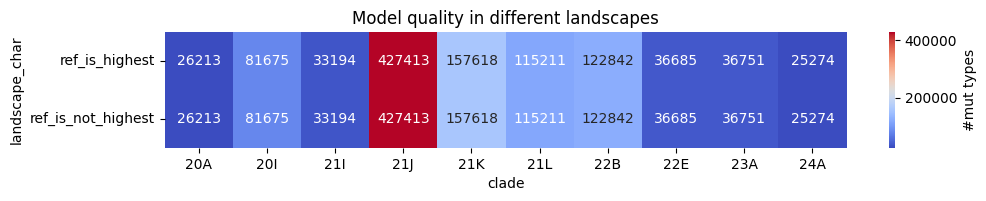

In [98]:
plt.figure(figsize=(11, 1.5))
_ = data_fitness_sites_df.set_index('replic')\
        .groupby(['clade', 'landscape_char']).mean().reset_index()\
                .pivot(columns='clade', index='landscape_char', values='mut_count')
                        # .loc[['canyon', 'plateau', 'hill', 'climb', 'rock']]
        # [['plateau', 'climb', 'hill', 'rock',]]
sns.heatmap(_, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': '#mut types'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0);

### lanscape and df merged

In [ ]:
data_fitness_sites = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    for lchar in aamut_fitness_ns_lbl.landscape_char.unique():
        print(lchar, end=' ')

        cur_aa_freqs_dct = X_descr.query(f'landscape_char == "{lchar}"')[['landscape_char']]\
            .join(aa_fitness_ref[['aa']]).aa.value_counts().rename(index=amino_acid_codes).to_dict()

        cur_aamut = aamut_fitness_ns_lbl\
            .query(f'clade == "{clade}" & actual_count > 0 & landscape_char == "{lchar}"')\
                .rename(columns={'actual_count': 'count'})
        
        cur_aamut_low_df  = cur_aamut.query('delta_fitness < 0')
        cur_aamut_high_df = cur_aamut.query('delta_fitness >= 0')

        for cur_sample, label in zip([cur_aamut, cur_aamut_low_df, cur_aamut_high_df], 
                                     ['any', 'Δfitness<0', 'Δfitness>0']):

            aas = prepare_aa_subst(cur_sample, exp_aa_subst_cur, cur_aa_freqs_dct)
            cur_met = calc_metrics(aas)
            data_fitness_sites.append({
                'clade': clade,
                'landscape_char': lchar,
                'df_sample': label, 
                'r2': cur_met['r2'], 
                'spearman_corr': cur_met['spearman_corr'], 
                'mut_count': cur_met['mut_count'], 
                'mut_type_count': aas.nobs.ne(0).sum(), 
            })
    print()

data_fitness_sites_df = pd.DataFrame(data_fitness_sites)
data_fitness_sites_df.to_csv('./data/metrics_landscapes_and_df.csv', index=False)

20A
ref_is_highest ref_is_not_highest 
24A
ref_is_highest ref_is_not_highest 
21I
ref_is_highest ref_is_not_highest 
23A
ref_is_highest ref_is_not_highest 
22E
ref_is_highest ref_is_not_highest 
20I
ref_is_highest ref_is_not_highest 
21L
ref_is_highest ref_is_not_highest 
22B
ref_is_highest ref_is_not_highest 
21K
ref_is_highest ref_is_not_highest 
21J
ref_is_highest ref_is_not_highest 


In [112]:
data_fitness_sites_df.head()

clade      landscape_char   df_sample        r2  spearman_corr  mut_count  \
0   20A      ref_is_highest         any  0.457175       0.804500    26213.0   
1   20A      ref_is_highest  Δfitness<0  0.581366       0.877995    17669.0   
2   20A      ref_is_highest  Δfitness>0 -0.226992       0.392497     8544.0   
3   20A  ref_is_not_highest         any  0.639564       0.819285    77229.0   
4   20A  ref_is_not_highest  Δfitness<0  0.624500       0.879572    15649.0   

   mut_type_count  
0             146  
1              71  
2             136  
3             149  
4              71

In [151]:
top_clades = data_fitness_sites_df.query('df_sample == "Δfitness<0" & mut_type_count > 120').clade.unique()

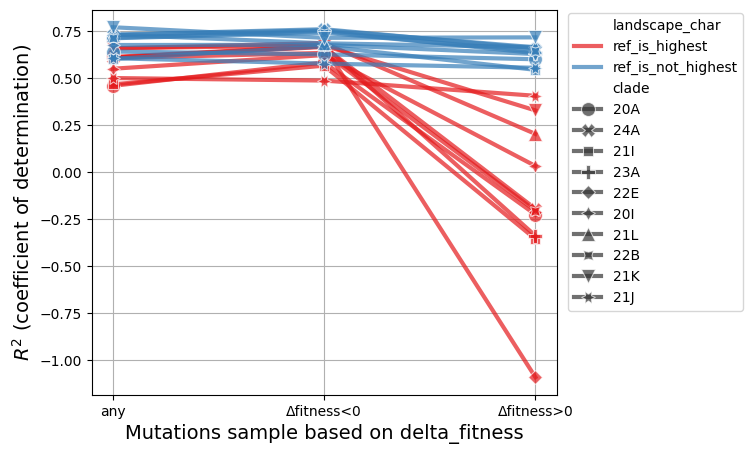

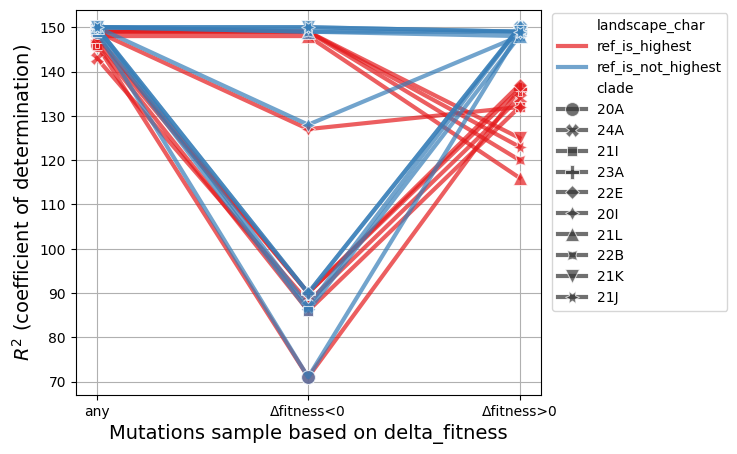

In [154]:
plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data_fitness_sites_df, hue='landscape_char', y='r2', style='clade', x='df_sample', 
    markers=True, dashes=False, palette='Set1', alpha=0.7,
    linewidth=3, markersize=10, 
    # style_order=top_clades,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
# ax.set_xticks(range(1, 5))
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=14)
ax.set_xlabel('Mutations sample based on delta_fitness', fontsize=14)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
# plt.xticks(fontsize=14)
plt.show()

plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data_fitness_sites_df, hue='landscape_char', y='mut_type_count', style='clade', x='df_sample', 
    markers=True, dashes=False, palette='Set1', alpha=0.7,
    linewidth=3, markersize=10, 
    # style_order=top_clades,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
# ax.set_xticks(range(1, 5))
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=14)
ax.set_xlabel('Mutations sample based on delta_fitness', fontsize=14)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
# plt.xticks(fontsize=14)
plt.show()

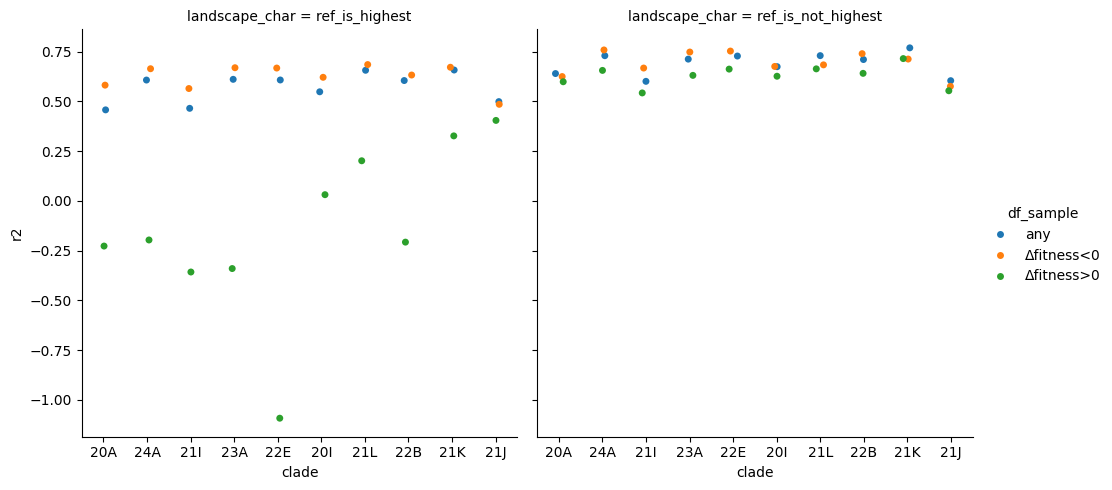

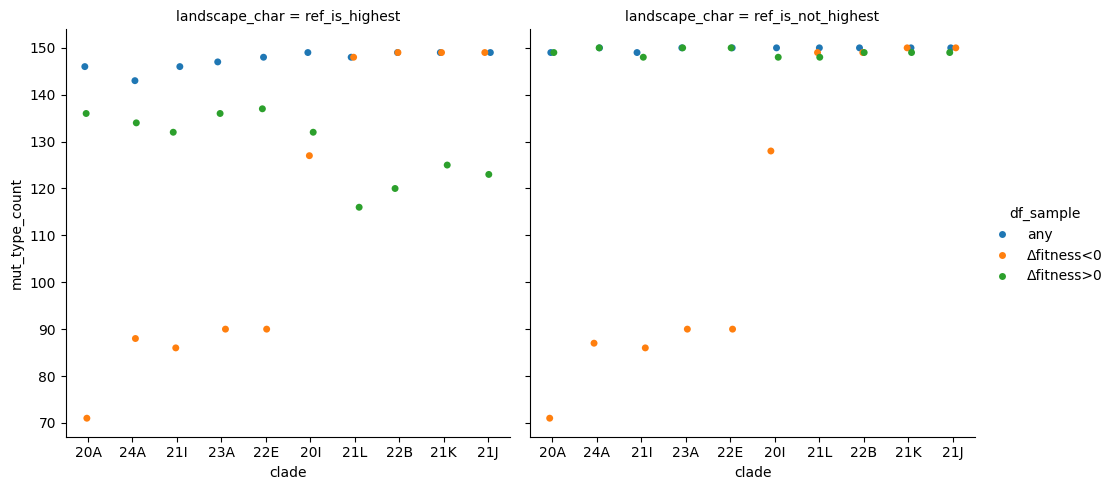

In [114]:
sns.catplot(data_fitness_sites_df, x='clade', y='r2', hue='df_sample', col='landscape_char')
sns.catplot(data_fitness_sites_df, x='clade', y='mut_type_count', hue='df_sample', col='landscape_char')

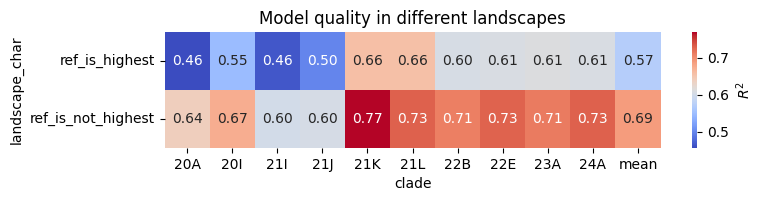

In [106]:
plt.figure(figsize=(8, 1.5))
_ = data_fitness_sites_df.pivot(columns='clade', index='landscape_char', values='r2')
_['mean'] = _.mean(axis=1)

sns.heatmap(_, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': '$R^2$'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0);

### estimate distance to equilibrium in different landscapes

In [99]:
d_to_eq_data = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()
    _, cur_aa_freq = get_equilibrium_freqs(spectrum_cur, 'rate')

    for lchar in aamut_fitness_ns_lbl.landscape_char.unique():
        print(lchar, end=' ')

        cur_aa_freqs_dct = X_descr.query(f'landscape_char == "{lchar}"')[['landscape_char']]\
            .join(aa_fitness_ref[['aa']]).aa.value_counts().rename(index=amino_acid_codes).to_dict()
        
        cur_aa_freq['obs_cnt'] = cur_aa_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_freq['obs_freq'] = cur_aa_freq['obs_cnt'] / cur_aa_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])
        de = euclidean(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])

        d_to_eq_data.append({
            'clade': clade,
            'landscape_char': lchar,
            'cityblock': dm, 
            'euclidean': de, 
        })
    
    print()

d_to_eq_df = pd.DataFrame(d_to_eq_data)

20A
ref_is_highest ref_is_not_highest 
24A
ref_is_highest ref_is_not_highest 
21I
ref_is_highest ref_is_not_highest 
23A
ref_is_highest ref_is_not_highest 
22E
ref_is_highest ref_is_not_highest 
20I
ref_is_highest ref_is_not_highest 
21L
ref_is_highest ref_is_not_highest 
22B
ref_is_highest ref_is_not_highest 
21K
ref_is_highest ref_is_not_highest 
21J
ref_is_highest ref_is_not_highest 


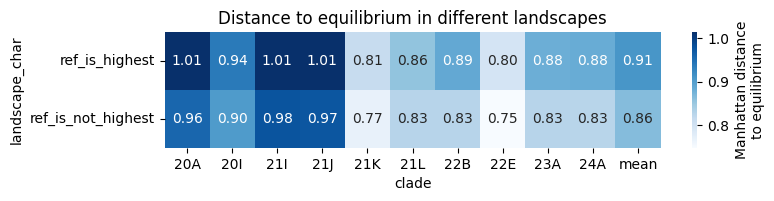

In [102]:
plt.figure(figsize=(8, 1.5))
_ = d_to_eq_df.pivot(index='landscape_char', columns='clade', values='cityblock')
_['mean'] = _.mean(axis=1)
sns.heatmap(_, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Manhattan distance\nto equilibrium'})
plt.title('Distance to equilibrium in different landscapes')
plt.yticks(rotation=0);

## VIZ of computed metrics

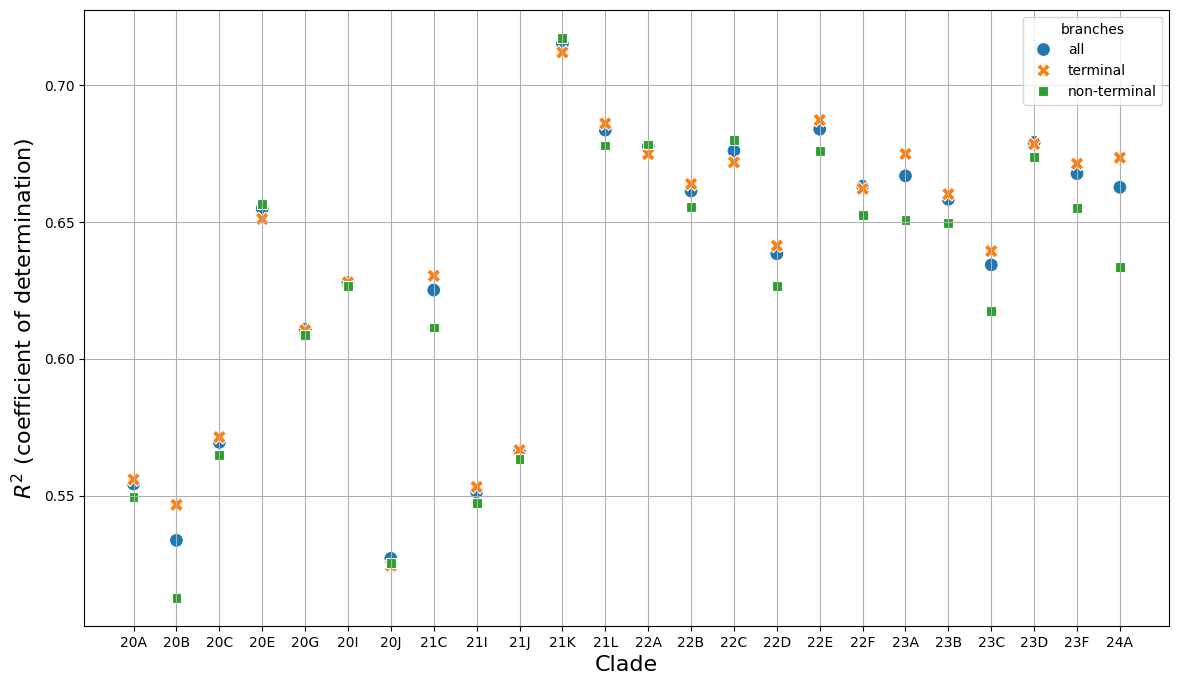

In [2]:
metrics_total_df = pd.read_csv('data/fit_metrics_sites.csv')

plt.figure(figsize=(14, 8))
_ = metrics_total_df.query('sites_sample == "total"')
sns.scatterplot(_, hue='branches', y='r2', x='clade', style='branches', s=100)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Clade', fontsize=16)
plt.grid()

In [62]:
_1 = {x:'Early clades' for x in metrics_total_df.set_index('clade').loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in metrics_total_df.set_index('clade').loc['21K':].index.unique()}

_clade2label = {**_1, **_2}

In [63]:
metrics_total_df['time_period'] = metrics_total_df['clade'].map(_clade2label)

/tmp/ipykernel_32114/2484850319.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


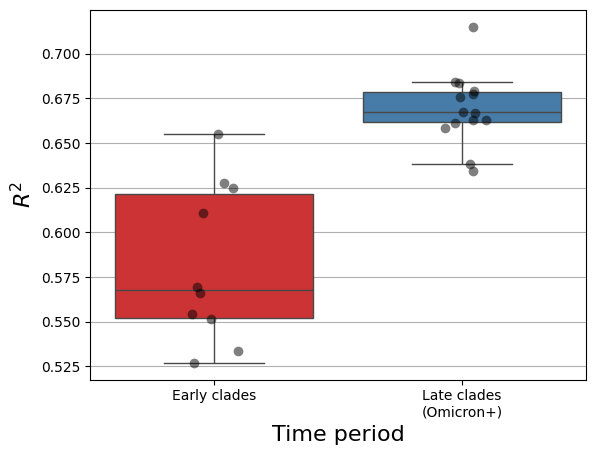

In [66]:
sns.stripplot(
    metrics_total_df.query('sites_sample == "total" & branches == "all"'), 
    y='r2', x='time_period', s=7, jitter=0.1, color='black', alpha=0.5,
)
sns.boxplot(
    metrics_total_df.query('sites_sample == "total" & branches == "all"'), 
    y='r2', x='time_period', 
    palette='Set1', fliersize=0,
)
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Time period', fontsize=16)
plt.grid(axis='y')

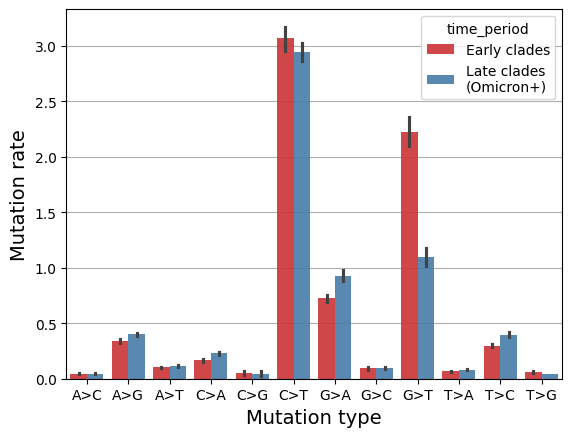

In [14]:
clades_spectra = pd.read_csv('./data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['time_period'] = clades_spectra['clade'].map(_clade2label)
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
# _ = clades_spectra.groupby(['time_period', 'Mut'])['rate'].mean()
ax=sns.barplot(
    # _[_ > 0].reset_index(),
    clades_spectra,
    x='Mut', y='rate', hue='time_period',
    palette='Set1', alpha=0.9, hue_order=['Early clades', 'Late clades\n(Omicron+)'],
)
plt.ylabel('Mutation rate', fontsize=14)
plt.xlabel('Mutation type', fontsize=14)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [11]:
metrics_total_df = pd.read_csv('data/fit_metrics_site_rate_cat4.csv')
    # .set_index(['clade', 'branches', 'sites_sample',])
metrics_total_df

clade rate_cat  nt_sites        r2  spearman_corr    spearman_p  \
0     20A        1      1178 -1.097360       0.325784  4.737890e-05   
1     20A        2      3749 -1.320120       0.515413  1.489520e-11   
2     20A        3      3891 -0.520440       0.720927  2.427290e-25   
3     20A        4      3176  0.434163       0.750155  2.259660e-28   
4     20A      any     11994  0.554192       0.789971  2.992510e-33   
..    ...      ...       ...       ...            ...           ...   
115   24A        1       793 -1.314690       0.254997  1.637380e-03   
116   24A        2      3734 -1.506370       0.446625  1.011570e-08   
117   24A        3      3925 -0.928536       0.657559  6.229410e-20   
118   24A        4      3185  0.560123       0.720025  2.968180e-25   
119   24A      any     11637  0.662644       0.758251  2.748880e-29   

     mut_count  mut_type_count  
0         1423             128  
1         6587             144  
2        12130             147  
3        44291             145  
4        64431             149  
..         ...             ...  
115        990             116  
116       7127             140  
117      13927             148  
118      42876             144  
119      64920             150  

[120 rows x 8 columns]

In [64]:
_ = pd.read_csv('./data/ref_sites_rates_cat4.csv', index_col=0)

_.rate_cat.value_counts() / len(_)

rate_cat
2    0.332604
3    0.251914
1    0.222180
4    0.169207
0    0.024094
Name: count, dtype: float64

In [54]:
_ = metrics_total_df.pivot(index='clade', columns='rate_cat', values='mut_count')
(_.T / _['any']).T#['4'].describe()

rate_cat         1         2         3         4  any
clade                                                
20A       0.022086  0.102233  0.188263  0.687418  1.0
20B       0.021782  0.101142  0.186185  0.690890  1.0
20C       0.018537  0.098022  0.194283  0.689158  1.0
20E       0.024084  0.107502  0.186623  0.681792  1.0
20G       0.017928  0.101843  0.187154  0.693076  1.0
20I       0.018474  0.101827  0.183960  0.695740  1.0
20J       0.012835  0.090457  0.181835  0.714873  1.0
21C       0.016736  0.101877  0.190206  0.691180  1.0
21I       0.017019  0.105305  0.201955  0.675720  1.0
21J       0.020043  0.111647  0.206517  0.661793  1.0
21K       0.019877  0.115721  0.214308  0.650094  1.0
21L       0.014911  0.103758  0.204439  0.676892  1.0
22A       0.013101  0.103443  0.202601  0.680855  1.0
22B       0.013900  0.103667  0.201397  0.681037  1.0
22C       0.014240  0.111237  0.205717  0.668806  1.0
22D       0.016680  0.122382  0.231672  0.629267  1.0
22E       0.016805  0.119003  0.223283  0.640909  1.0
22F       0.013815  0.114798  0.222307  0.649080  1.0
23A       0.014863  0.118064  0.231457  0.635617  1.0
23B       0.016072  0.120062  0.228639  0.635227  1.0
23C       0.017841  0.120714  0.242250  0.619195  1.0
23D       0.013824  0.111473  0.227109  0.647595  1.0
23F       0.013885  0.114572  0.227549  0.643994  1.0
24A       0.015250  0.109781  0.214526  0.660444  1.0

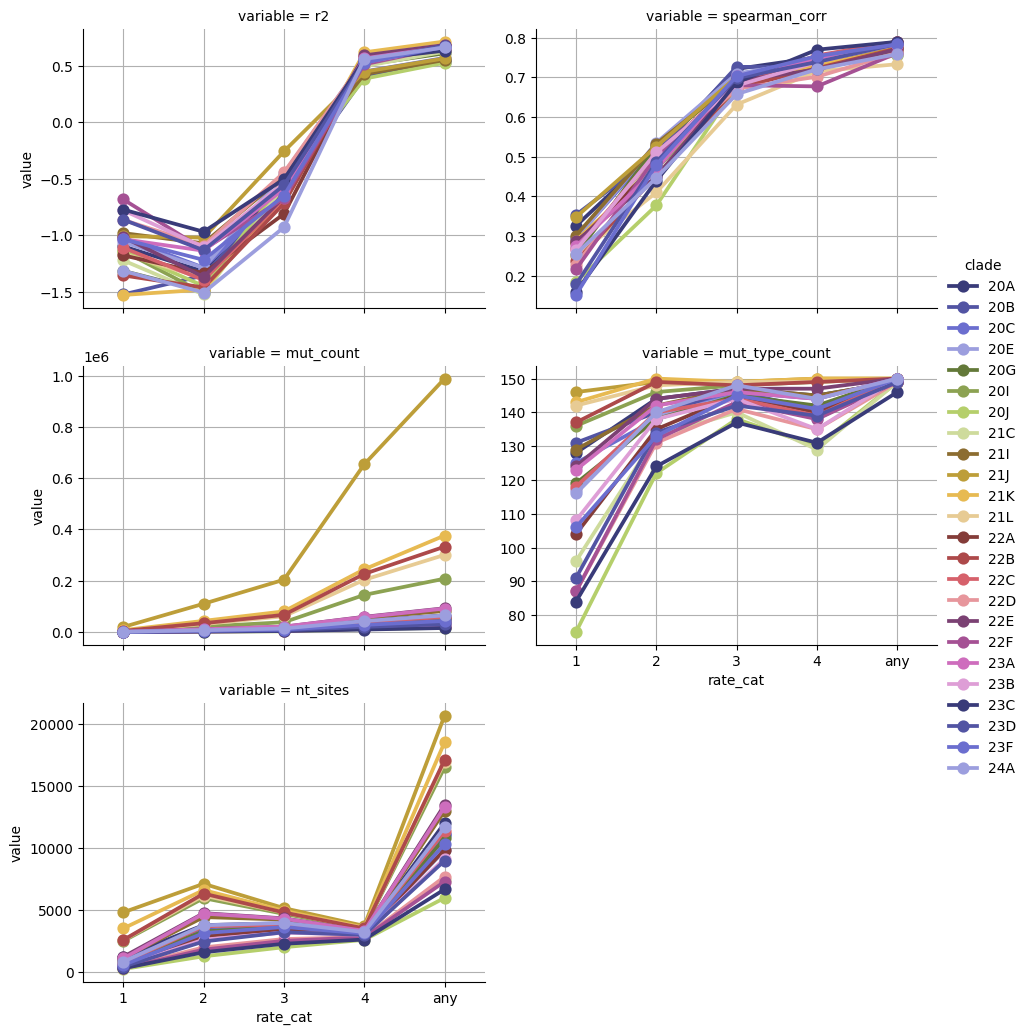

In [44]:
_ = metrics_total_df.melt(
    ['clade', 'rate_cat'], ['r2', 'spearman_corr', 'mut_count', 'mut_type_count','nt_sites'])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    col_wrap=2, kind='point', height=4, aspect=1.2, sharey=False, palette='tab20b'
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)

# g.axes_dict['mut_count'].set_ylim(0, 200000)

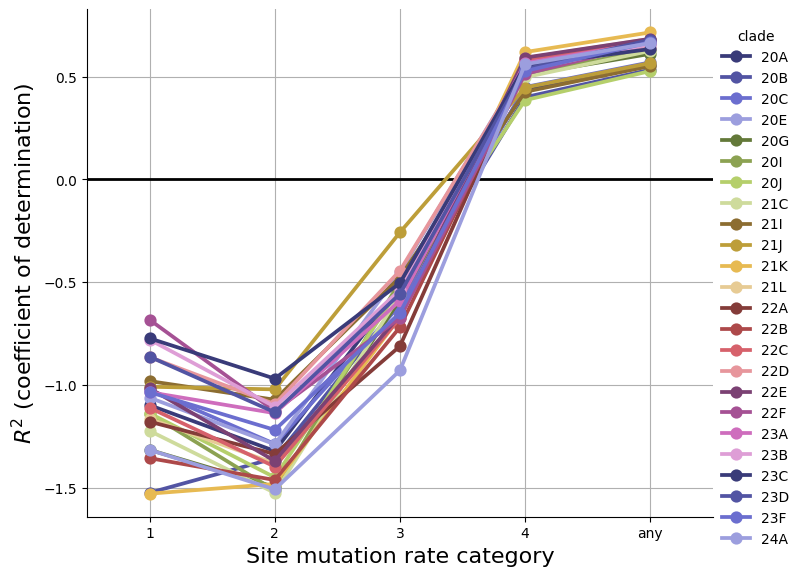

In [12]:
_ = metrics_total_df.melt(
    ['clade', 'rate_cat'], ['r2', ])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    kind='point', height=6, aspect=1.2, sharey=False, palette='tab20b'
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title('')
    ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=16)
    ax.set_xlabel('Site mutation rate category', fontsize=16)
    bou = ax.get_xbound()
    ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.set_xlim(bou)


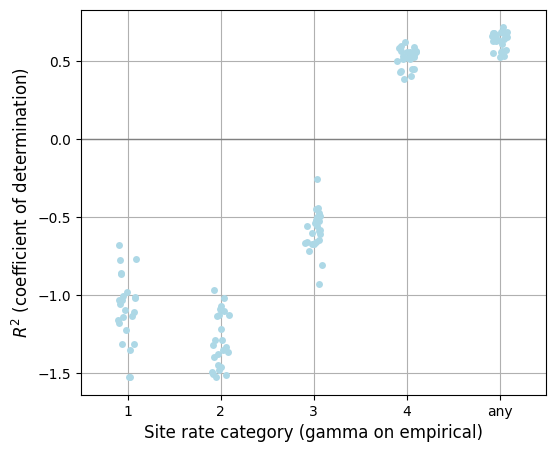

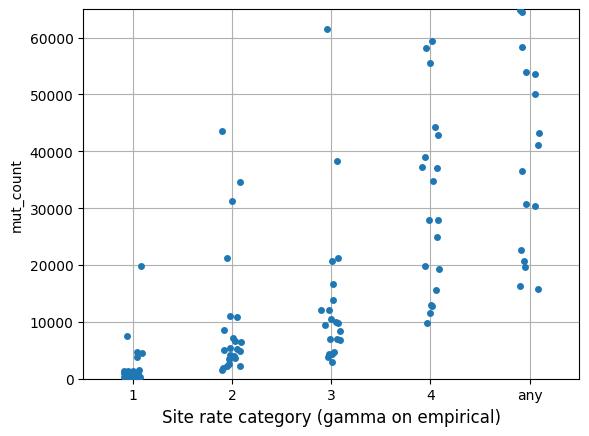

In [243]:
metrics_total_df = pd.read_csv('data/fit_metrics_site_rate_cat4.csv').sort_values(['clade', 'rate_cat'])

plt.figure(figsize=(6, 5))
ax = sns.stripplot(metrics_total_df, x='rate_cat', y='r2', color='lightblue')
# plt.xticks([0,1,2,3,4,5], ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%', 'total'])
xmin, xmax = ax.get_xbound()
ax.hlines(0, xmin, xmax, '.5', '-', linewidth=1)
ax.set_xbound(xmin, xmax)

plt.xlabel('Site rate category (gamma on empirical)', fontsize=12)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.grid()
plt.show()

ax = sns.stripplot(metrics_total_df, x='rate_cat', y='mut_count', )
ax.set_ylim(0, 65000)
plt.xlabel('Site rate category (gamma on empirical)', fontsize=12)
plt.grid()
plt.show()


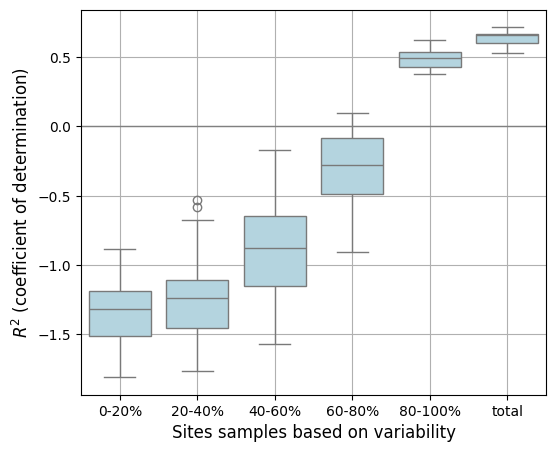

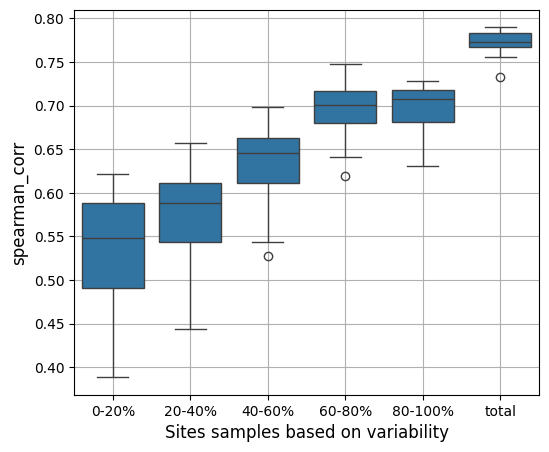

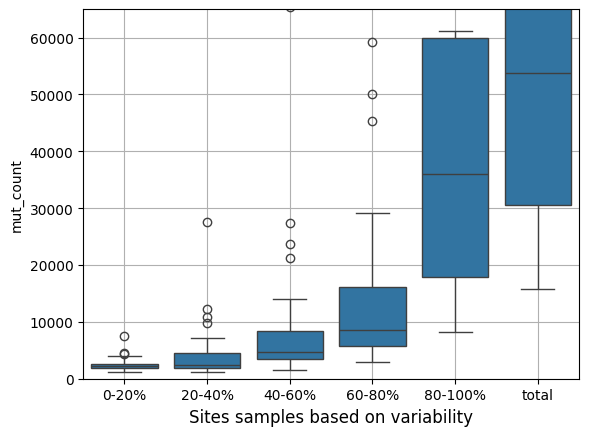

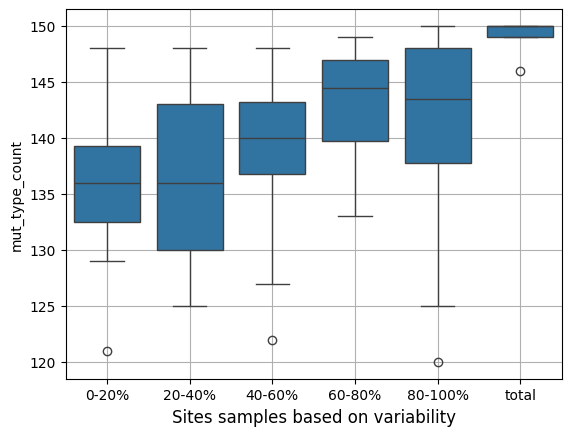

In [65]:
metrics_total_df = pd.read_csv('data/fit_metrics_site_rates5.csv')

plt.figure(figsize=(6, 5))
ax = sns.boxplot(metrics_total_df, x='sites_sample', y='r2', color='lightblue')
plt.xticks([0,1,2,3,4,5], ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%', 'total'])
xmin, xmax = ax.get_xbound()
ax.hlines(0, xmin, xmax, '.5', '-', linewidth=1)
ax.set_xbound(xmin, xmax)

plt.xlabel('Sites samples based on variability', fontsize=12)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(6, 5))
ax = sns.boxplot(metrics_total_df, x='sites_sample', y='spearman_corr', )
plt.xticks([0,1,2,3,4,5], ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%', 'total'])
plt.xlabel('Sites samples based on variability', fontsize=12)
plt.ylabel('spearman_corr', fontsize=12)
plt.grid()
plt.show()

ax = sns.boxplot(metrics_total_df, x='sites_sample', y='mut_count', )
plt.xticks([0,1,2,3,4,5], ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%', 'total'])

ax.set_ylim(0, 65000)
plt.xlabel('Sites samples based on variability', fontsize=12)
plt.grid()
plt.show()

ax = sns.boxplot(metrics_total_df, x='sites_sample', y='mut_type_count', )
plt.xticks([0,1,2,3,4,5], ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%', 'total'])

plt.xlabel('Sites samples based on variability', fontsize=12)
plt.grid()
plt.show()

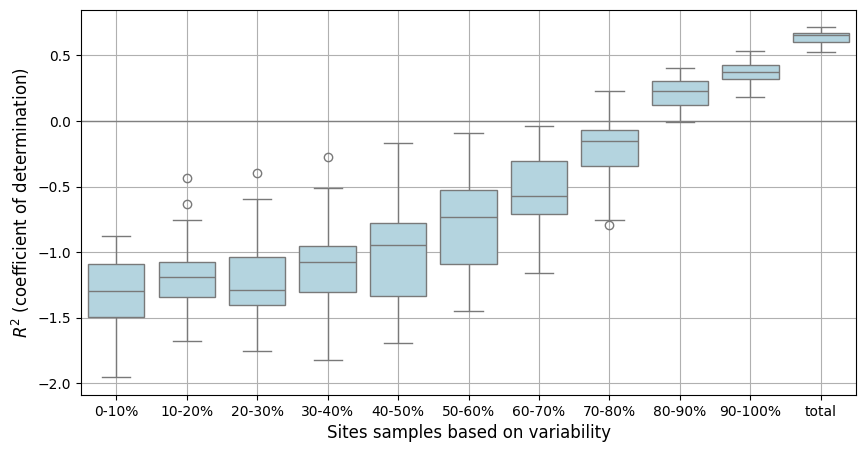

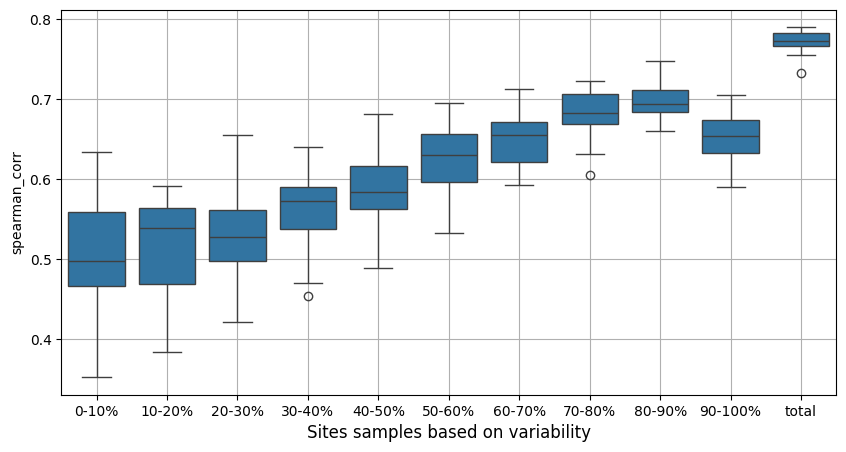

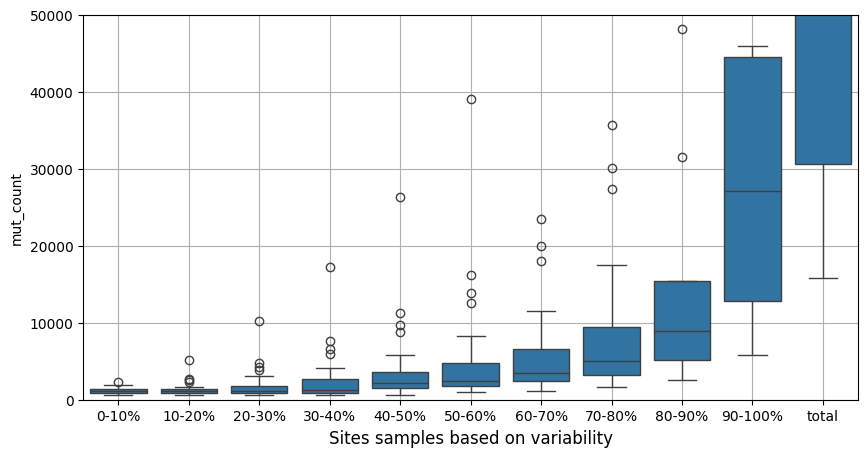

In [58]:
metrics_total_df = pd.read_csv('data/fit_metrics_site_rates10.csv')

plt.figure(figsize=(10, 5))
ax = sns.boxplot(metrics_total_df, x='sites_sample', y='r2', color='lightblue')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], ['0-10%', '10-20%', '20-30%', '30-40%', 
                                         '40-50%', '50-60%', '60-70%', '70-80%', 
                                         '80-90%', '90-100%', 'total'])
xmin, xmax = ax.get_xbound()
ax.hlines(0, xmin, xmax, '.5', '-', linewidth=1)
ax.set_xbound(xmin, xmax)
plt.xlabel('Sites samples based on variability', fontsize=12)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(metrics_total_df, x='sites_sample', y='spearman_corr', )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], ['0-10%', '10-20%', '20-30%', '30-40%', 
                                         '40-50%', '50-60%', '60-70%', '70-80%', 
                                         '80-90%', '90-100%', 'total'])
plt.xlabel('Sites samples based on variability', fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(metrics_total_df, x='sites_sample', y='mut_count', )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], ['0-10%', '10-20%', '20-30%', '30-40%', 
                                         '40-50%', '50-60%', '60-70%', '70-80%', 
                                         '80-90%', '90-100%', 'total'])
ax.set_ylim(0, 50000)
plt.xlabel('Sites samples based on variability', fontsize=12)
plt.grid()
plt.show()

### Distance to equilibrium VIZ

In [17]:
d_to_eq_df = pd.read_csv('data/dist_to_eq_site_rate_cat4.csv')
d_to_eq_df['time_period'] = d_to_eq_df['clade'].map(_clade2label)
d_to_eq_df

clade  rcat  cityblock  euclidean              time_period
0    20A     1   0.776881   0.278013             Early clades
1    20A     2   0.893650   0.311316             Early clades
2    20A     3   0.978490   0.340779             Early clades
3    20A     4   1.033760   0.357068             Early clades
4    20B     1   0.770768   0.277601             Early clades
..   ...   ...        ...        ...                      ...
91   23F     4   0.901968   0.291102  Late clades\n(Omicron+)
92   24A     1   0.645621   0.205898  Late clades\n(Omicron+)
93   24A     2   0.767837   0.240614  Late clades\n(Omicron+)
94   24A     3   0.842890   0.268165  Late clades\n(Omicron+)
95   24A     4   0.898162   0.289833  Late clades\n(Omicron+)

[96 rows x 5 columns]

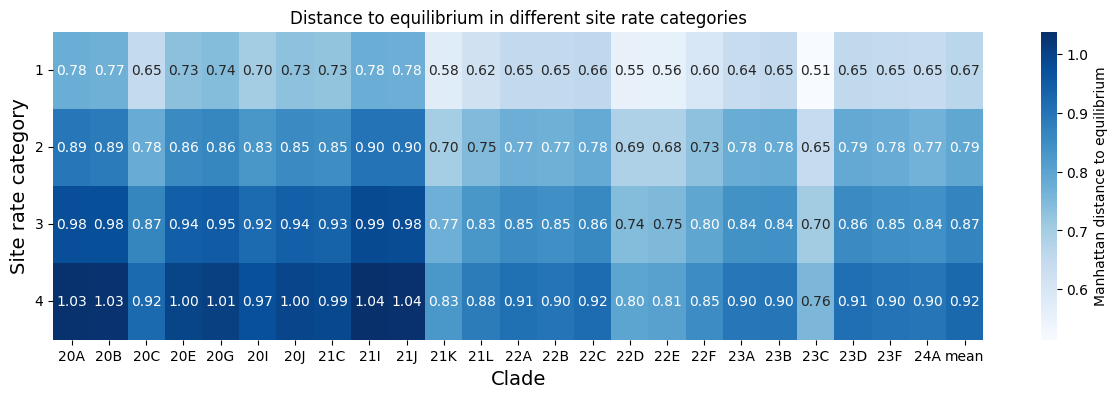

In [6]:
plt.figure(figsize=(15, 4))
_ = d_to_eq_df.pivot(index='rcat', columns='clade', values='cityblock')
_['mean'] = _.mean(axis=1)
sns.heatmap(_, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Manhattan distance to equilibrium'})
plt.title('Distance to equilibrium in different site rate categories')
plt.ylabel('Site rate category', fontsize=14)
plt.xlabel('Clade', fontsize=14)
plt.yticks(rotation=0);

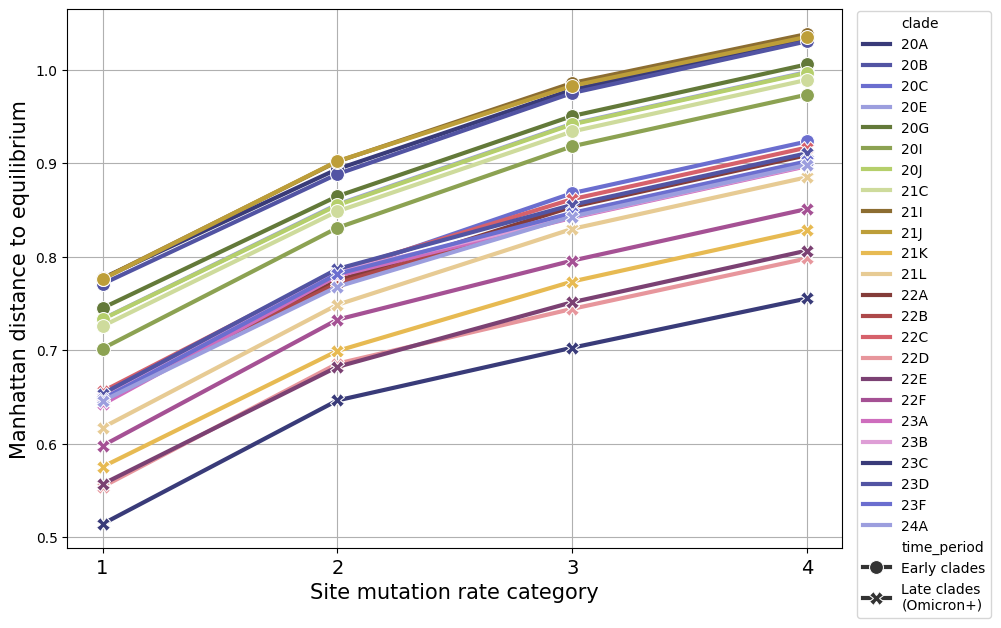

In [43]:
plt.figure(figsize=(10, 7))
ax = sns.lineplot(
    d_to_eq_df, x='rcat', y='cityblock', hue='clade', style='time_period', 
    markers=True, dashes=False, palette='tab20b', 
    linewidth=3, markersize=10, 
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(1, 5))
ax.set_ylabel('Manhattan distance to equilibrium', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

## Random model on clades 

In [9]:
metrics_rnd_df = pd.read_csv('data/fit_metrics_rnd.csv', index_col=[0,1,2])
metrics_rnd_df

r2     mape      wape     slope  intercept  \
model   clade replica                                                     
neutral 20A   1        0.561227  1.36992  0.587019  0.720492   0.001863   
random  20A   1       -0.135155  5.70277  1.143140 -0.018587   0.006791   
              2       -0.044220  5.45900  1.065530  0.048420   0.006344   
              3       -0.037847  6.05870  1.076770  0.041152   0.006392   
              4       -0.049133  4.67094  1.077770  0.064110   0.006239   
...                         ...      ...       ...       ...        ...   
        24A   16       0.007303  6.35617  1.015100  0.045311   0.006365   
              17       0.030088  7.51860  1.009970  0.089760   0.006068   
              18      -0.098874  7.42605  1.108490  0.019444   0.006537   
              19      -0.164259  5.03905  1.075310 -0.006853   0.006712   
              20      -0.342587  6.42130  1.171000 -0.034350   0.006896   

                       spearman_corr    spearman_p  pearson_corr  \
model   clade replica                                              
neutral 20A   1             0.789782  3.173920e-33      0.768153   
random  20A   1             0.014748  8.578410e-01     -0.059379   
              2             0.164345  4.446830e-02      0.128920   
              3             0.120957  1.403640e-01      0.118721   
              4             0.233528  4.026630e-03      0.152233   
...                              ...           ...           ...   
        24A   16            0.228623  4.892940e-03      0.156975   
              17            0.244165  2.603110e-03      0.232200   
              18            0.032972  6.887520e-01      0.052387   
              19            0.202097  1.313400e-02     -0.017662   
              20            0.020489  8.034690e-01     -0.065636   

                          pearson_p   ks_stat          ks_p      rmse  \
model   clade replica                                                   
neutral 20A   1        1.862200e-30  0.126667  1.803950e-01  0.008200   
random  20A   1        4.704180e-01  0.466667  3.994110e-15  0.013189   
              2        1.158810e-01  0.413333  7.435540e-12  0.012650   
              3        1.479010e-01  0.406667  1.771160e-11  0.012611   
              4        6.292490e-02  0.353333  1.044100e-08  0.012679   
...                             ...       ...           ...       ...   
        24A   16       5.506370e-02  0.440000  1.965830e-13  0.012149   
              17       4.246400e-03  0.393333  9.582440e-11  0.012008   
              18       5.243370e-01  0.360000  4.964600e-09  0.012782   
              19       8.301390e-01  0.333333  8.870020e-08  0.013157   
              20       4.248620e-01  0.220000  1.357880e-03  0.014128   

                       log_likelihood  mut_count  
model   clade replica                             
neutral 20A   1              -5.37332      65022  
random  20A   1              -6.19734      65022  
              2              -5.99208      65022  
              3              -6.02072      65022  
              4              -6.57942      65022  
...                               ...        ...  
        24A   16             -5.95878      65550  
              17             -5.95938      65550  
              18             -6.09729      65550  
              19             -6.23207      65550  
              20             -7.10441      65550  

[504 rows x 14 columns]

/tmp/ipykernel_48045/624859558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=_, sharey=False, kind='box', col='metric',


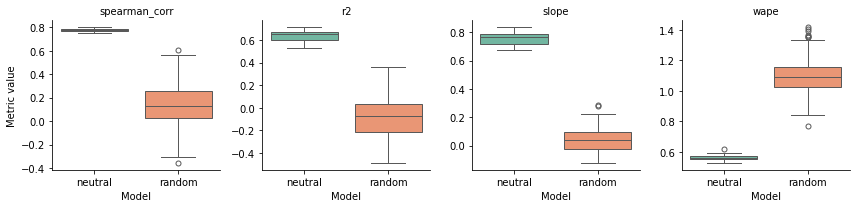

In [10]:
_ = metrics_rnd_df[['spearman_corr', 'r2', 'slope', 'wape']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', 
                y='value', x='model', palette='Set2', height=3, aspect=1,
)
g.set_titles('{col_name}')
# g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Model')
g.set_ylabels('Metric value')
g.savefig('./figures/rnd_fit_metrics_boxplots.pdf')


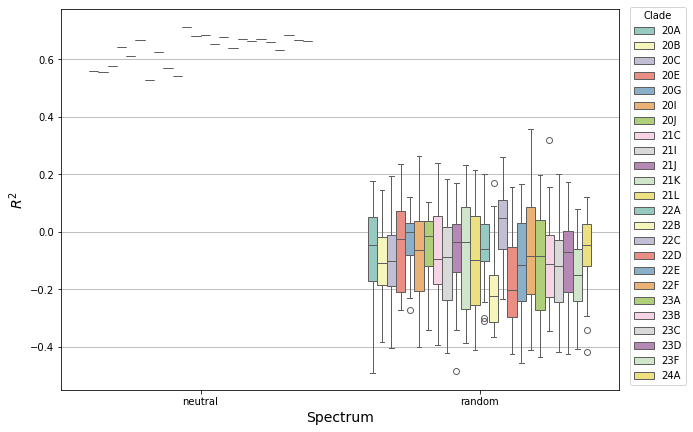

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=metrics_rnd_df.reset_index(), 
                y='r2', x='model', hue='clade',
                palette='Set3',
)
ax.set_xlabel('Spectrum', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.legend(title='Clade', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
plt.savefig('./figures/fit_metrics_rnd.pdf')